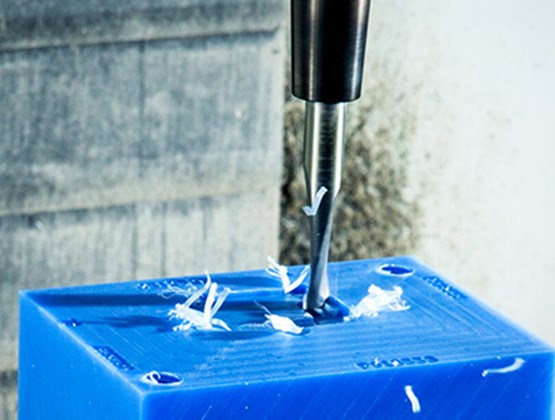


* A series of machining experiments were run on 2" x 2" x 1.5" wax blocks in a CNC milling machine in the System-level Manufacturing and Automation Research Testbed (SMART) at the University of Michigan. Machining data was collected from a CNC machine for variations of tool condition, feed rate, and clamping pressure. Each experiment produced a finished wax part with an "S" shape - S for smart manufacturing - carved into the top face, as shown in test_artifact.jpg.

## Step #0: Preparation
### Import Libraries

In [1]:
# libraries for analysis dataset
import pandas as pd
import numpy as np
# libraries for visualization
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
# libraries for preprocessing
from sklearn. model_selection import train_test_split, cross_val_predict, cross_val_score
#from sklearn import linear_model
from feature_engine.imputation import RandomSampleImputer, MeanMedianImputer, ArbitraryNumberImputer
from feature_engine.selection import DropConstantFeatures,DropDuplicateFeatures,SmartCorrelatedSelection
from feature_engine.discretisation import EqualFrequencyDiscretiser,EqualWidthDiscretiser
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
# libraries for model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
# libraries for scoring    
from sklearn.metrics import (roc_auc_score,
                             confusion_matrix,
                             ConfusionMatrixDisplay,
                             accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score,
                             precision_recall_fscore_support,
                             classification_report )
# alarms
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

### Functions for visualization

In [2]:
# let's see diagnostic plots
def diagnostic_plots(data, variable):
    fig = plt.figure()
    plt.figure(figsize = (18, 5))
   # histogram
    plt.subplot(1, 3, 1)
    fig = data[variable].hist(bins = 30,color = "indigo")
    plt.title('Histogram')
    fig.set_ylabel (variable)
    fig.set_xlabel(variable)
    # probability plot
    plt.subplot(1, 3, 2)
    stats.probplot(data[variable], dist = 'norm', plot = plt)
    # boxplot
    plt.subplot(1, 3, 3)
    fig = data.boxplot(column = variable,color = "indigo")
    fig.set_title('Boxplot')
    fig.set_ylabel(variable)
    plt.show()

In [3]:
# show missing data in percentage
def missing_data(X,y,color_list,title):
    missing= X.isnull().sum()[X.isnull().sum() !=0].sort_values(ascending=False)
    missing=pd.DataFrame(missing.reset_index())
    missing.rename(columns={'index':'features',0:'missing_count'},inplace=True)
    missing['percentage (%)']=((missing['missing_count'])/len(X))*100
    plt.figure(figsize=(15,9))
    sns.barplot(y=missing['features'],x=missing['percentage (%)'], color=color_list)
    plt.title(title)
    return missing

In [4]:
# visualization of imputation
def make_plot(X_train, variable, variable_1, variable_2,variable_3,variable_4):
    fig = plt.figure(figsize=(9,5))
    ax = fig.add_subplot(111)
    X_train[variable].plot(kind='kde', ax=ax)
    X_train[variable_1].plot(kind='kde', ax=ax,color='yellow',label='MeanMedianImputer(mean)')
    X_train[variable_2].plot(kind='kde', ax=ax, color='red', label='MeanMedianImputer(median)')
    X_train[variable_3].plot(kind='kde', ax=ax, color='green', label='RandomSampleImputer')
    X_train[variable_4].plot(kind='kde', ax=ax, color='purple', label='ArbitraryNumberImputer')
    lines, labels = ax.get_legend_handles_labels()
    ax.legend(lines, labels, loc='best')

# checking for outliers    
    plt.figure(figsize=(10,3))
    sns.boxplot(data=X_train[[variable,variable_1, variable_2, variable_3, variable_4]], color="indigo")
    plt.xticks(rotation = 90)
    plt.title('BoxPlot after Imputation')
    plt.show()

# for variance
    print('Original variable variance:', X_train[variable].var()) 
    print('Variance after median imputation:', X_train[variable_1].var())
    print('Variance after mean imputation:', X_train[variable_2].var())
    print('Variance after random imputer:', X_train[variable_3].var())
    print('Variance after arbitrary imputer:', X_train[variable_4].var())

In [5]:
def discretisation_plot(X_train,X_test,X_train_copy1, X_test_copy1, X_train_copy2, X_test_copy2,variable):
    t1 = X_train.groupby([variable])[variable].count() / len(X_train)
    t2 = X_test.groupby([variable])[variable].count() / len(X_test)
    tmp = pd.concat([t1, t2], axis=1)
    tmp.columns = ['train', 'test']
    tmp.plot.bar()
    plt.title('Before Binning')
    plt.xticks(rotation=0)
    plt.ylabel('Number of observations per bin');
    plt.show()    
    t1 = X_train_copy1.groupby([variable])[variable].count() / len(X_train_copy1)
    t2 = X_test_copy1.groupby([variable])[variable].count() / len(X_test_copy1)
    tmp = pd.concat([t1, t2], axis=1)
    tmp.columns = ['train', 'test']
    tmp.plot.bar()
    plt.title('With EqualFrequencyDiscretiser')
    plt.xticks(rotation=0)
    plt.ylabel('Number of observations per bin');
    plt.show()
    t1 = X_train_copy2.groupby([variable])[variable].count() / len(X_train_copy2)
    t2 = X_test_copy2.groupby([variable])[variable].count() / len(X_test_copy2)
    tmp = pd.concat([t1, t2], axis=1)
    tmp.columns = ['train', 'test']
    tmp.plot.bar()
    plt.title('With EqualWidthDiscretiser')
    plt.xticks(rotation=0)
    plt.ylabel('Number of observations per bin');
    plt.show()
    
    # checking for outliers
def box_discretisation_plot(X,X_copy1,X_copy2,variable):
    plt.figure(figsize=(10,3))
    plt.subplot(1,3,1)
    X[variable].plot.box(title="Before discretization",color = "indigo")
    plt.subplot(1,3,2)
    X_copy1[variable].plot.box(title="After EqualFrequencyDiscretiser",color = "indigo")
    plt.subplot(1,3,3)
    X_copy2[variable].plot.box(title="After EqualWidthDiscretiser",color = "indigo")

In [6]:
# visualization
def scaling_plot(x, x_copy1, x_copy2,x_copy3,variable,variable1,variable2,variable3):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols = 4, figsize =(20, 5))
    ax1.set_title('Before Scaling')  
    sns.kdeplot(x[variable], ax = ax1, color ='aqua')
    sns.kdeplot(x[variable1], ax = ax1, color ='blue')
    sns.kdeplot(x[variable2], ax = ax1, color ='red')
    sns.kdeplot(x[variable3], ax = ax1, color ='green')

    ax2.set_title('After Standard Scaling')  
    sns.kdeplot(x_copy1[variable], ax = ax2, color ='aqua')
    sns.kdeplot(x_copy1[variable1], ax = ax2, color ='blue')
    sns.kdeplot(x_copy1[variable2], ax = ax2, color ='red')
    sns.kdeplot(x_copy1[variable3], ax = ax2, color ='green')

    ax3.set_title('After Min-Max Scaling')  
    sns.kdeplot(x_copy2[variable], ax = ax3, color ='aqua')
    sns.kdeplot(x_copy2[variable1], ax = ax3, color ='blue')
    sns.kdeplot(x_copy2[variable2], ax = ax3, color ='red')
    sns.kdeplot(x_copy2[variable3], ax = ax3, color ='green')

    ax4.set_title('After Robust Scaling')  
    sns.kdeplot(x_copy3[variable], ax = ax4, color ='aqua')
    sns.kdeplot(x_copy3[variable1], ax = ax4, color ='blue')
    sns.kdeplot(x_copy3[variable2], ax = ax4, color ='red')
    sns.kdeplot(x_copy3[variable3], ax = ax4, color ='green') 
    
# visualization for outliers
def box_plot(x,x_copy1,x_copy2,x_copy3,variable):
    plt.figure(figsize=(12,3))
    plt.subplot(1,4,1)
    x[variable].plot.box(title="Before Scaling",color = "indigo")
    plt.subplot(1,4,2)
    x_copy1[variable].plot.box(title="After Standard Scaling",color = "indigo")
    plt.subplot(1,4,3)
    x_copy2[variable].plot.box(title="After Min-Max Scaling",color = "indigo")
    plt.subplot(1,4,4)
    x_copy3[variable].plot.box(title="After Robust Scaling",color = "indigo")

In [7]:
# define function to show the results for classifier
def score_show(y_train, y_test, y_pred_train, y_pred_test):

    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 3)) 
    
    print('Train: ')
    print('accuracy %s' % accuracy_score(y_train, y_pred_train))
    axes[0].set_title('Train Confusion Matrix')
    cm = confusion_matrix(y_train, y_pred_train)
    sns.heatmap(cm, annot = True, fmt = 'd', ax = axes[0], cmap=plt.cm.BuPu)    
    print(classification_report(y_train, y_pred_train))
    print('------------------------------------------------------')
    print('Test: ')
    print('accuracy %s' % accuracy_score(y_test, y_pred_test))
    axes[1].set_title('Test Confusion Matrix')
    cm_t = confusion_matrix(y_test, y_pred_test)
    sns.heatmap(cm_t, annot = True, fmt = 'd', ax = axes[1], cmap=plt.cm.BuPu)    
    print(classification_report(y_test, y_pred_test))

In [8]:
# actual vs predicted
def predicted_plot(y_test, y_pred_test):
    count_points=70
    c = [i for i in range(1,count_points+1,1)]
    fig = plt.figure(figsize=(12,3))
    plt.plot(c,y_test[:count_points], color="indigo", linewidth=2.5, linestyle="-")
    plt.plot(c,y_pred_test[:count_points], color="y",  linewidth=2.5, linestyle=":")
    fig.suptitle('Actual and Predicted', fontsize=20)              
    plt.xlabel('Index', fontsize=18)                              
    plt.ylabel('Worn_status', fontsize=16) 

## Step #1 : Import dataset

In [9]:
# load the dataset
main_df = pd.read_csv('../input_TP/train.csv')
# show the first 5 rows of the dataset
main_df.head()

No material  feedrate  clamp_pressure tool_condition machining_finalized  \
0   1      wax         6             4.0         unworn                 yes   
1   2      wax        20             4.0         unworn                 yes   
2   3      wax         6             3.0         unworn                 yes   
3   4      wax         6             2.5         unworn                  no   
4   5      wax        20             3.0         unworn                  no   

  passed_visual_inspection  
0                      yes  
1                      yes  
2                      yes  
3                      NaN  
4                      NaN

In [10]:
# information of the dataset
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   No                        18 non-null     int64  
 1   material                  18 non-null     object 
 2   feedrate                  18 non-null     int64  
 3   clamp_pressure            18 non-null     float64
 4   tool_condition            18 non-null     object 
 5   machining_finalized       18 non-null     object 
 6   passed_visual_inspection  14 non-null     object 
dtypes: float64(1), int64(2), object(4)
memory usage: 1.1+ KB


# Step #2 : Analysis 
## Step #2.1: Exploratory data analysis

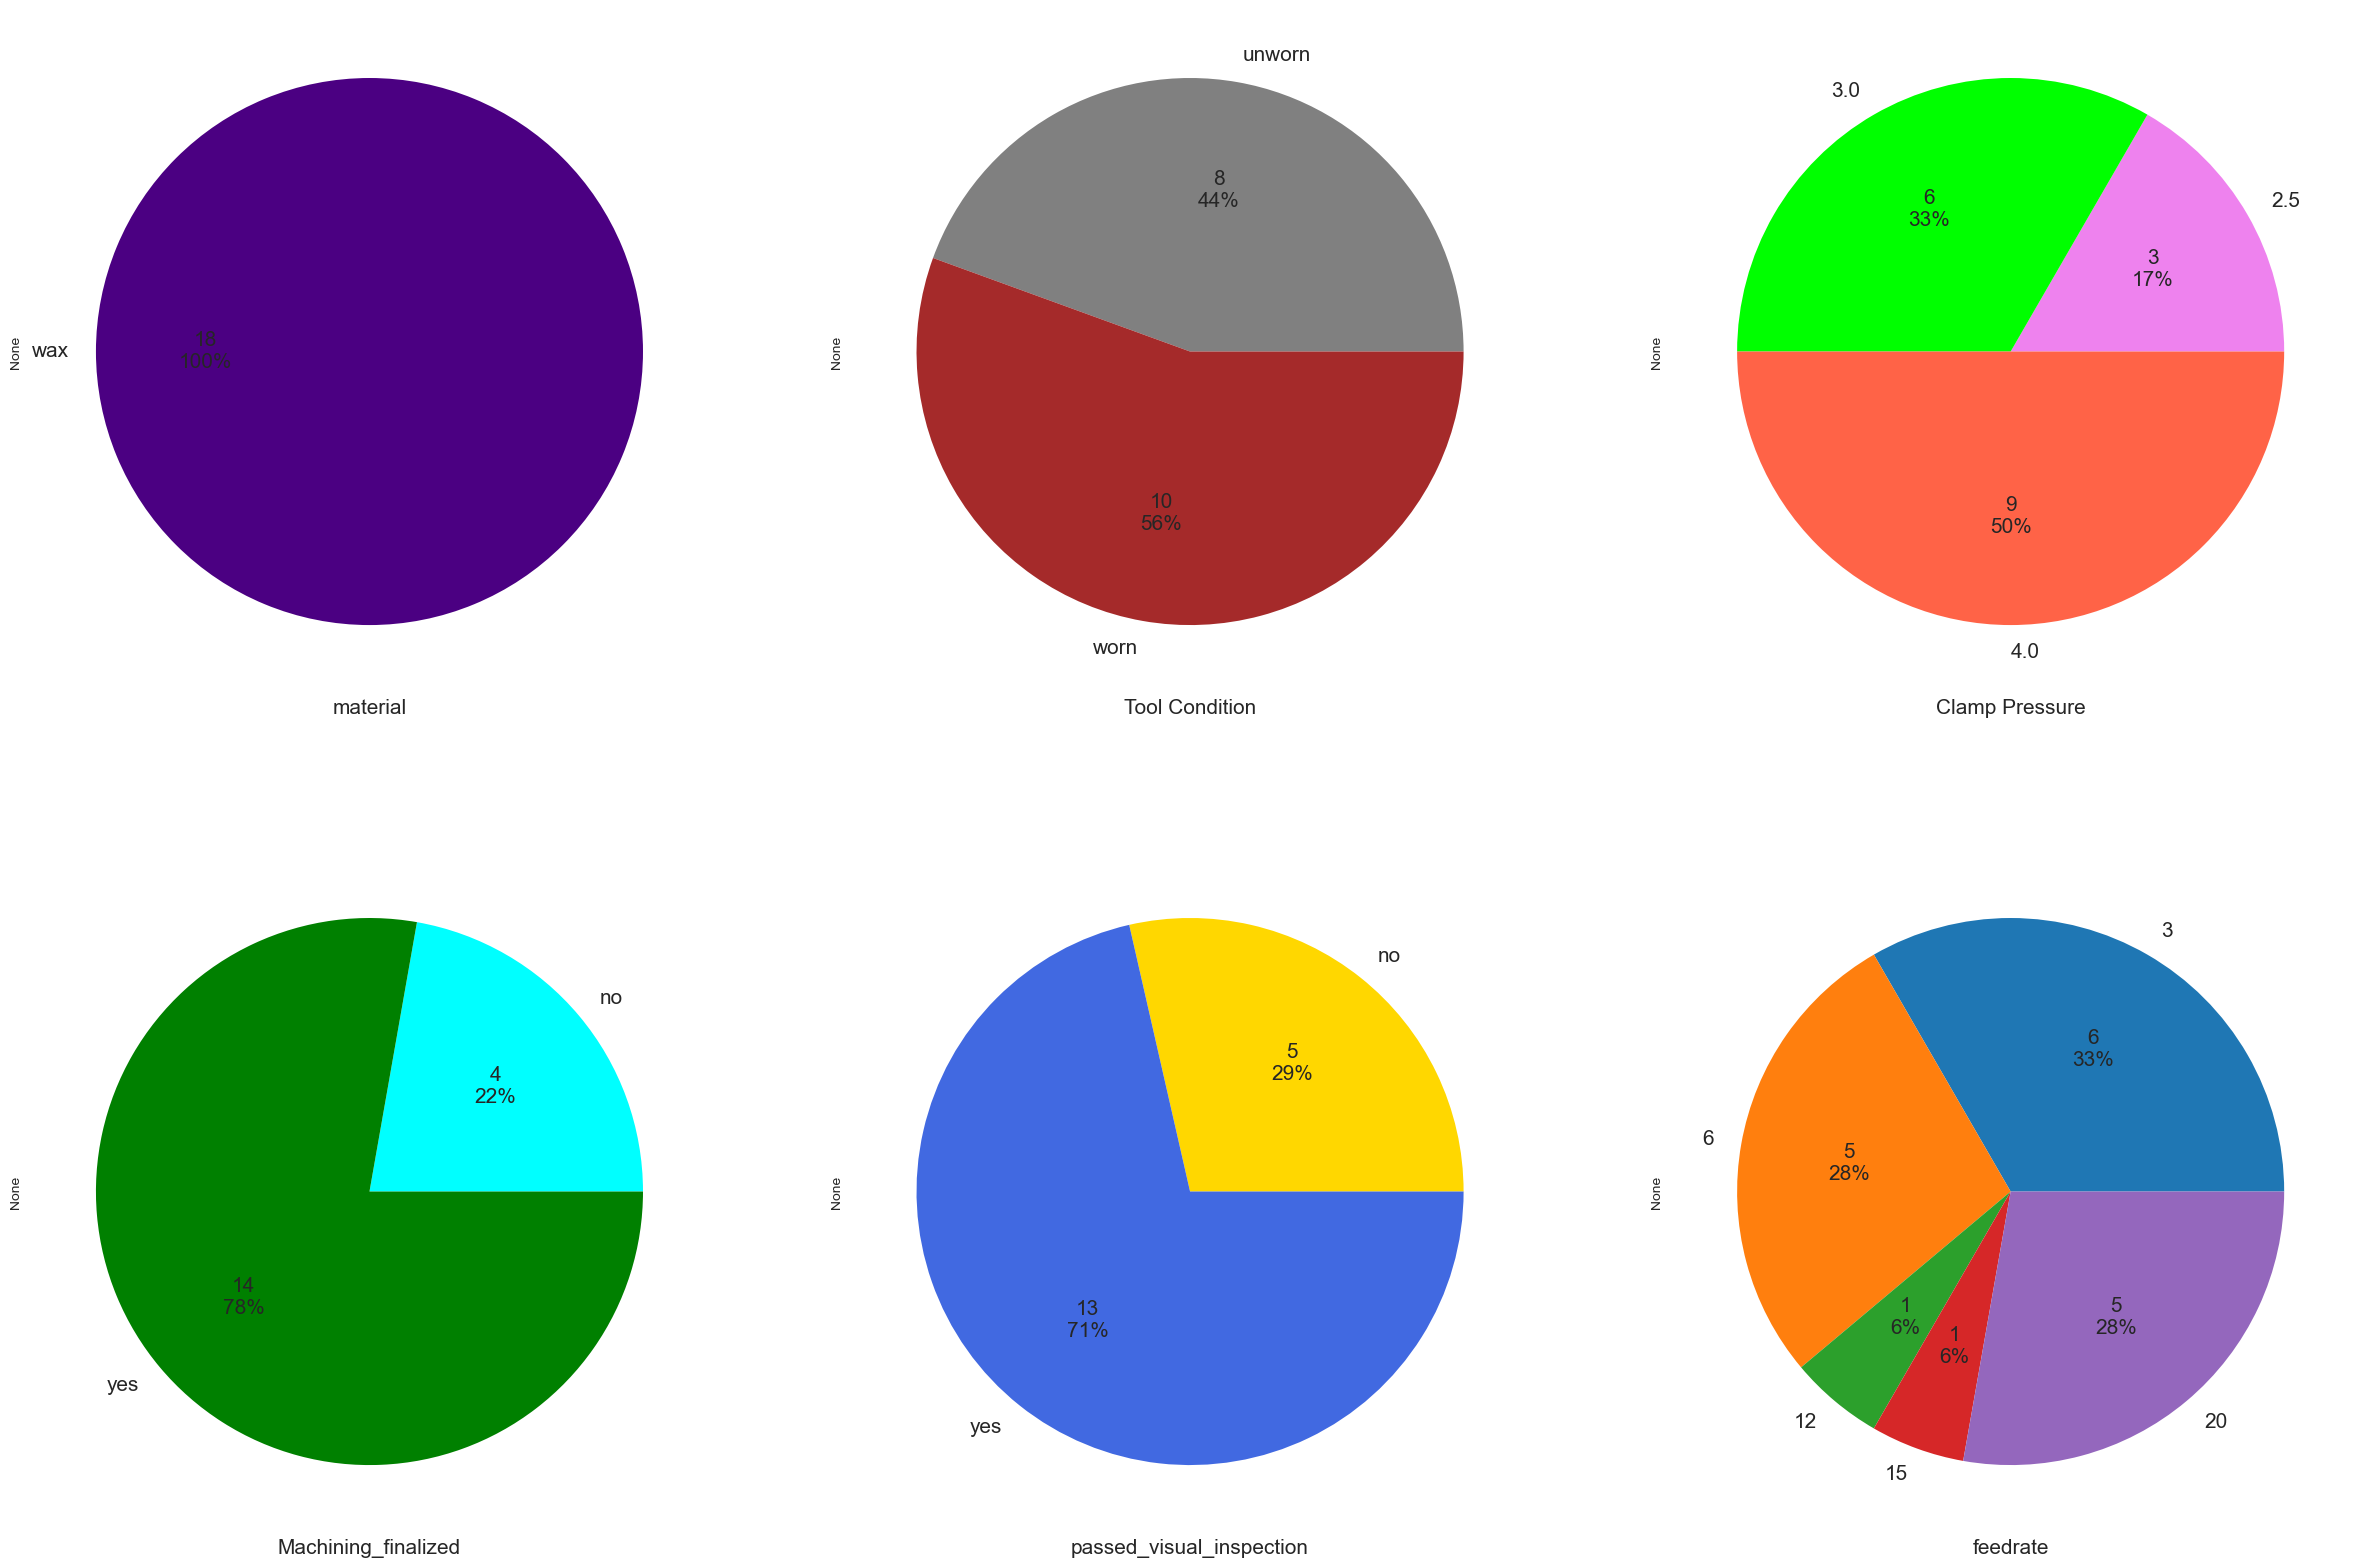

In [11]:
plt.style.use('seaborn-darkgrid')
fig, ((ax0,ax1,ax2),(ax3,ax4,ax5))=plt.subplots(nrows=2, ncols=3, figsize=(30, 20))
def label_function(val):
    return f'{val / 100 * len(main_df):.0f}\n{val:.0f}%'
# feedrate
main_df.groupby('material').size().plot(kind='pie',
                                      autopct=label_function, 
                                      textprops={'fontsize': 15},
                                      colors=['indigo'],
                                      ax=ax0)                                         
ax0.set_xlabel('material',size=15)
# Tool Condition
main_df.groupby('tool_condition').size().plot(kind='pie', 
                                              autopct=label_function,
                                              textprops={'fontsize': 15},
                                              colors = ['grey','brown'],
                                              ax=ax1)
ax1.set_xlabel('Tool Condition',size=15)
# Pressure
main_df.groupby('clamp_pressure').size().plot(kind='pie', 
                                      autopct=label_function, 
                                      textprops={'fontsize': 15},
                                      colors=['violet', 'lime','tomato'],
                                      ax=ax2)
ax2.set_xlabel('Clamp Pressure',size=15)
# Machining Finalized
main_df.groupby('machining_finalized').size().plot(kind='pie',
                                                 autopct=label_function, 
                                                 textprops={'fontsize': 15},
                                                 colors=['aqua', 'green'],
                                                 ax=ax3)
ax3.set_xlabel('Machining_finalized',size=15)
# passed_visual_inspection
main_df.groupby('passed_visual_inspection').size().plot(kind='pie',
                                                 autopct=label_function, 
                                                 textprops={'fontsize': 15},
                                                 colors=['gold', 'royalblue'],
                                                 ax=ax4)                                         
ax4.set_xlabel('passed_visual_inspection',size=15)
# feedrate
main_df.groupby('feedrate').size().plot(kind='pie',
                                      autopct=label_function, 
                                      textprops={'fontsize': 15},
                                      ax=ax5)                                         
ax5.set_xlabel('feedrate',size=15)
# showing the figure
fig.show()

**General data from a total of 18 different experiments are given in train.csv and includes:**

 Inputs (features)

* **No:** experiment number
* **material:** wax (100%).
* **feed_rate:** relative velocity of the cutting tool along the workpiece (20 mm/s (5 times), 15 mm/s (1 times), 12 mm/s (1 times), 6 mm/s (5 times), 3 mm/s (6 times))
* **clamp_pressure:** pressure used to hold the workpiece in the vise (4.0 bar(9 times), 3.0 bar(6 times), 2.5 bar(3 times)).

Outputs (predictions)

* **tool_condition:** label for unworn 8 times and worn 10 times tools.
* **machining_finalized:** indicator for if machining was completed 14 times and machining wasn't completed 4 times.  
* **passed_visual_inspection:** indicator for if the workpiece passed visual inspection 13 times and didn't passed visual inspection 5 times.

In [12]:
# read all experiment files into one data
data = list()
for i in range(1,19):
    file = pd.read_csv('../input_TP/experiment_{}.csv'.format('0'+str(i) if i < 10 else str(i)))
    row = main_df[main_df['No'] == i]
    file['feedrate'] = row.iloc[0].feedrate
    file['clamp_pressure'] = row.iloc[0].clamp_pressure
    file['label'] = 1 if row.iloc[0]['tool_condition'] == 'worn' else 0   
    data.append(file)
    
#  machining process steps encoding     
pro = {
    'Layer 1 Up': 1,
    'Repositioning': 2,
    'Layer 2 Up': 3,
    'Layer 2 Up': 4,
    'Layer 1 Down': 5,
    'End': 6,
    'Layer 2 Down': 7,
    'Layer 3 Down': 8,
    'Prep': 9,
    'end': 10,
    'Starting': 11
}
for dataset in data:
    dataset['Machining_Process'] = dataset['Machining_Process'].map(pro)
    
# concatenate into one dataframe
data = pd.concat(data,
                 ignore_index=True)

<Figure size 640x480 with 0 Axes>

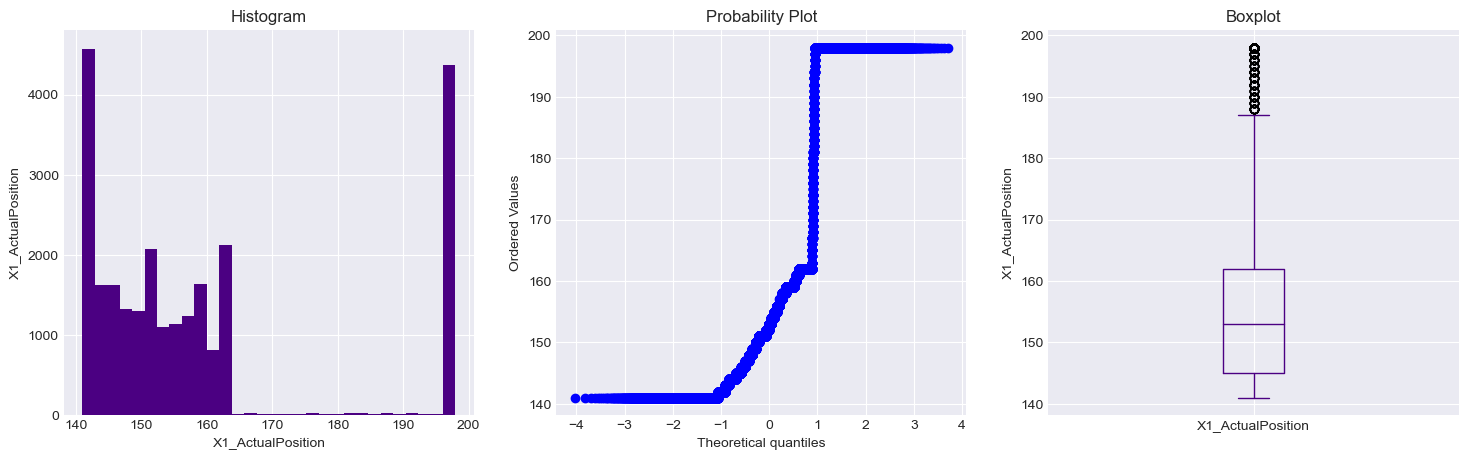

<Figure size 640x480 with 0 Axes>

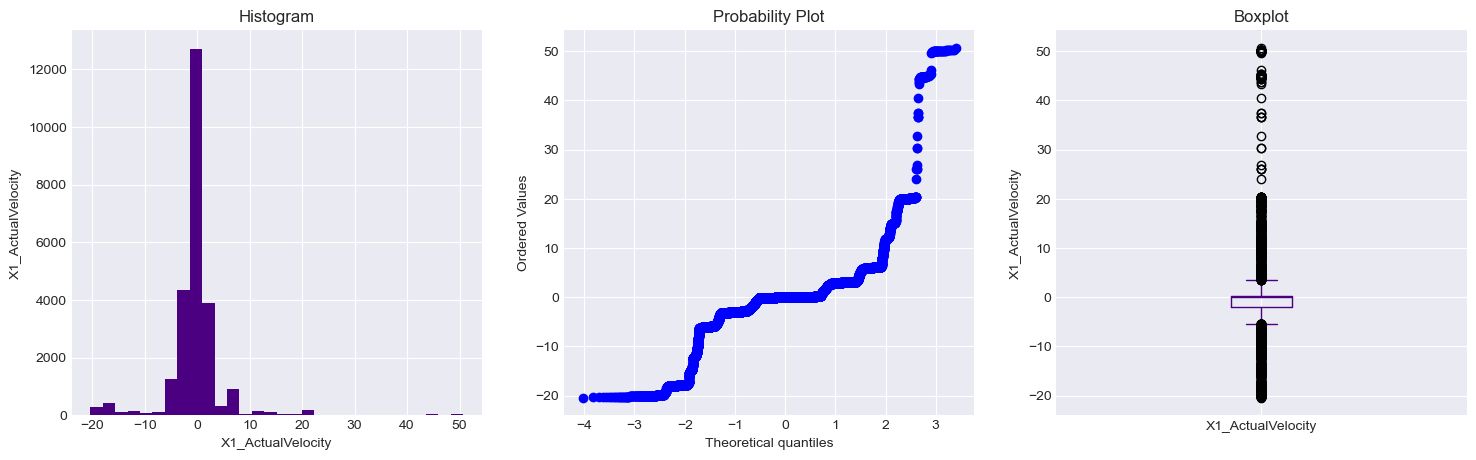

<Figure size 640x480 with 0 Axes>

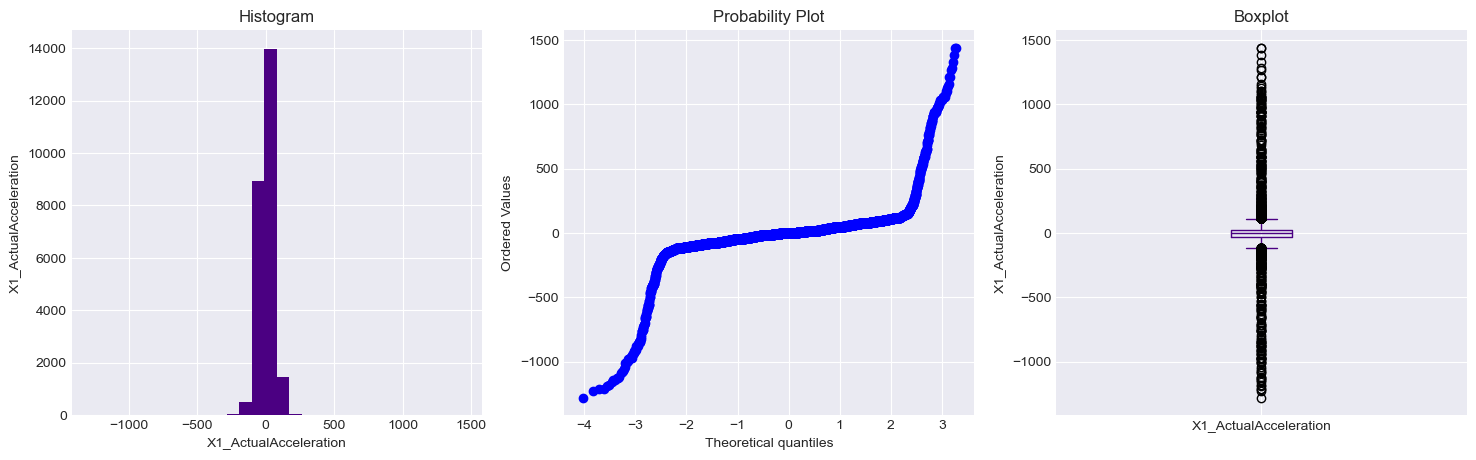

<Figure size 640x480 with 0 Axes>

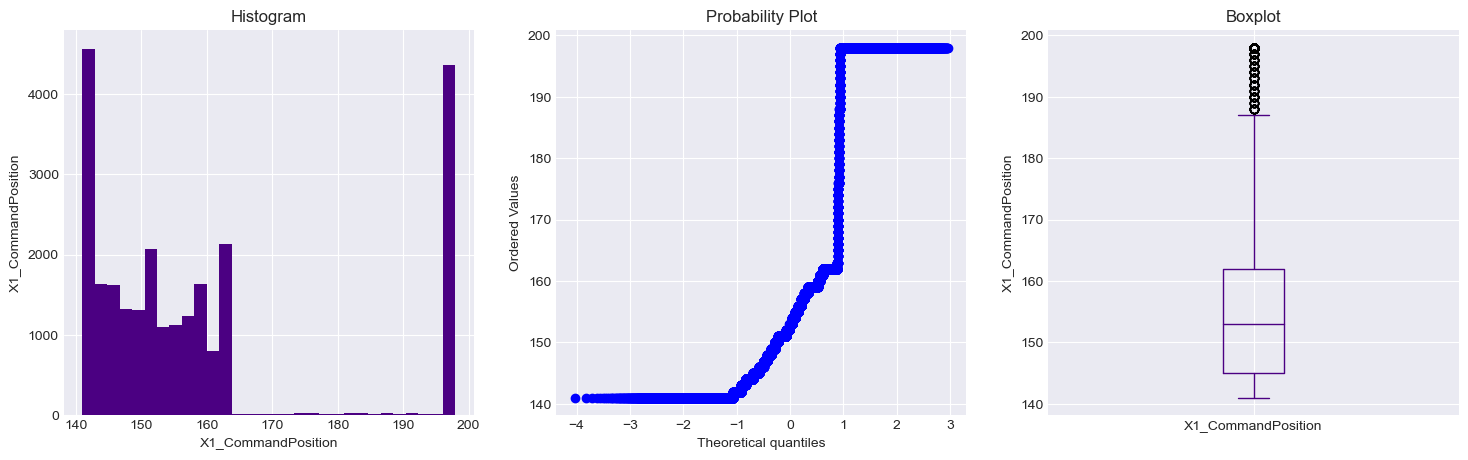

<Figure size 640x480 with 0 Axes>

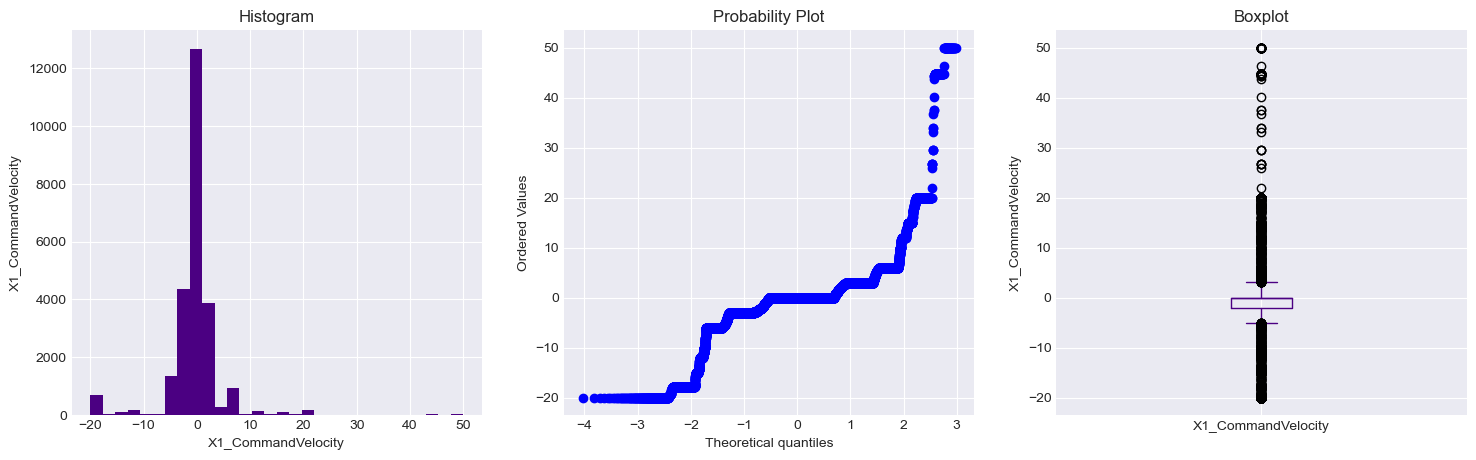

<Figure size 640x480 with 0 Axes>

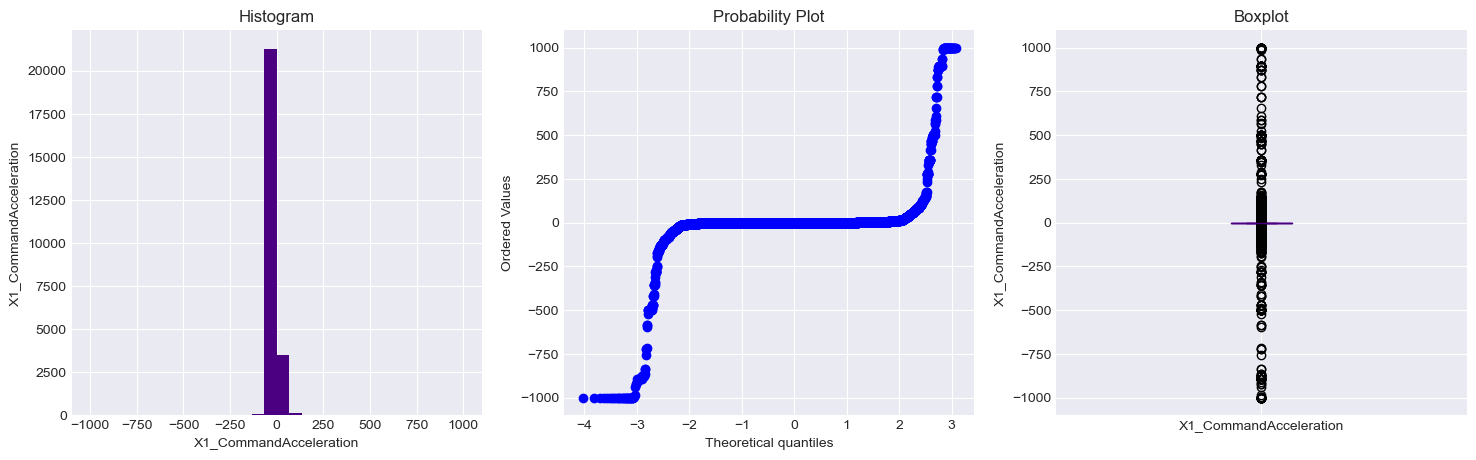

<Figure size 640x480 with 0 Axes>

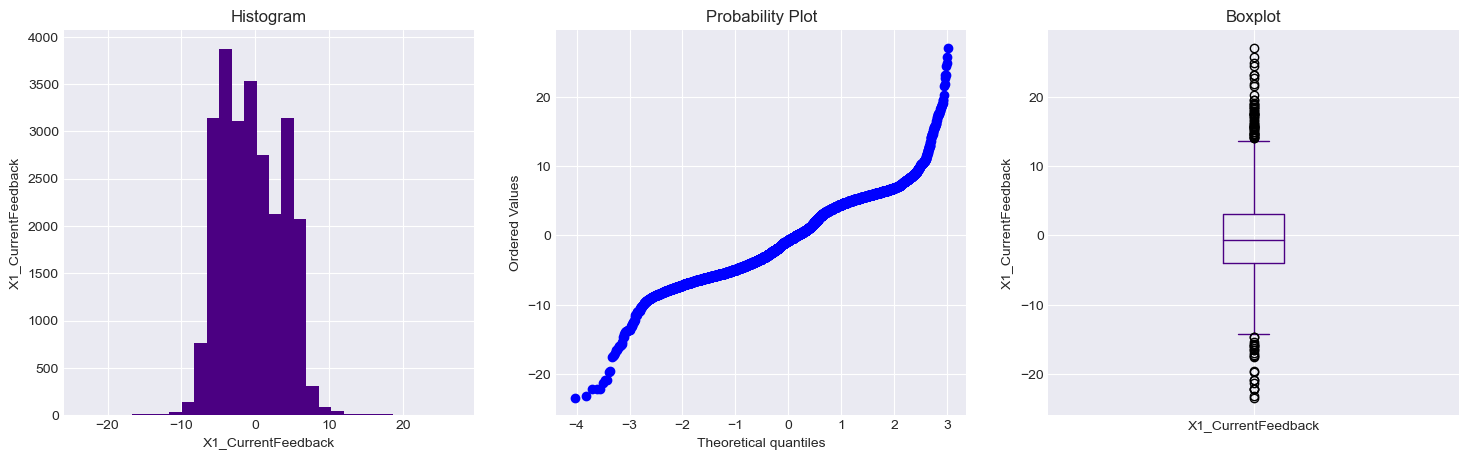

<Figure size 640x480 with 0 Axes>

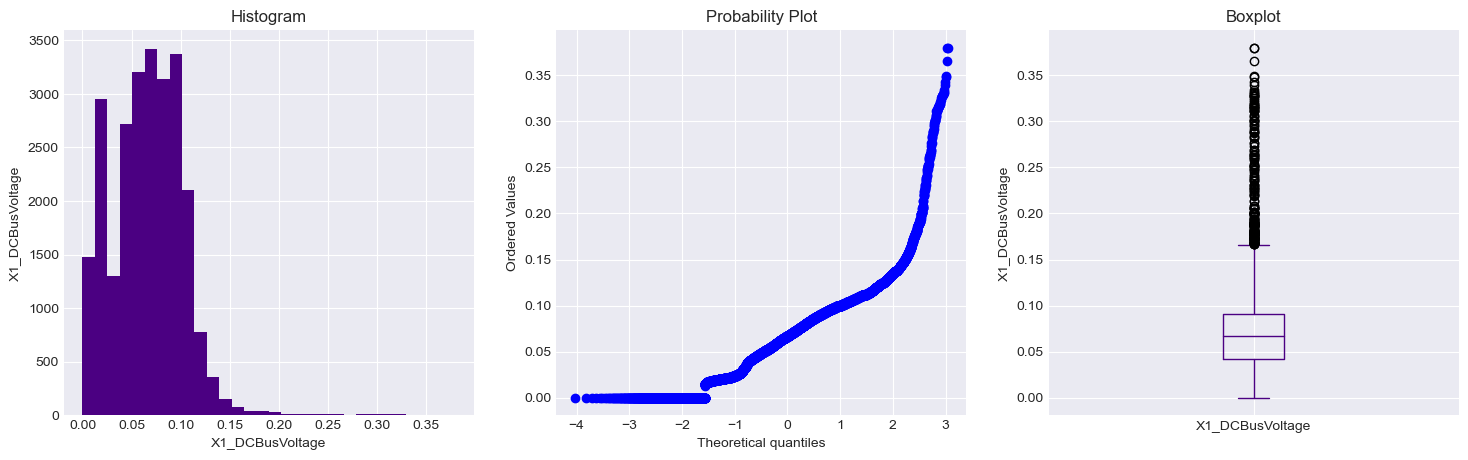

<Figure size 640x480 with 0 Axes>

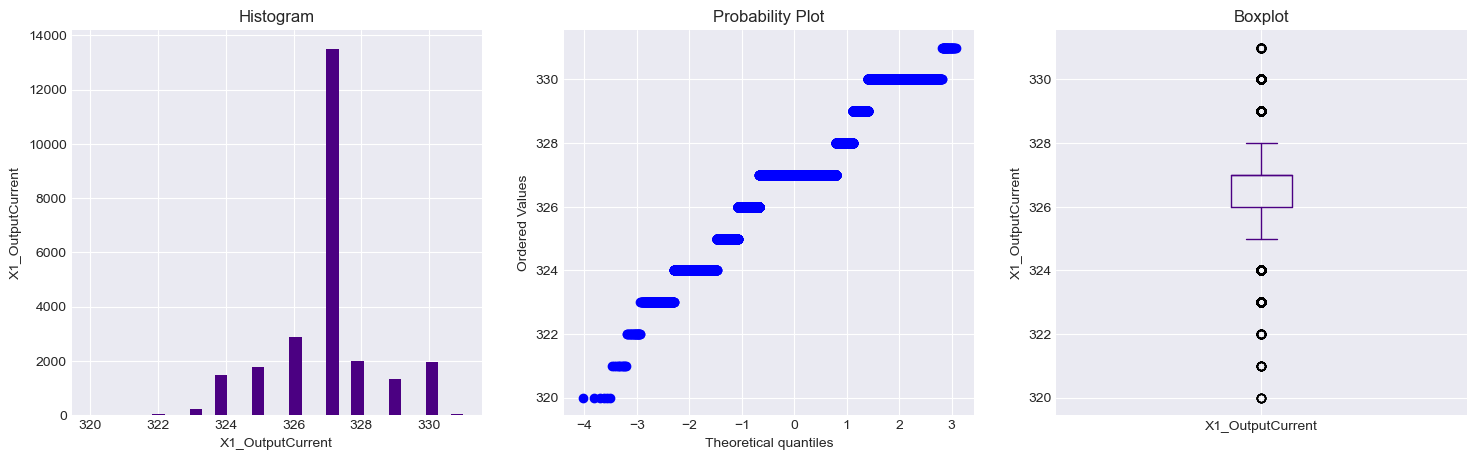

<Figure size 640x480 with 0 Axes>

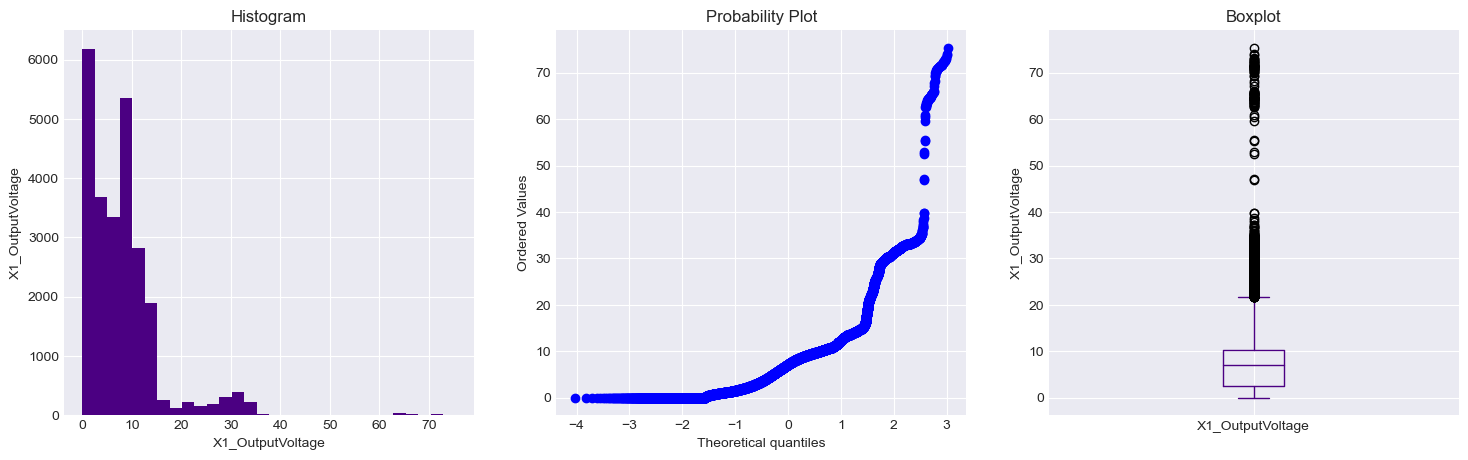

<Figure size 640x480 with 0 Axes>

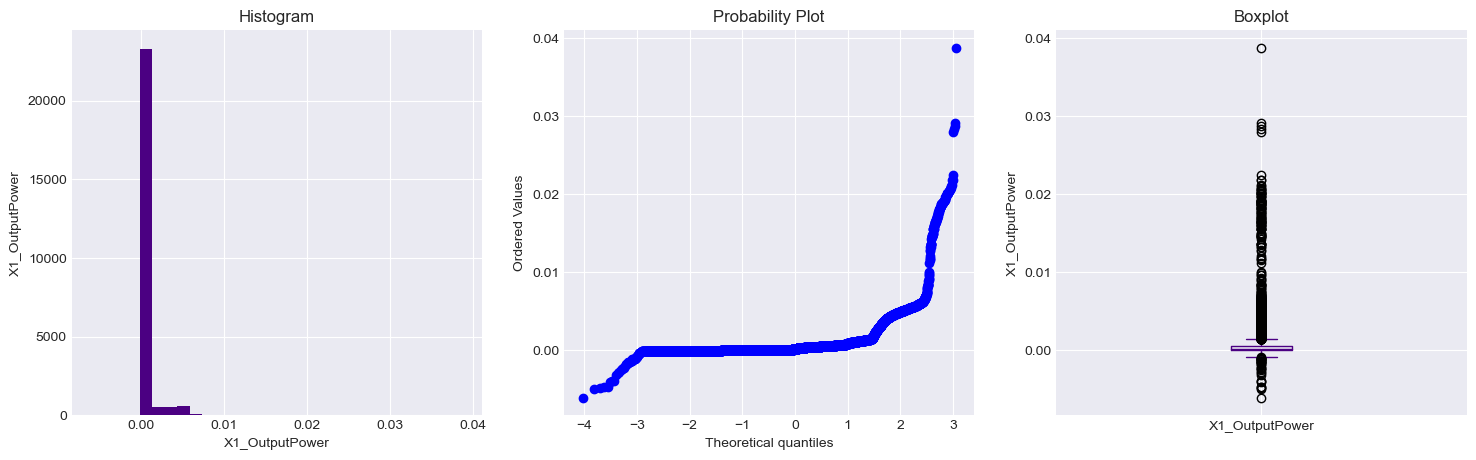

<Figure size 640x480 with 0 Axes>

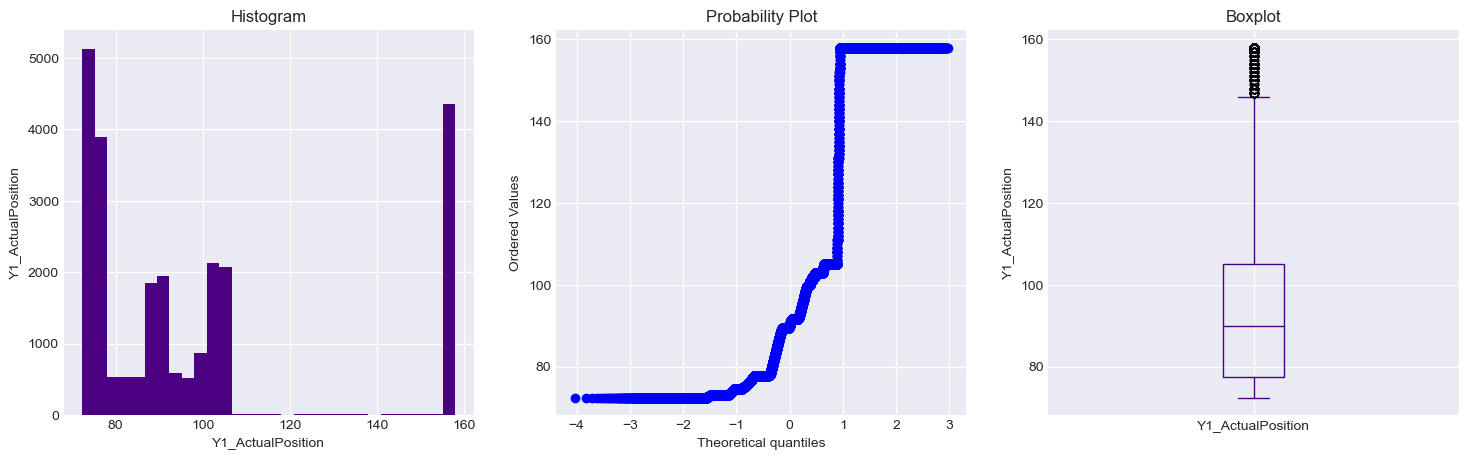

<Figure size 640x480 with 0 Axes>

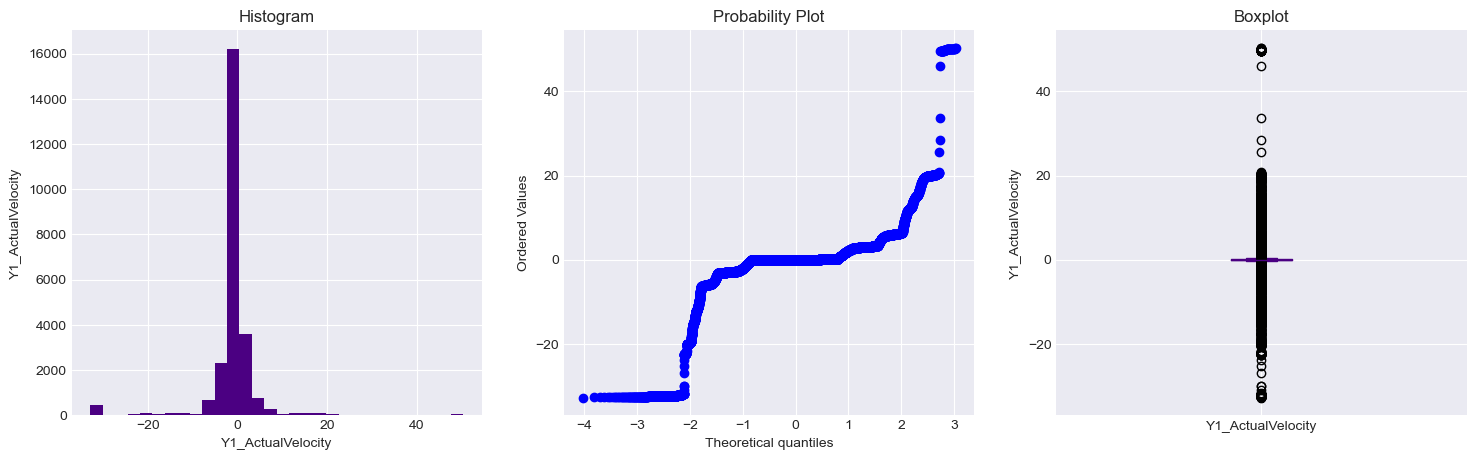

<Figure size 640x480 with 0 Axes>

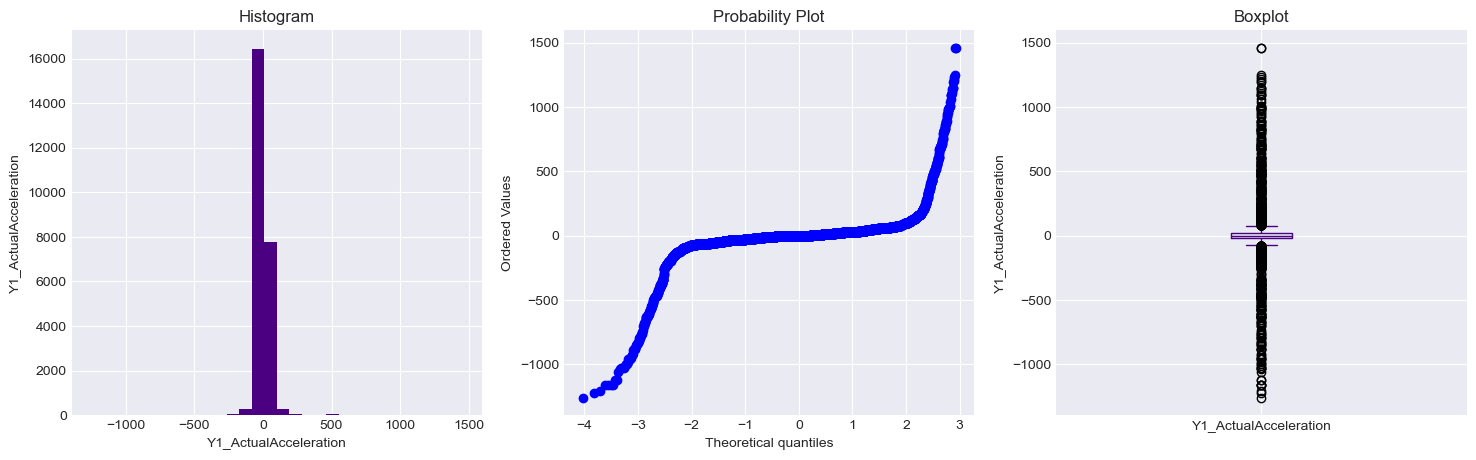

<Figure size 640x480 with 0 Axes>

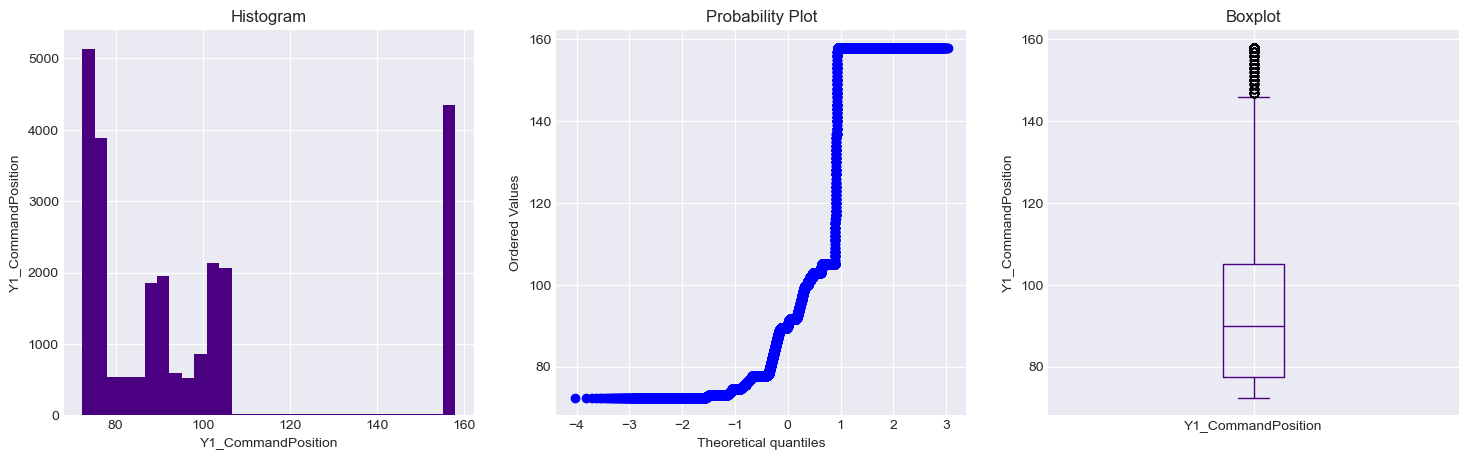

<Figure size 640x480 with 0 Axes>

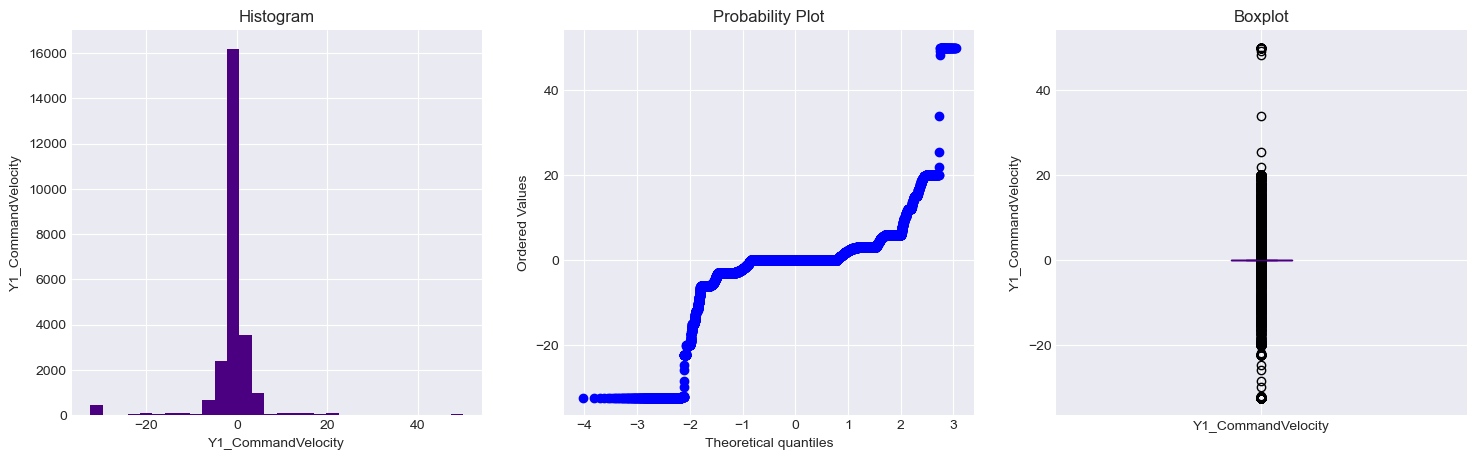

<Figure size 640x480 with 0 Axes>

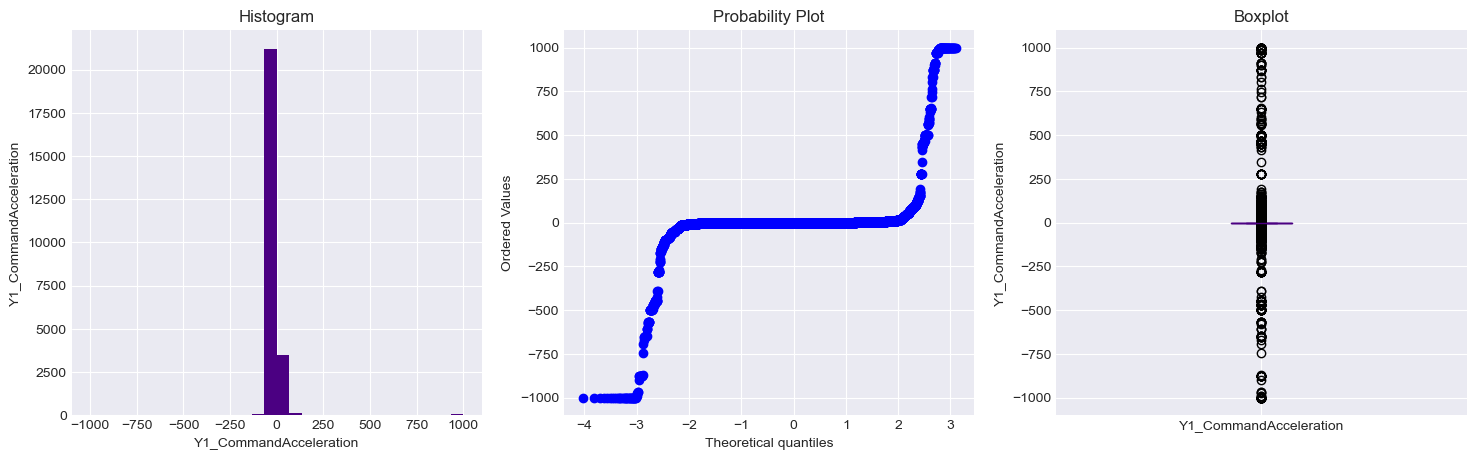

<Figure size 640x480 with 0 Axes>

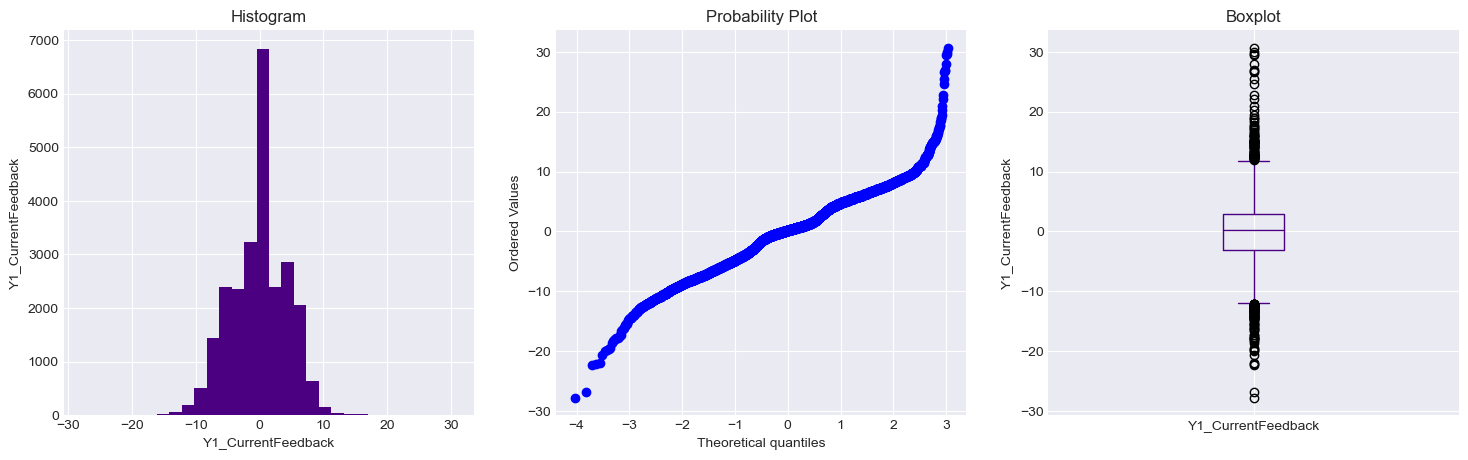

<Figure size 640x480 with 0 Axes>

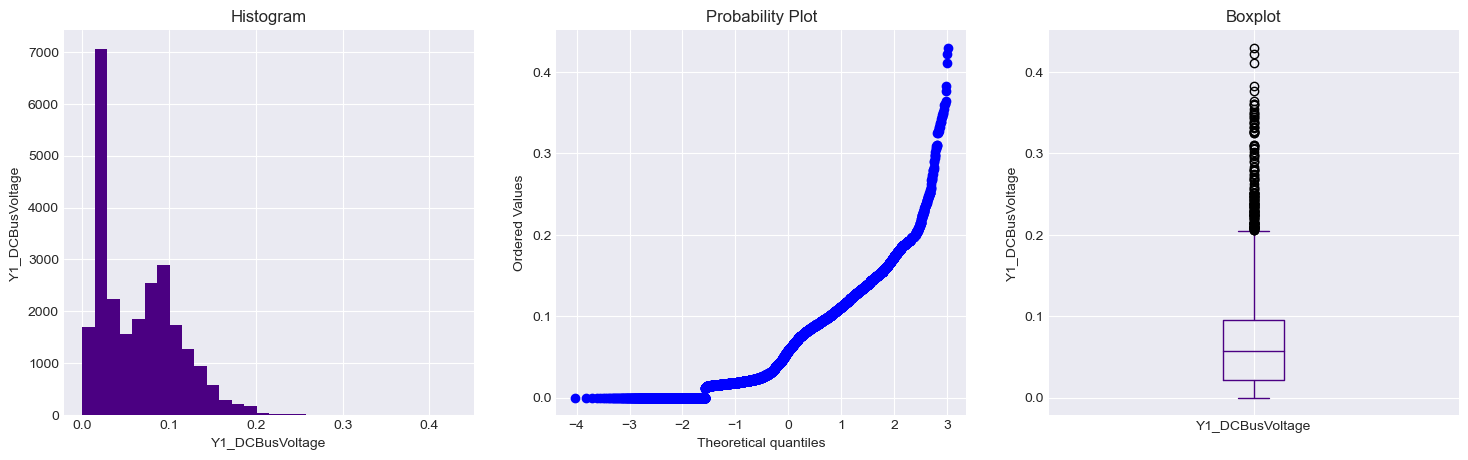

<Figure size 640x480 with 0 Axes>

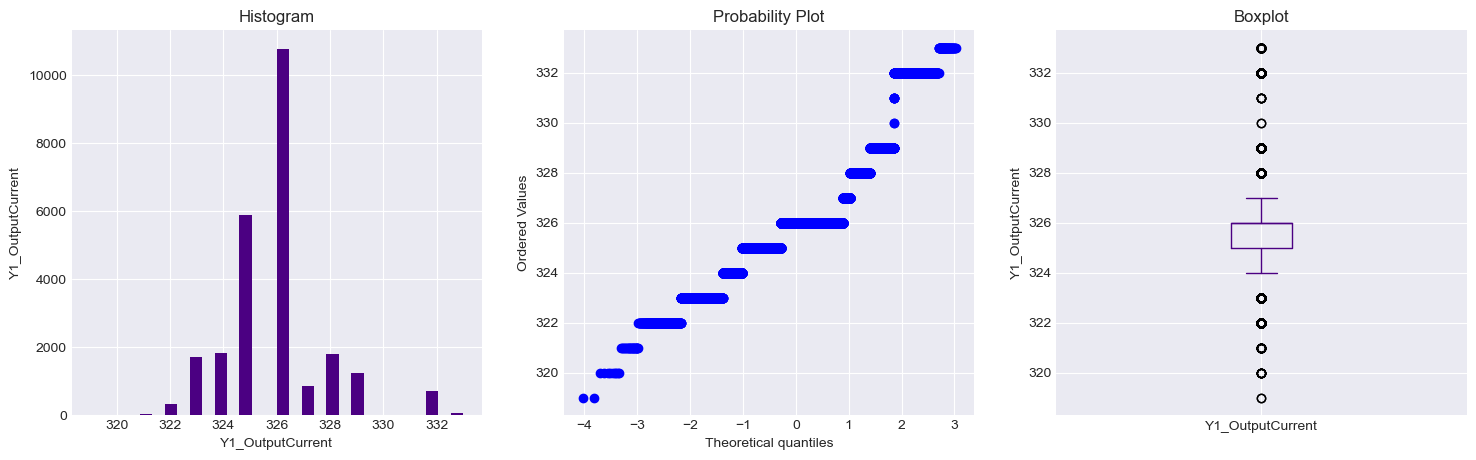

<Figure size 640x480 with 0 Axes>

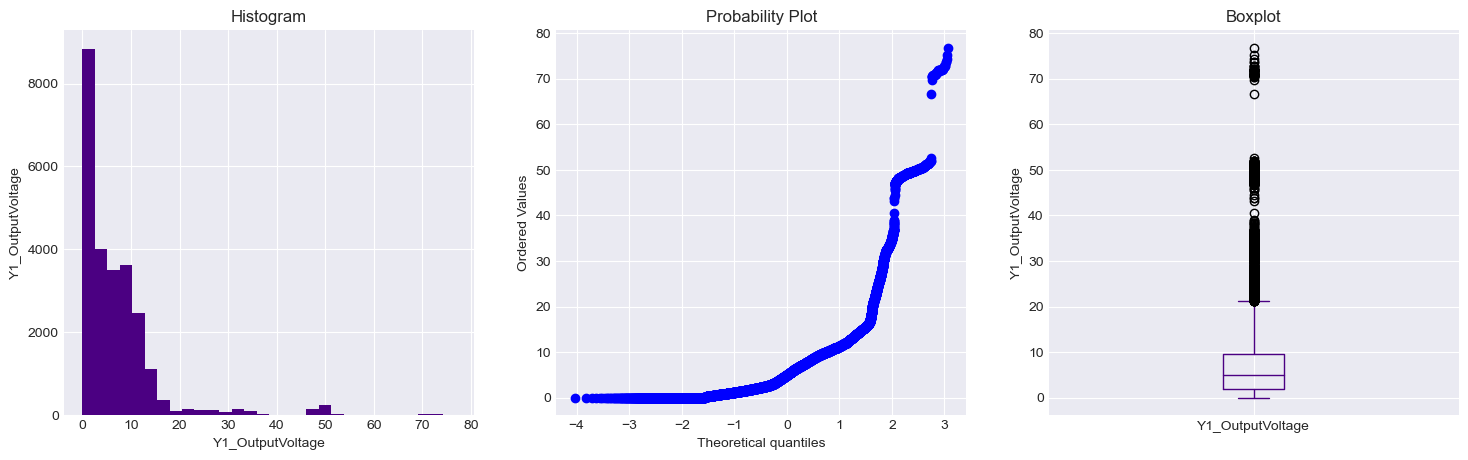

<Figure size 640x480 with 0 Axes>

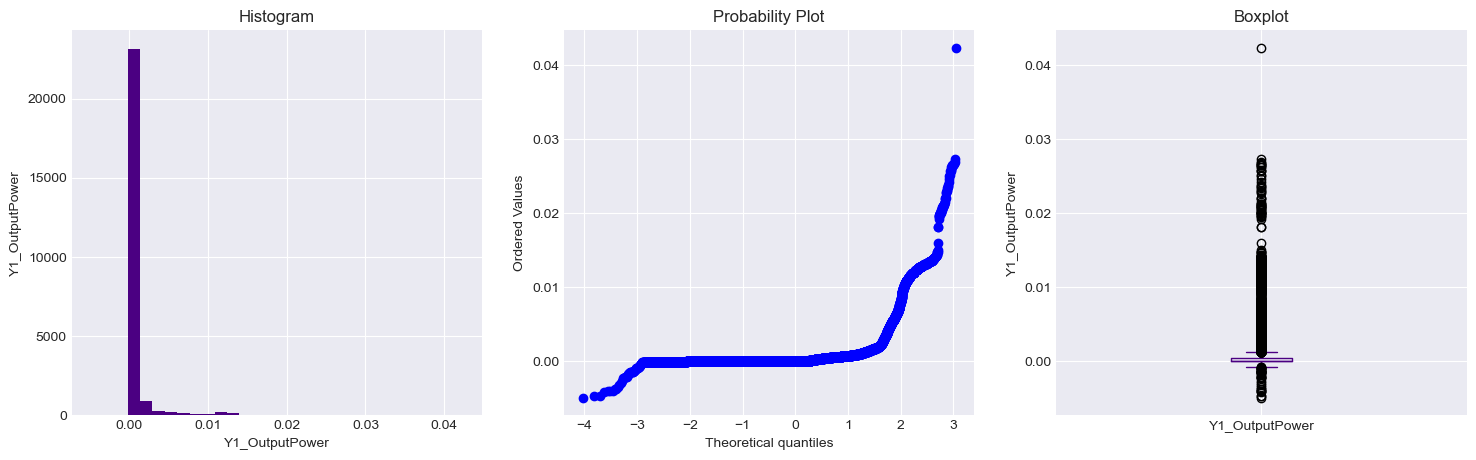

<Figure size 640x480 with 0 Axes>

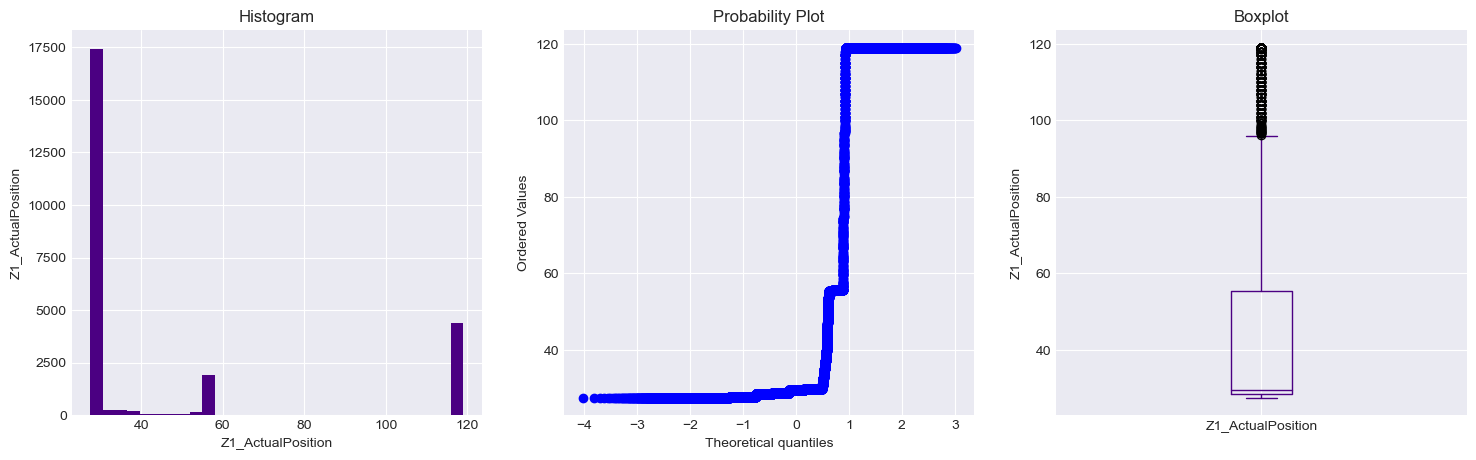

<Figure size 640x480 with 0 Axes>

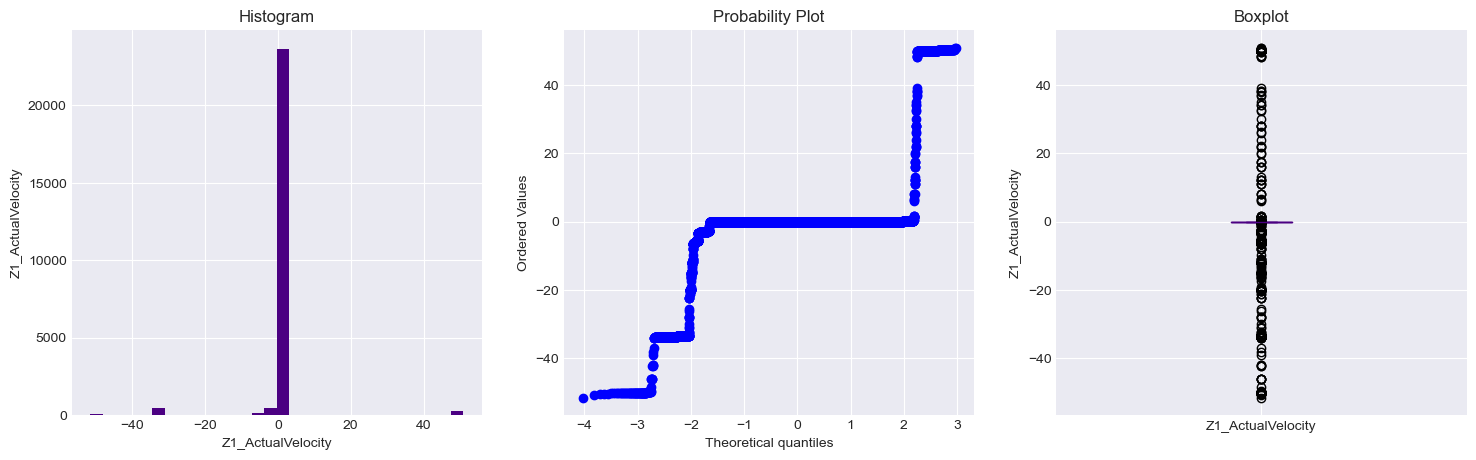

<Figure size 640x480 with 0 Axes>

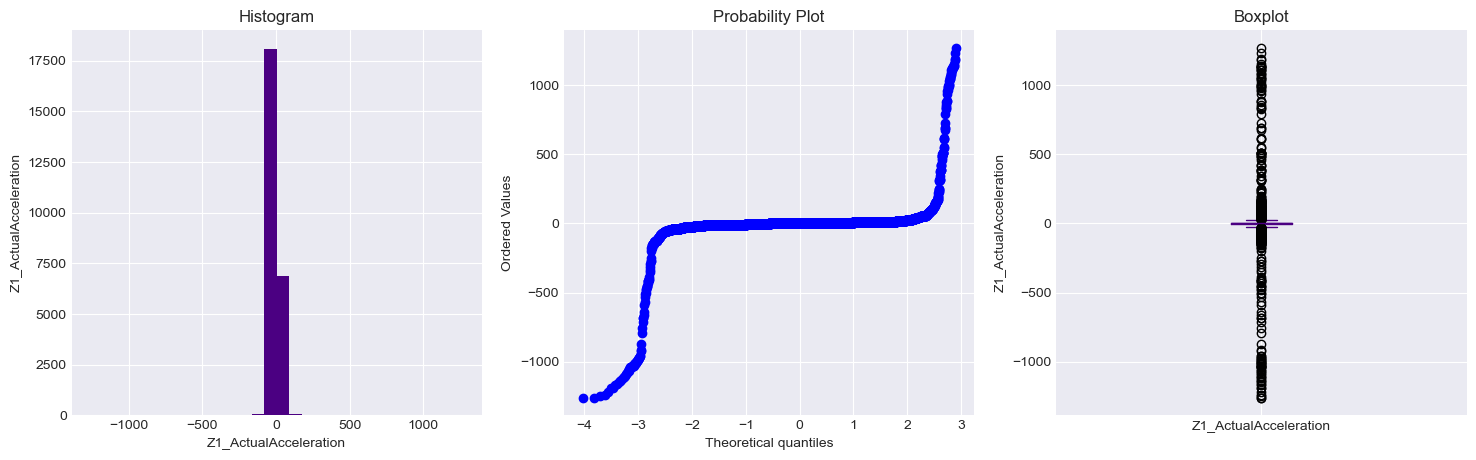

<Figure size 640x480 with 0 Axes>

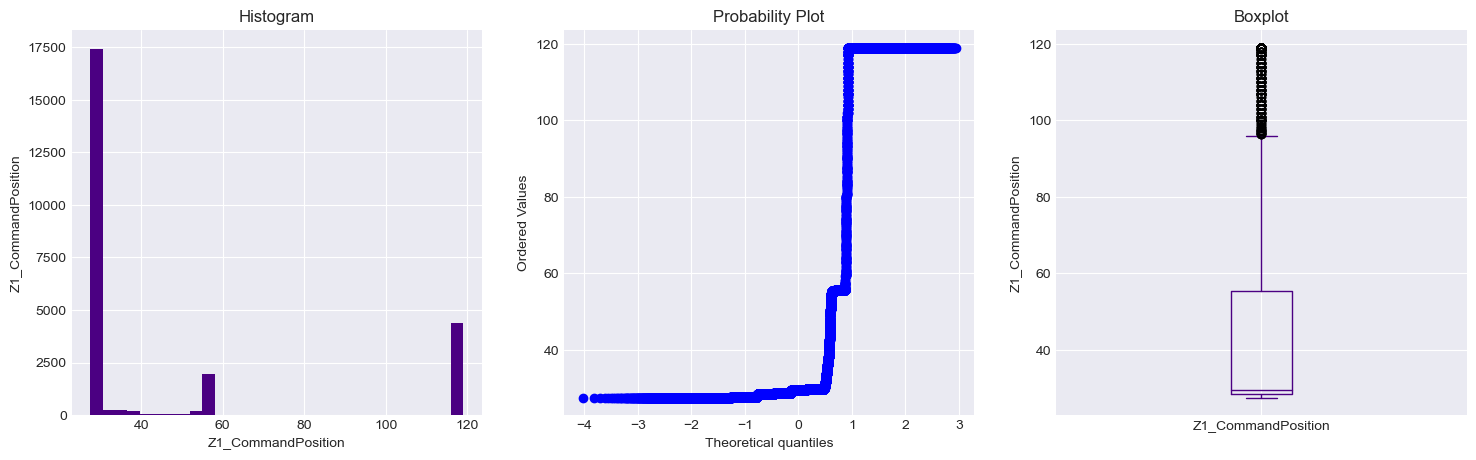

<Figure size 640x480 with 0 Axes>

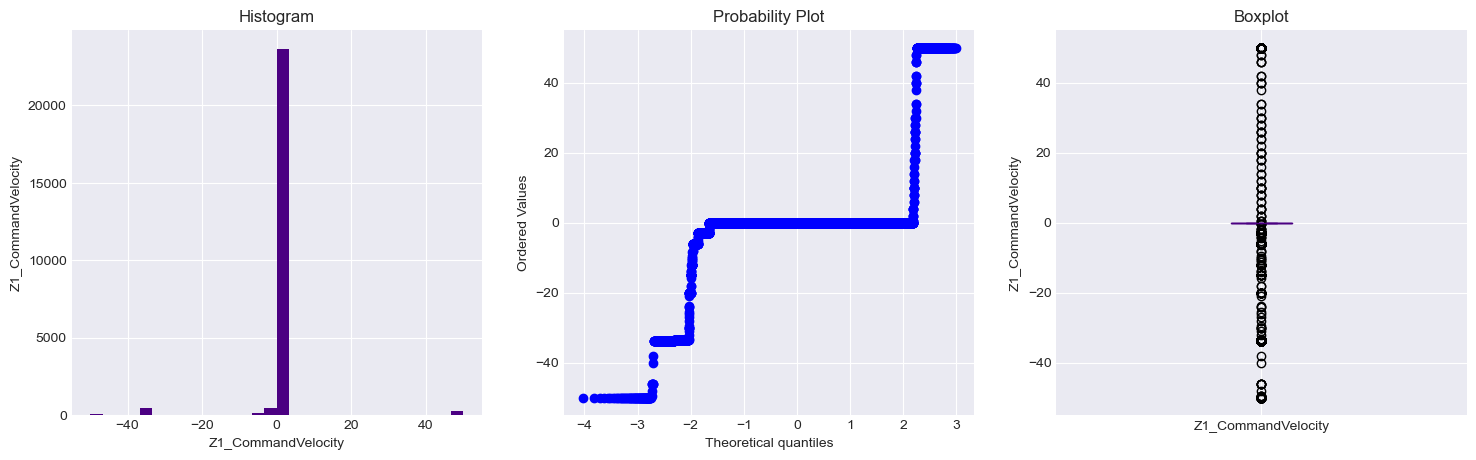

<Figure size 640x480 with 0 Axes>

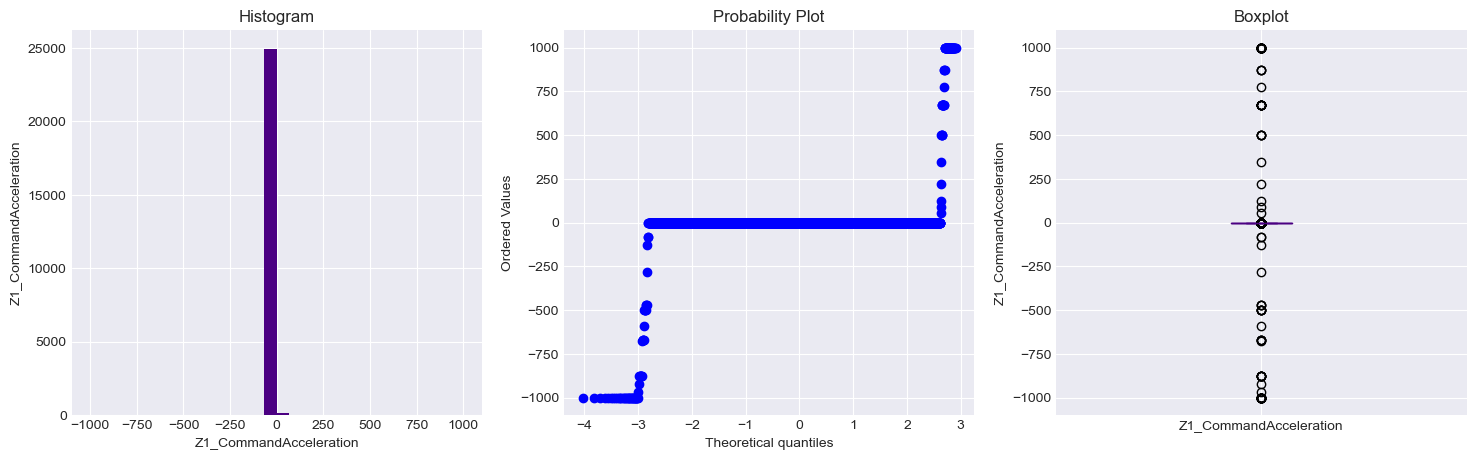

<Figure size 640x480 with 0 Axes>

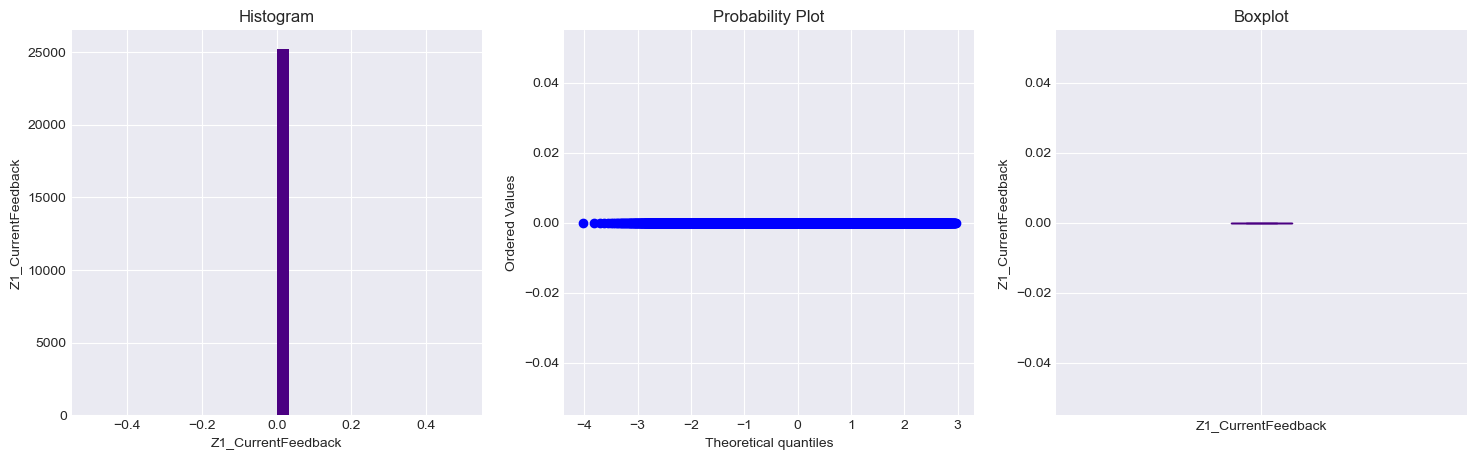

<Figure size 640x480 with 0 Axes>

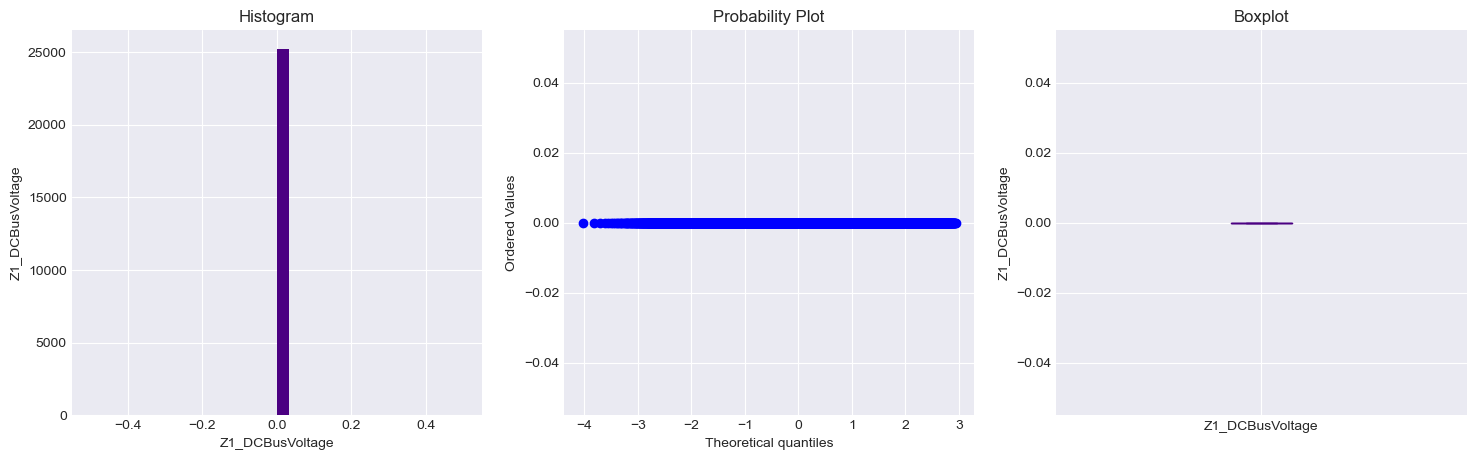

<Figure size 640x480 with 0 Axes>

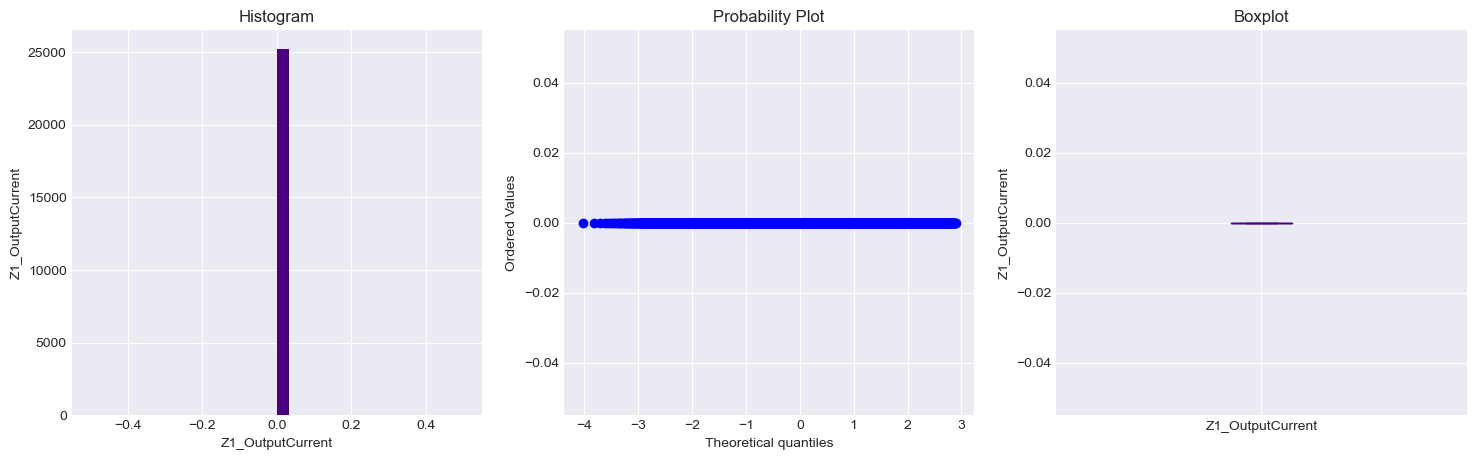

<Figure size 640x480 with 0 Axes>

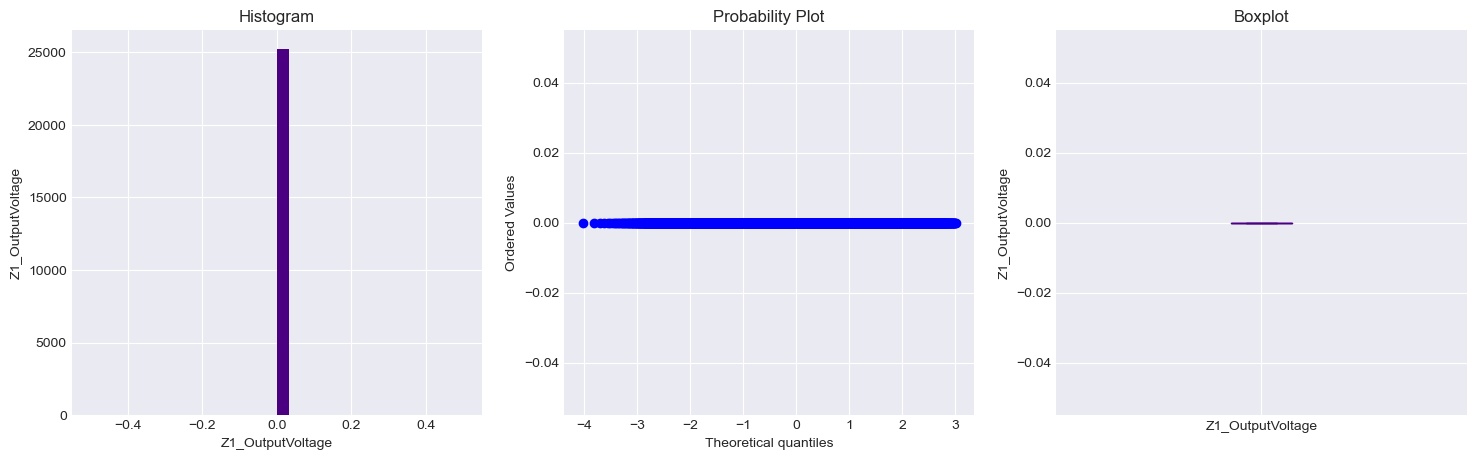

<Figure size 640x480 with 0 Axes>

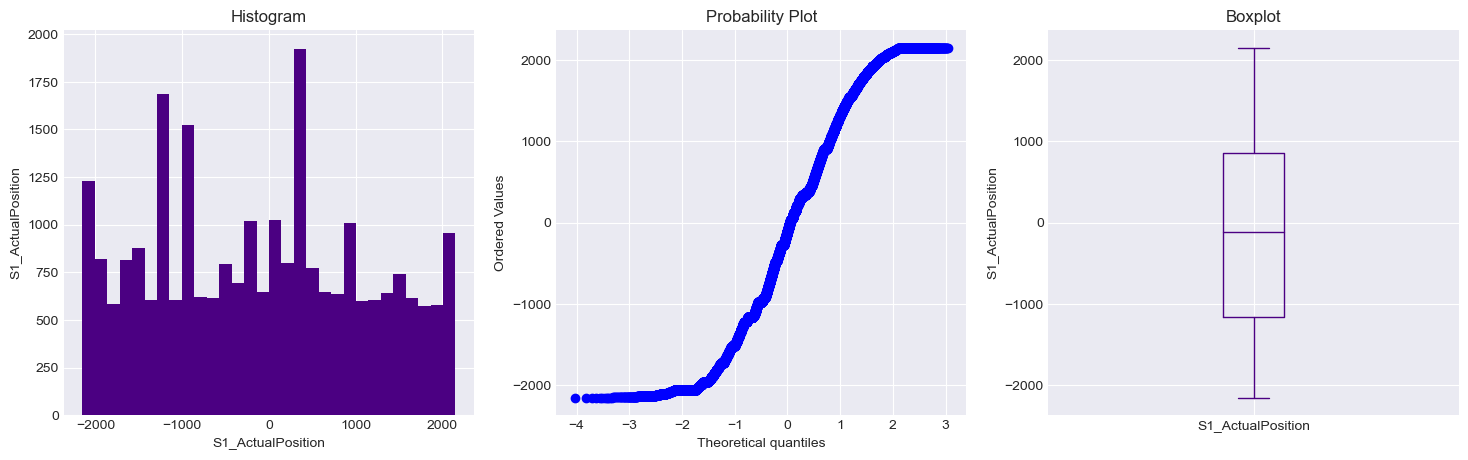

<Figure size 640x480 with 0 Axes>

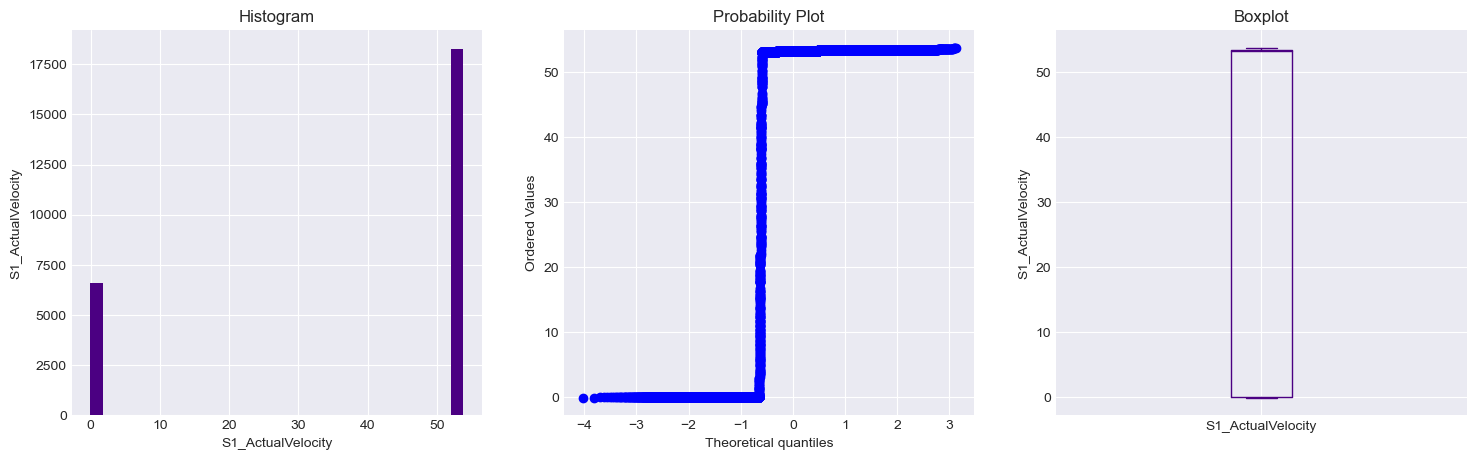

<Figure size 640x480 with 0 Axes>

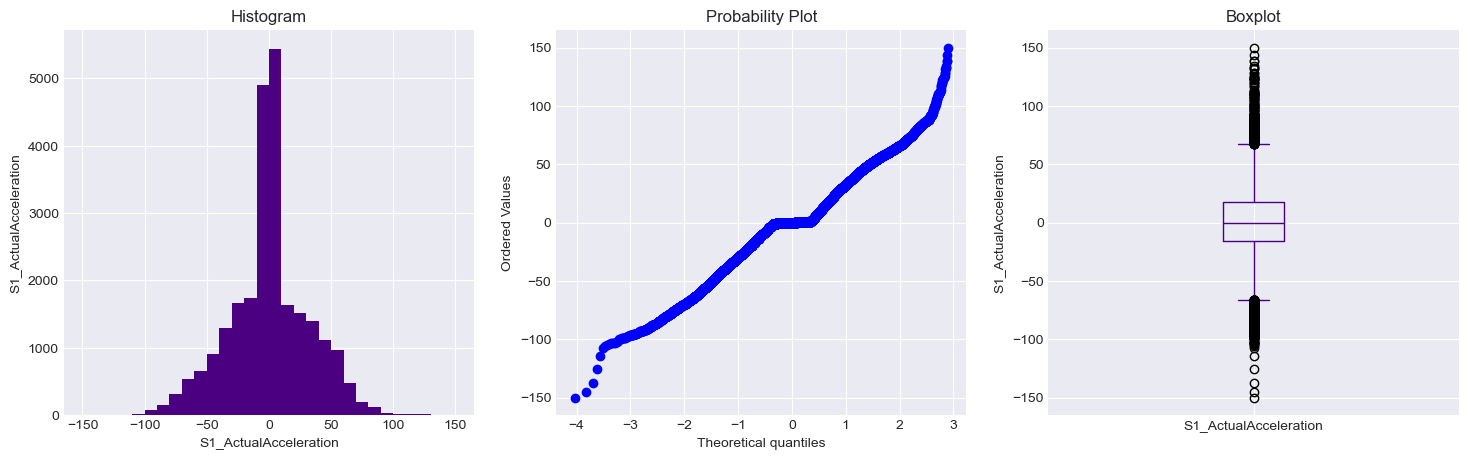

<Figure size 640x480 with 0 Axes>

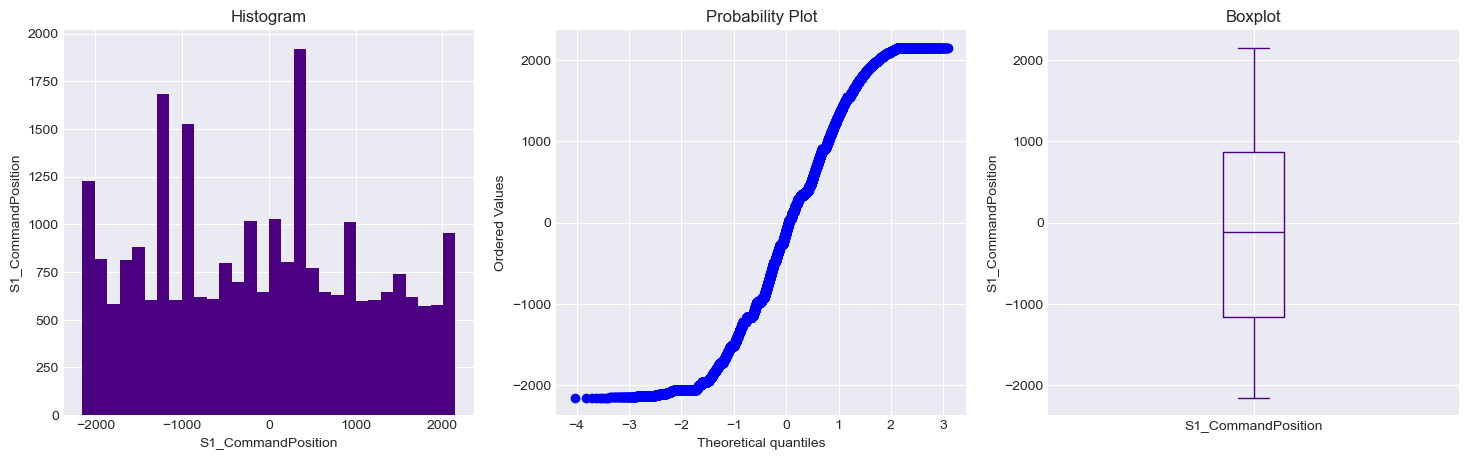

<Figure size 640x480 with 0 Axes>

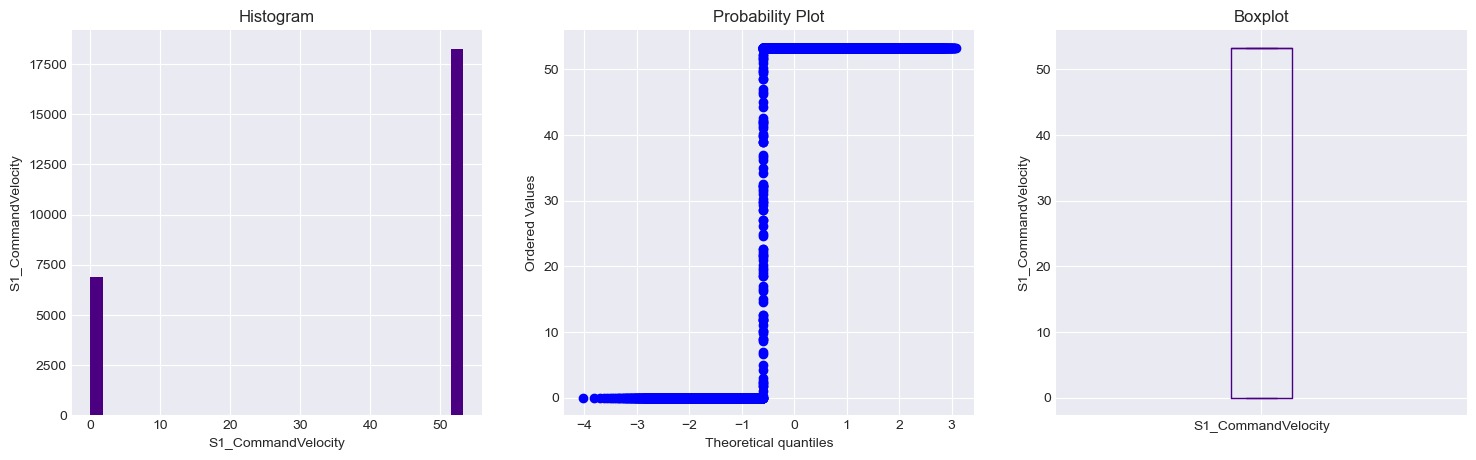

<Figure size 640x480 with 0 Axes>

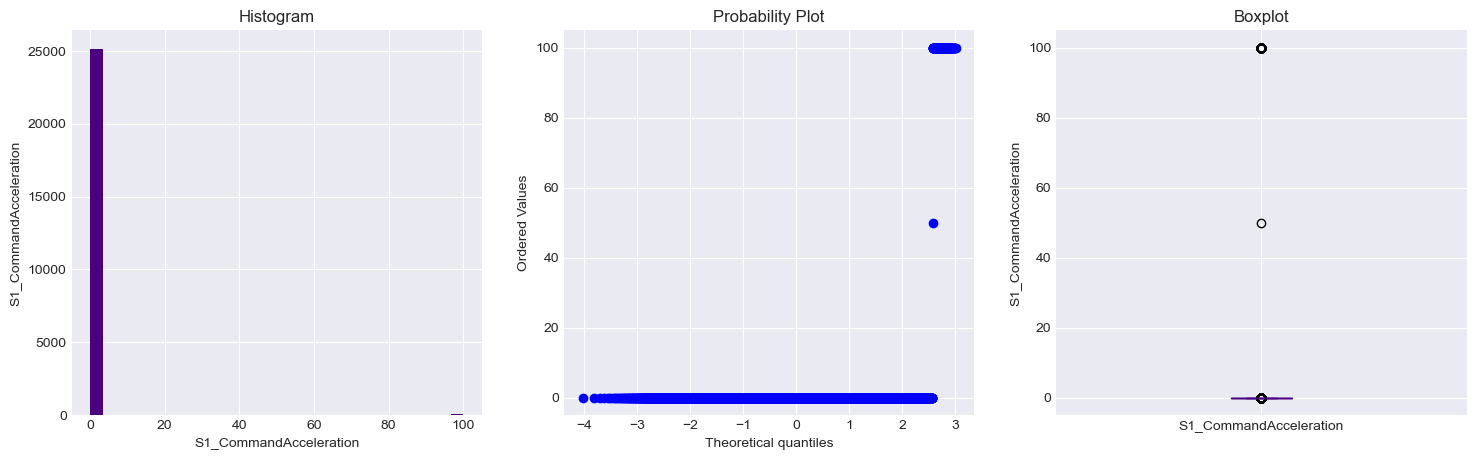

<Figure size 640x480 with 0 Axes>

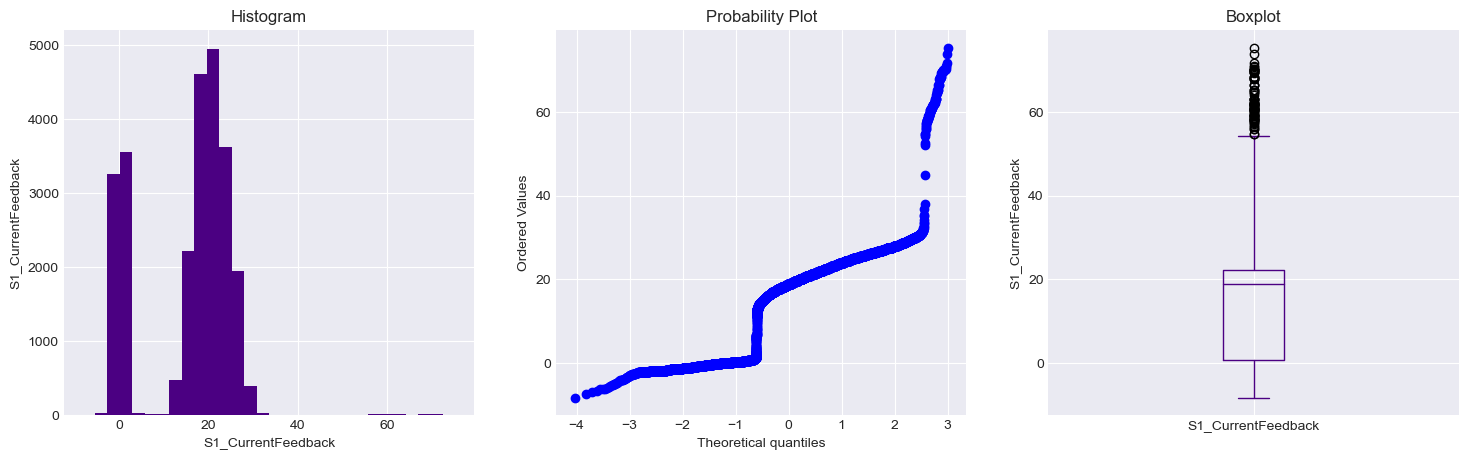

<Figure size 640x480 with 0 Axes>

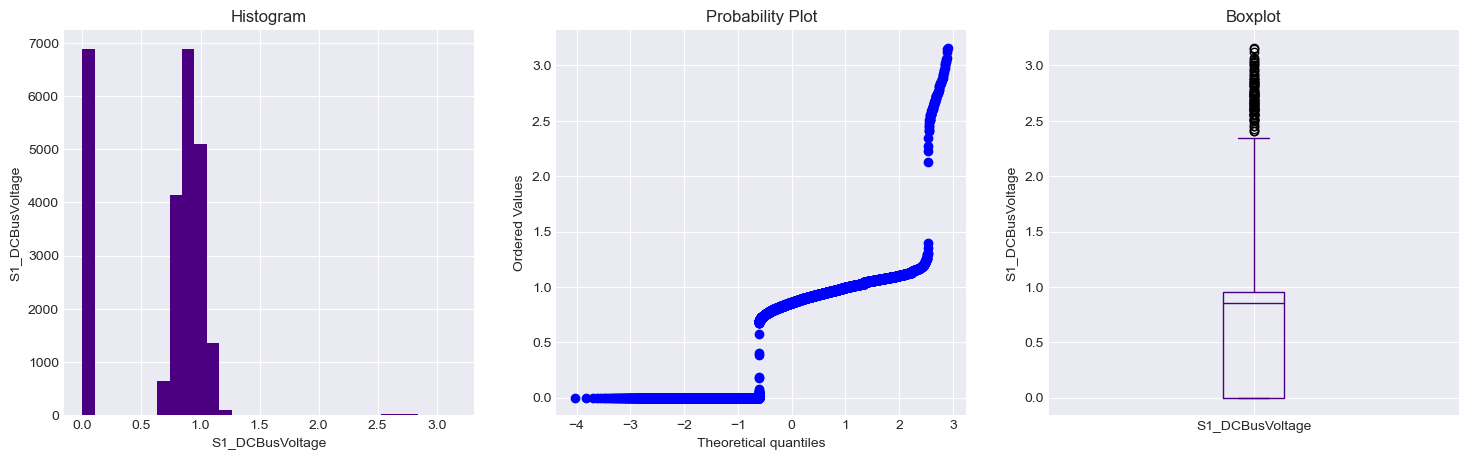

<Figure size 640x480 with 0 Axes>

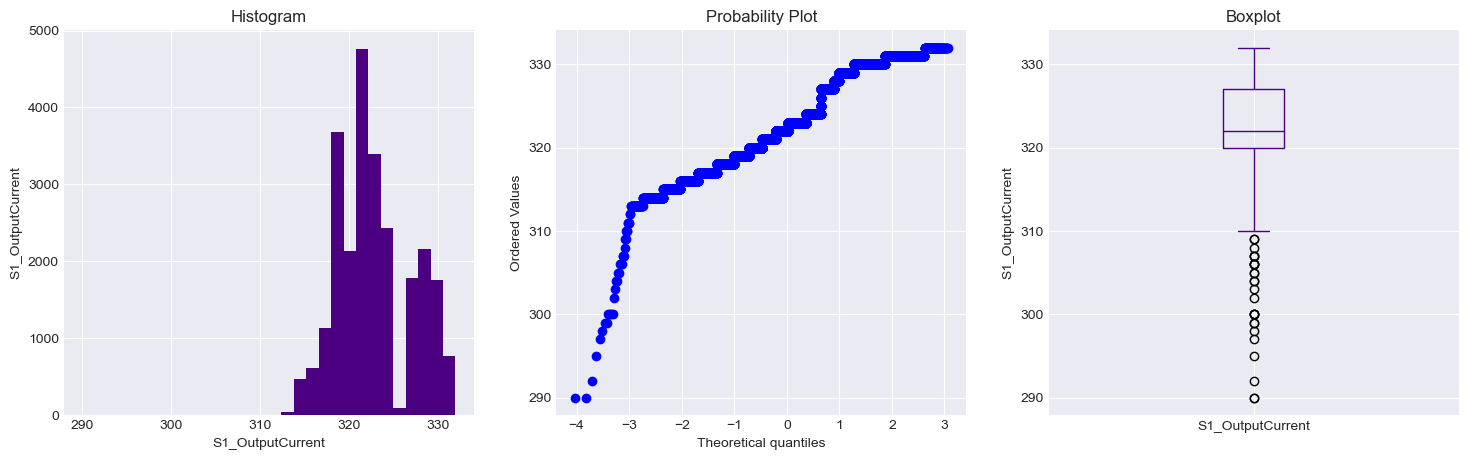

<Figure size 640x480 with 0 Axes>

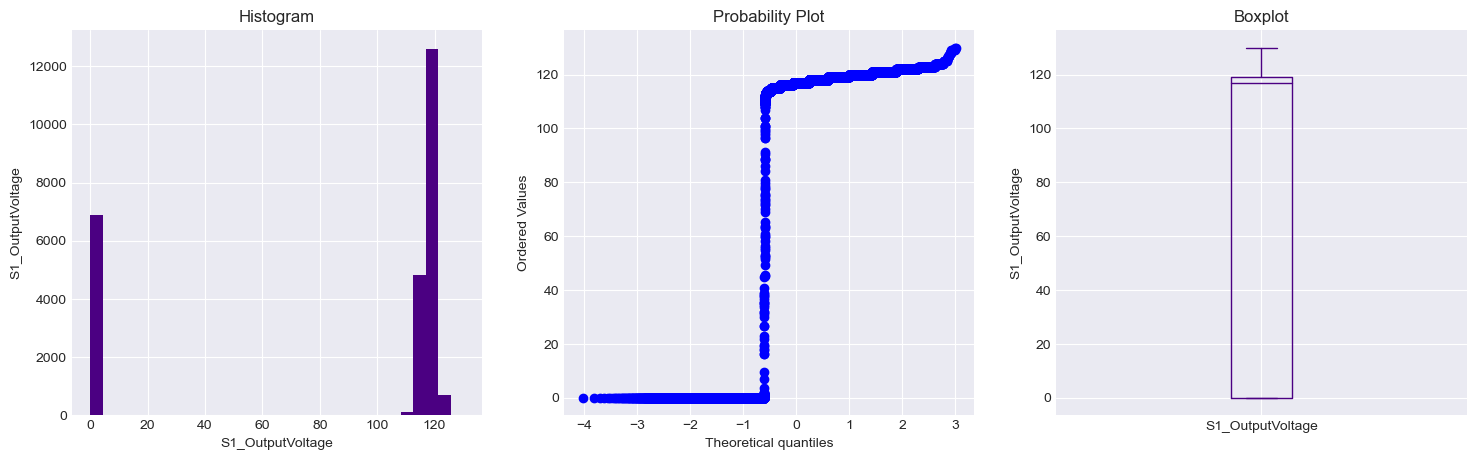

<Figure size 640x480 with 0 Axes>

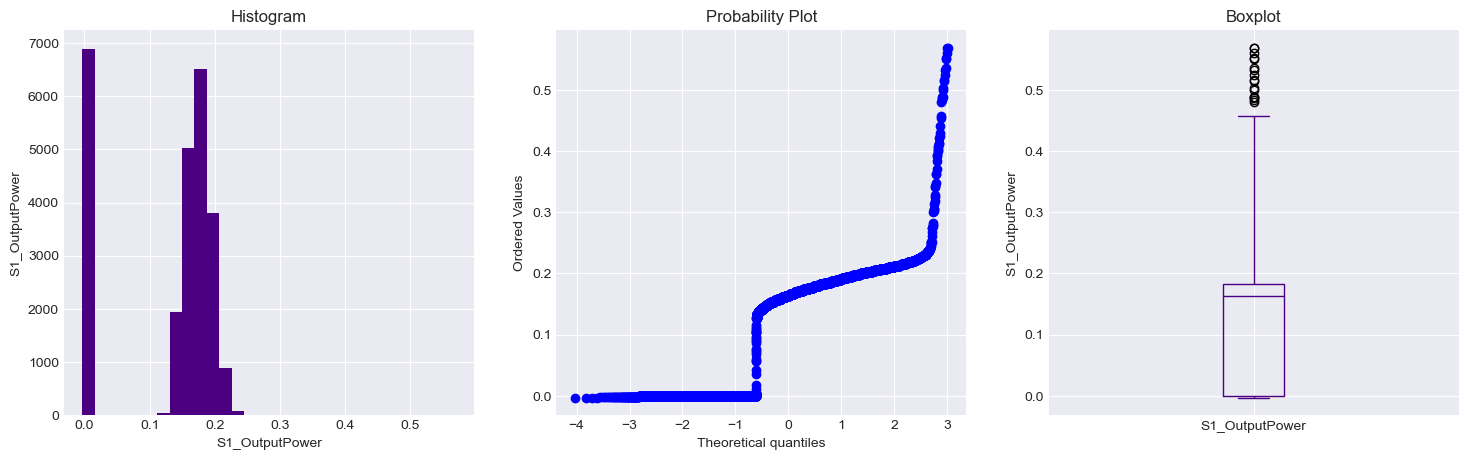

<Figure size 640x480 with 0 Axes>

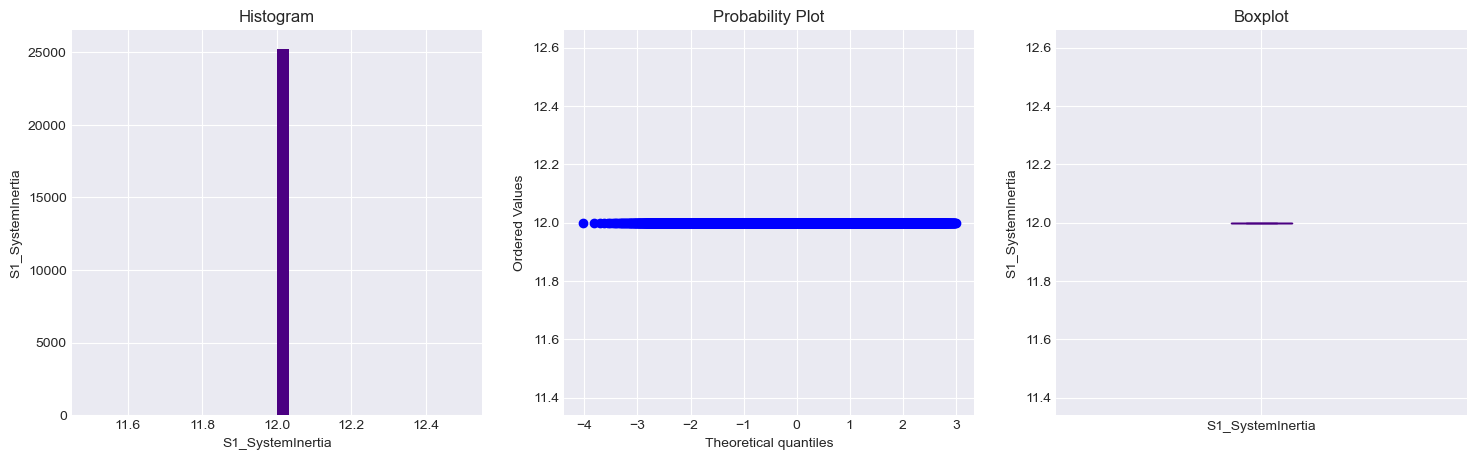

<Figure size 640x480 with 0 Axes>

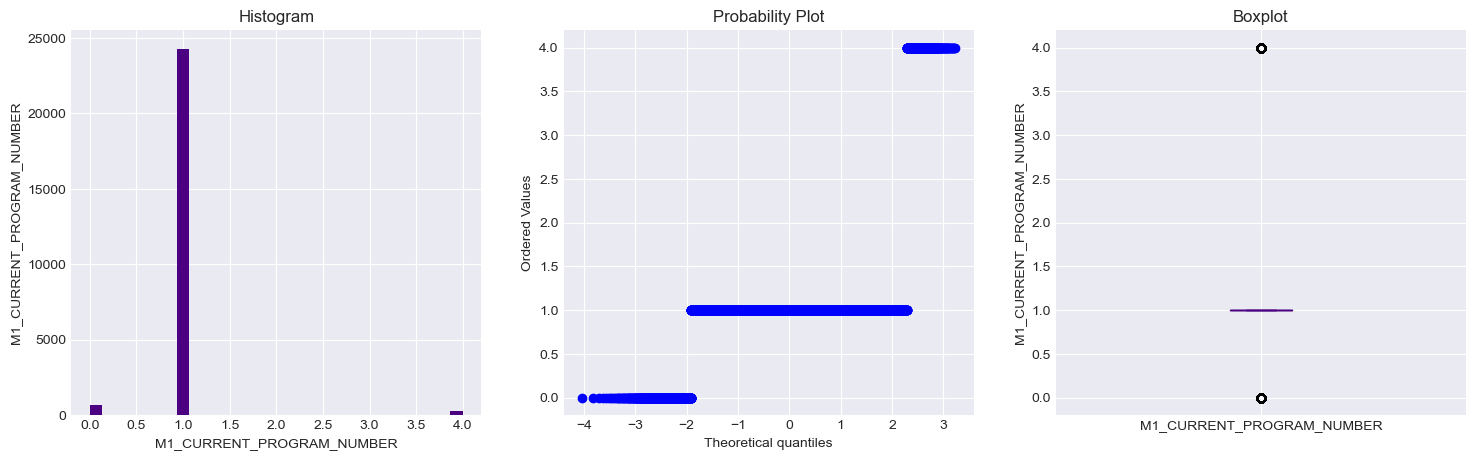

<Figure size 640x480 with 0 Axes>

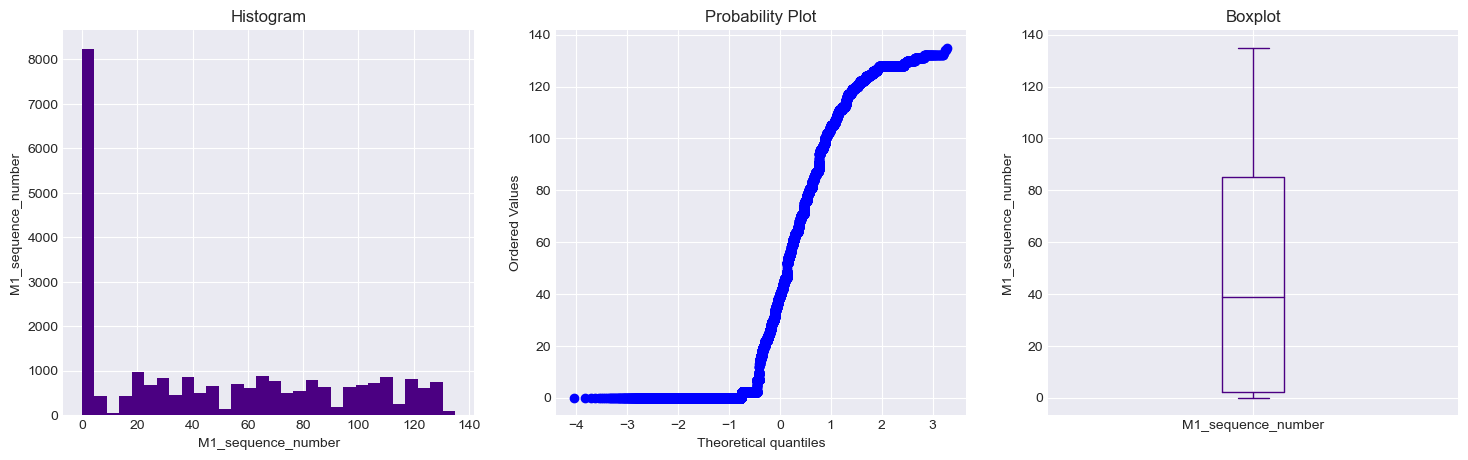

<Figure size 640x480 with 0 Axes>

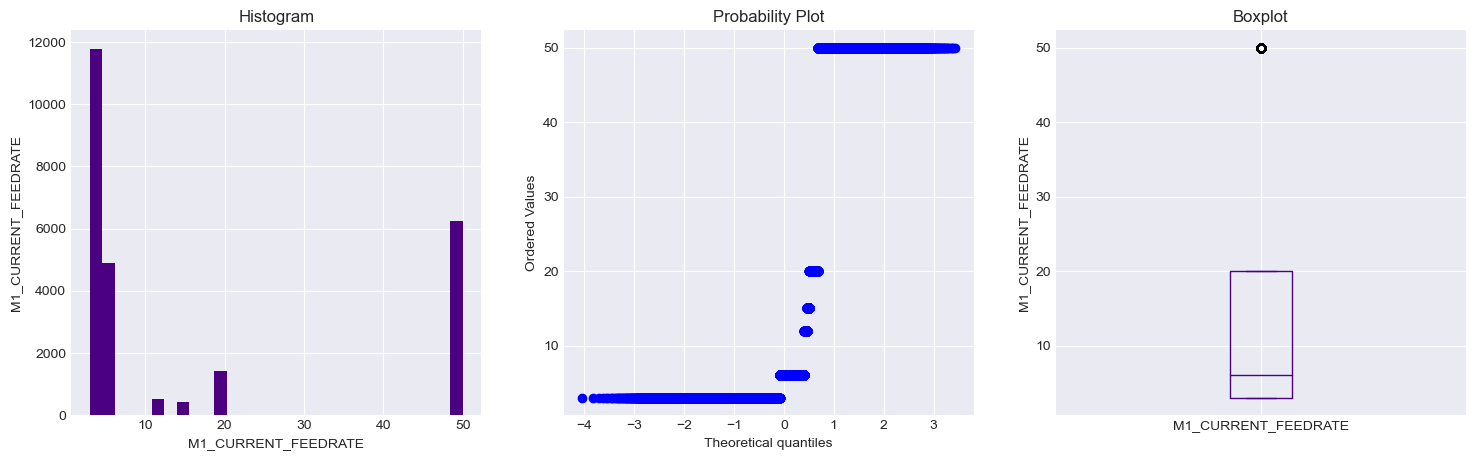

<Figure size 640x480 with 0 Axes>

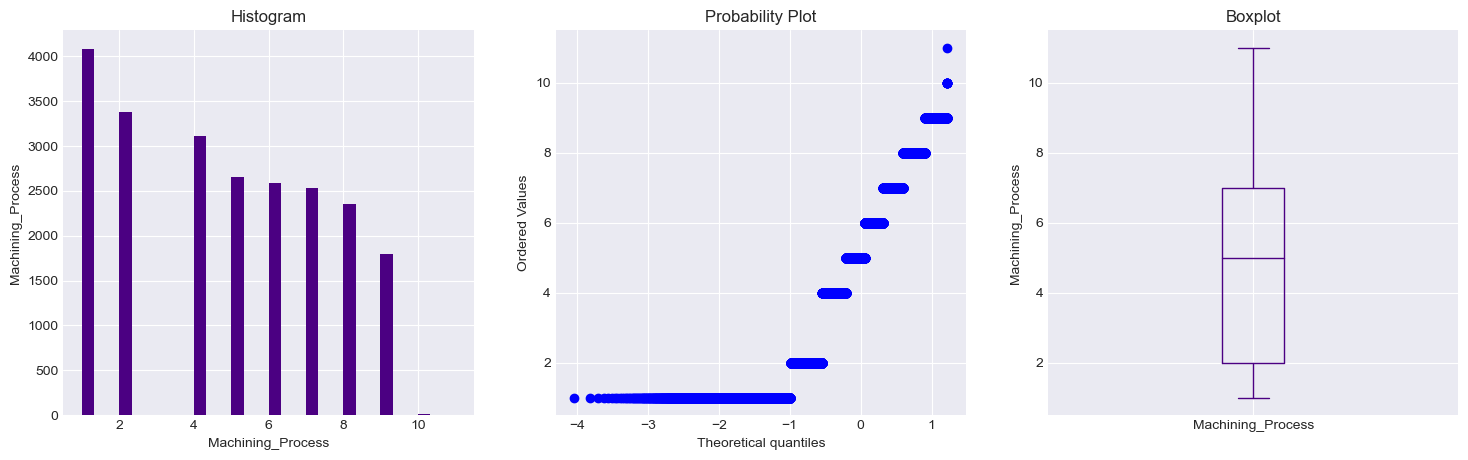

<Figure size 640x480 with 0 Axes>

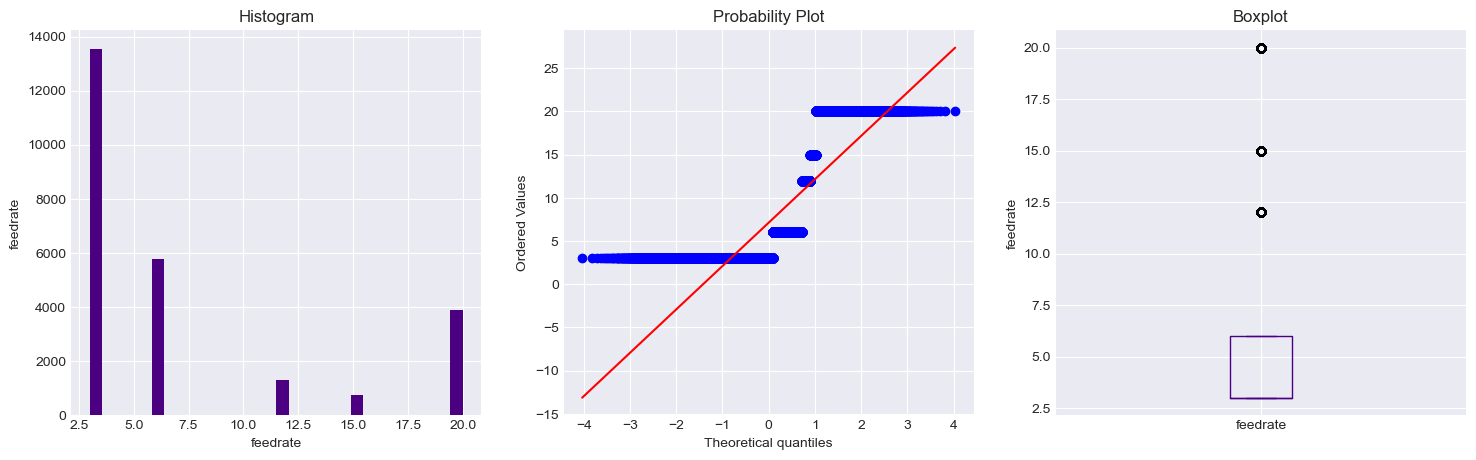

<Figure size 640x480 with 0 Axes>

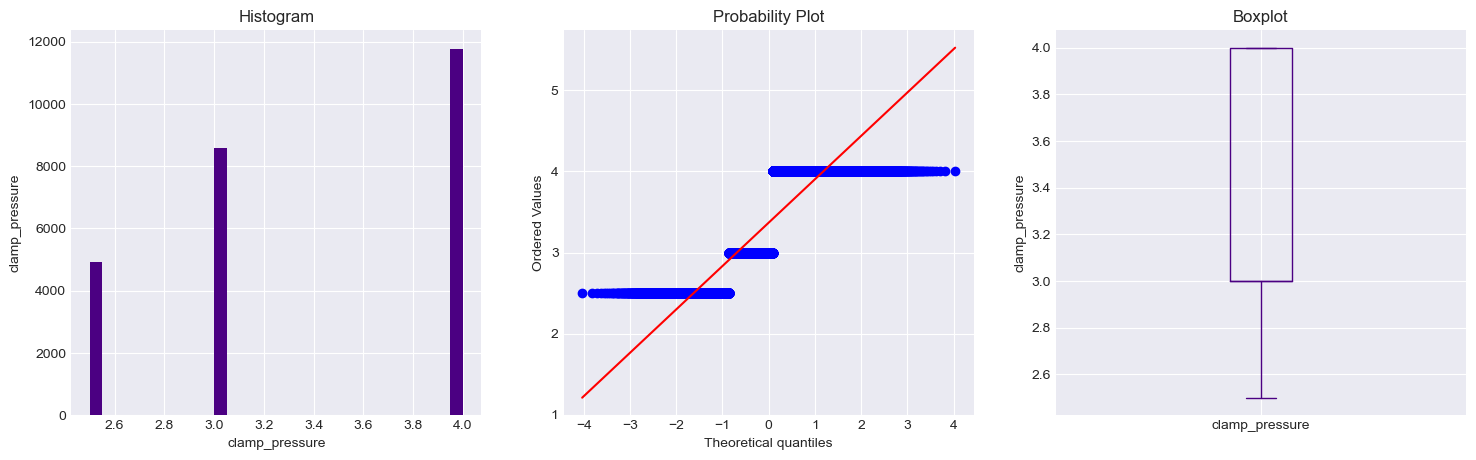

<Figure size 640x480 with 0 Axes>

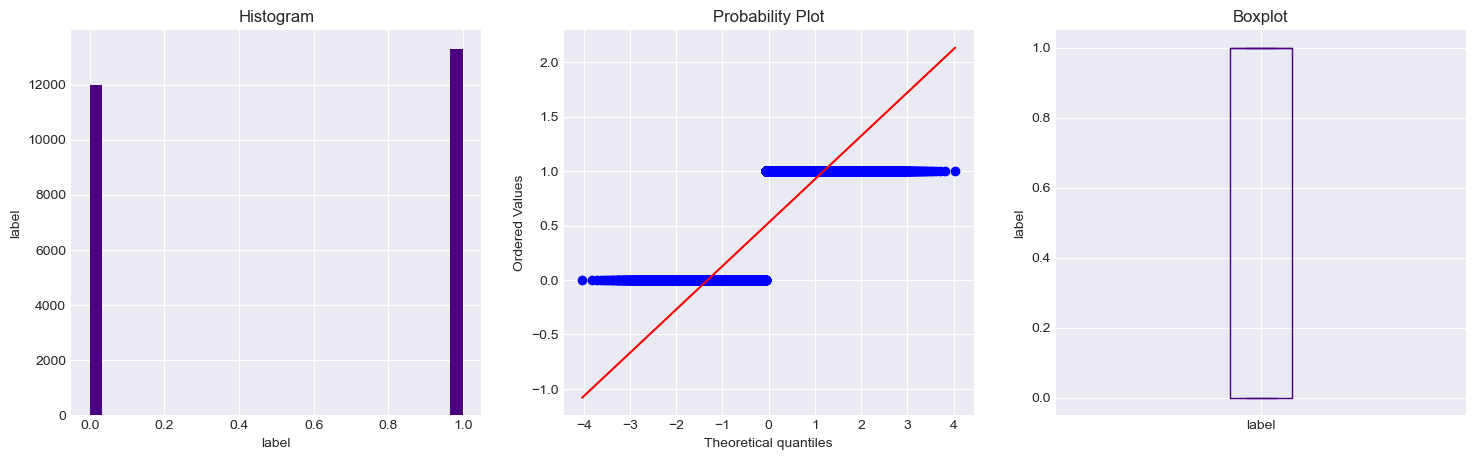

In [13]:
# let's see diagnostic plots
for var in data:
    diagnostic_plots(data, var)

We can see that the distribution of variables is skewed, with outliers and no linearity.

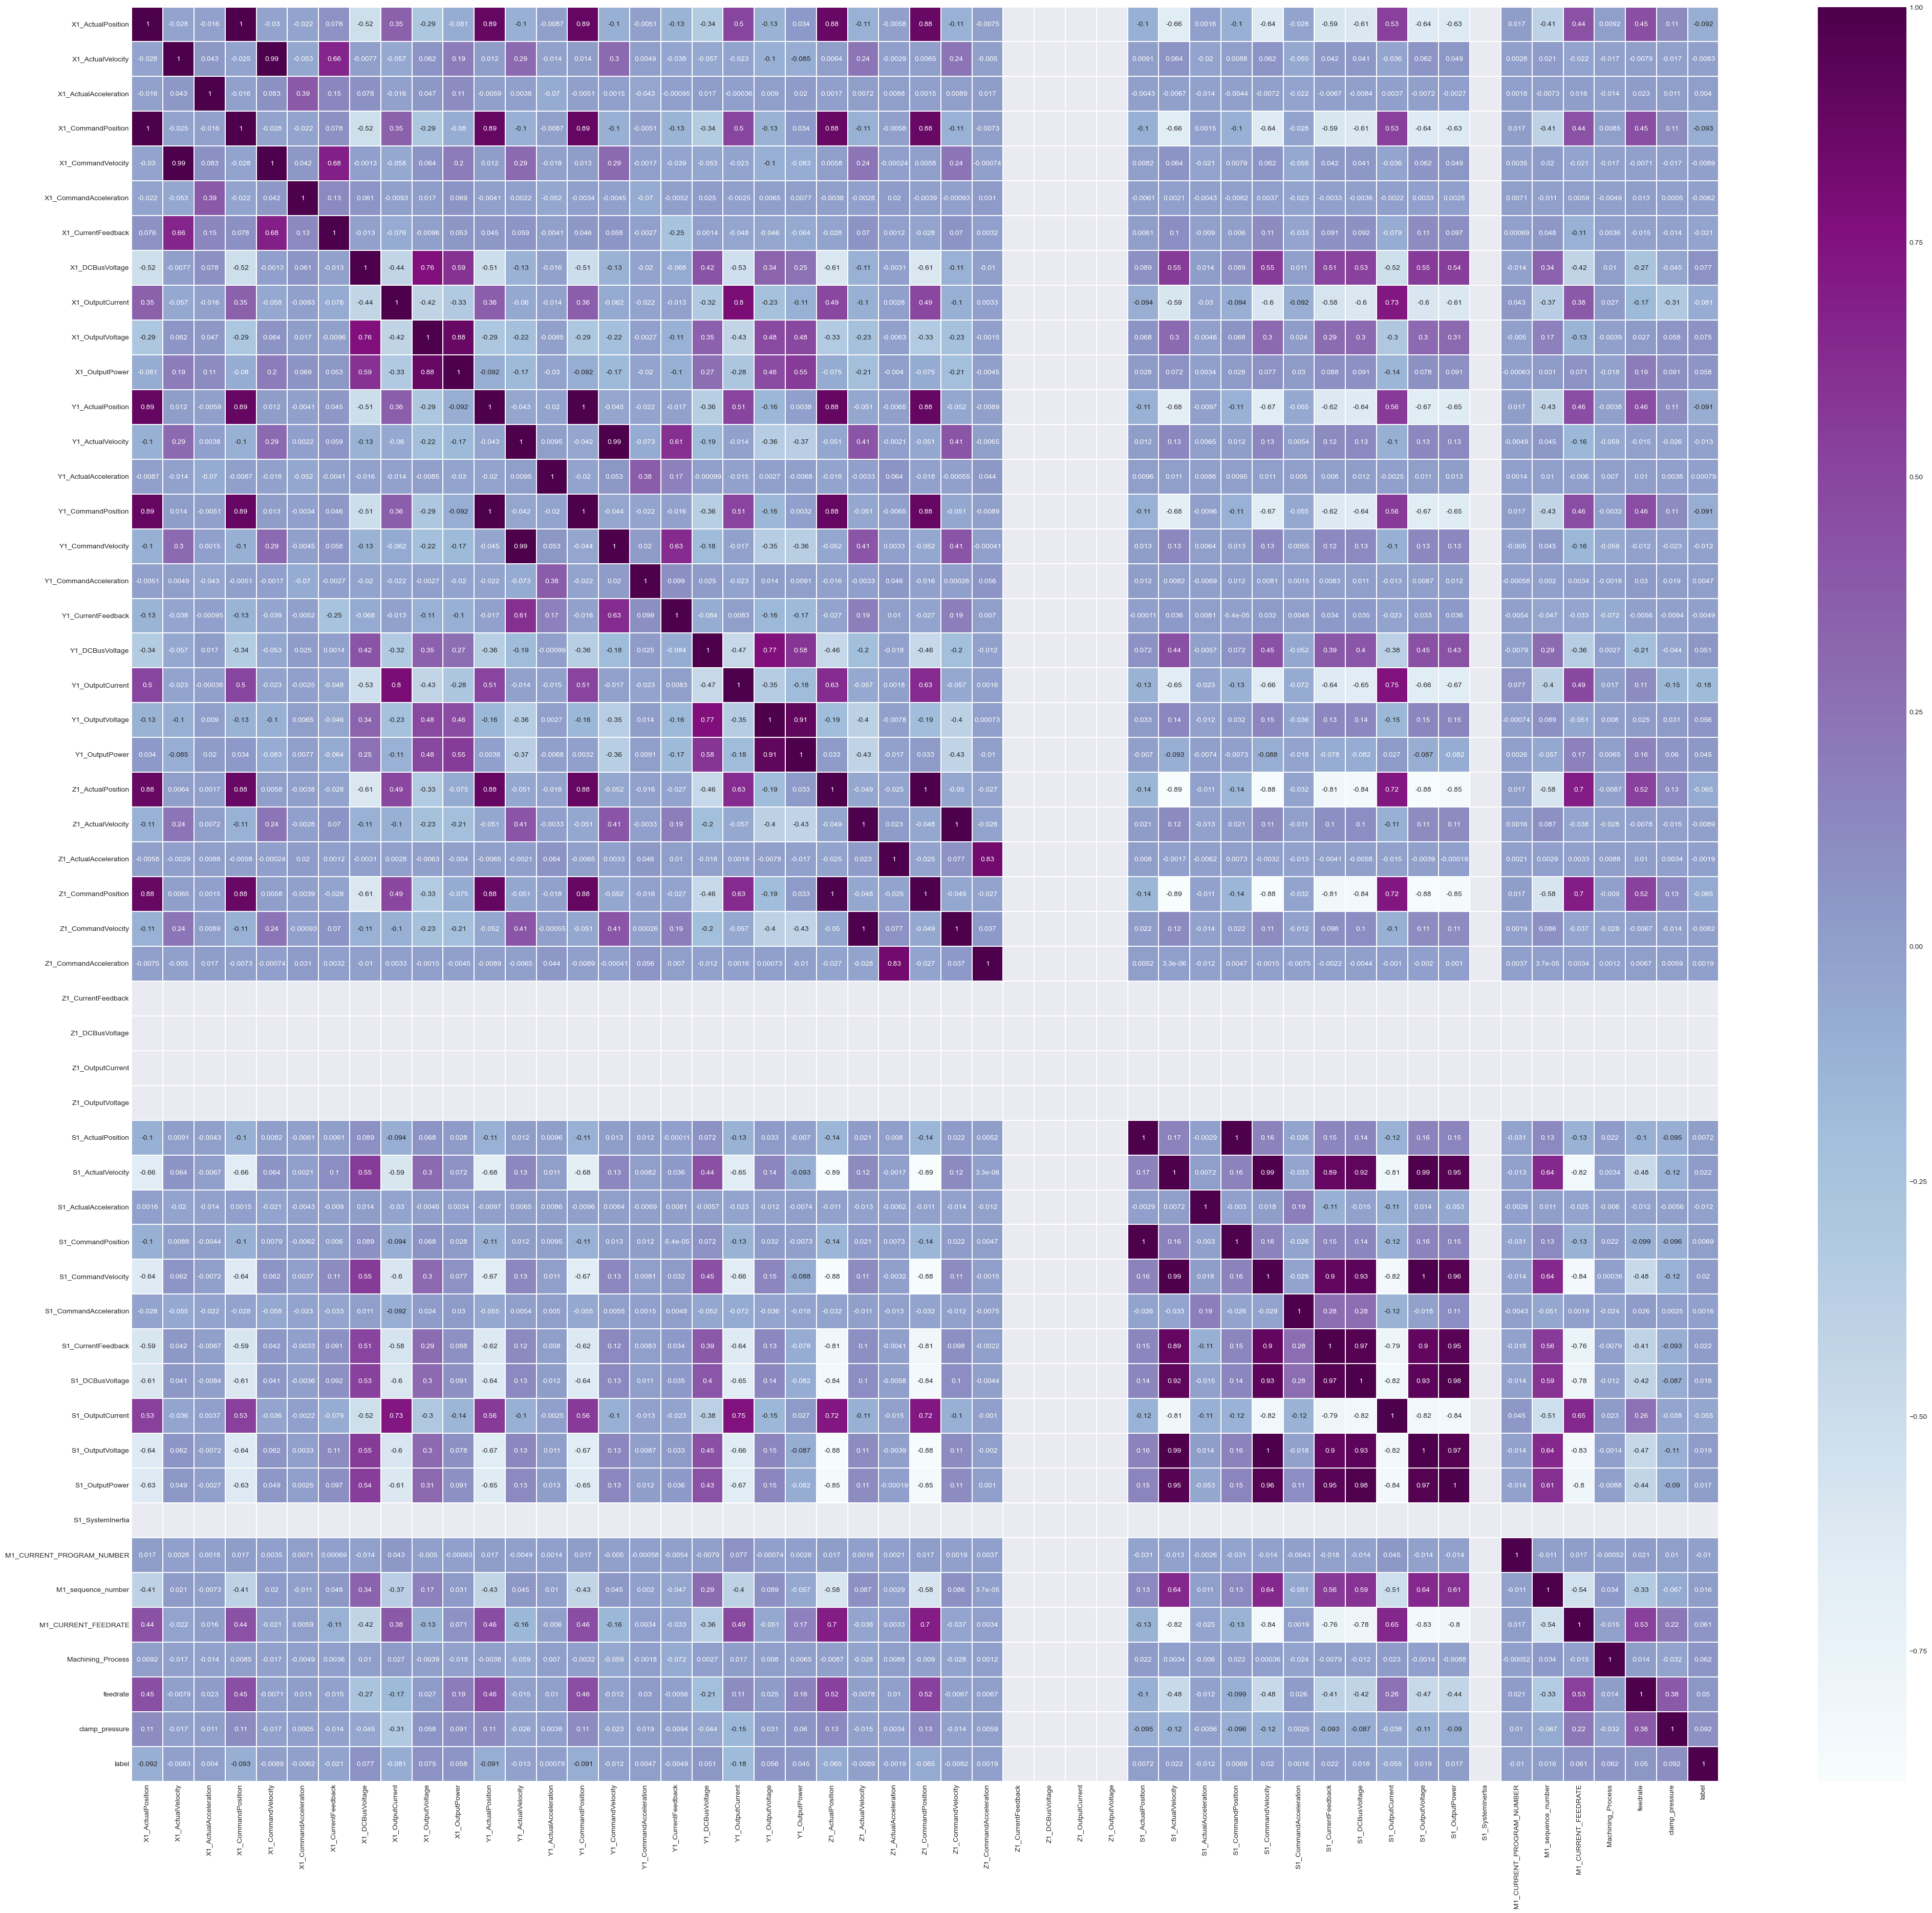

In [14]:
# correlation matrix
plt.figure(figsize=(50,45))
sns.heatmap(data.corr(),linewidths=.1,annot=True, cmap='BuPu')
plt.show()

Looking at the correlation matrix, there are empty variables in the data.

In [15]:
# remove empty variables
data.drop(['Z1_CurrentFeedback',
           'Z1_DCBusVoltage',
           'Z1_OutputCurrent',
           'Z1_OutputVoltage',
           'S1_SystemInertia'],
    axis = 1,
    inplace=True)

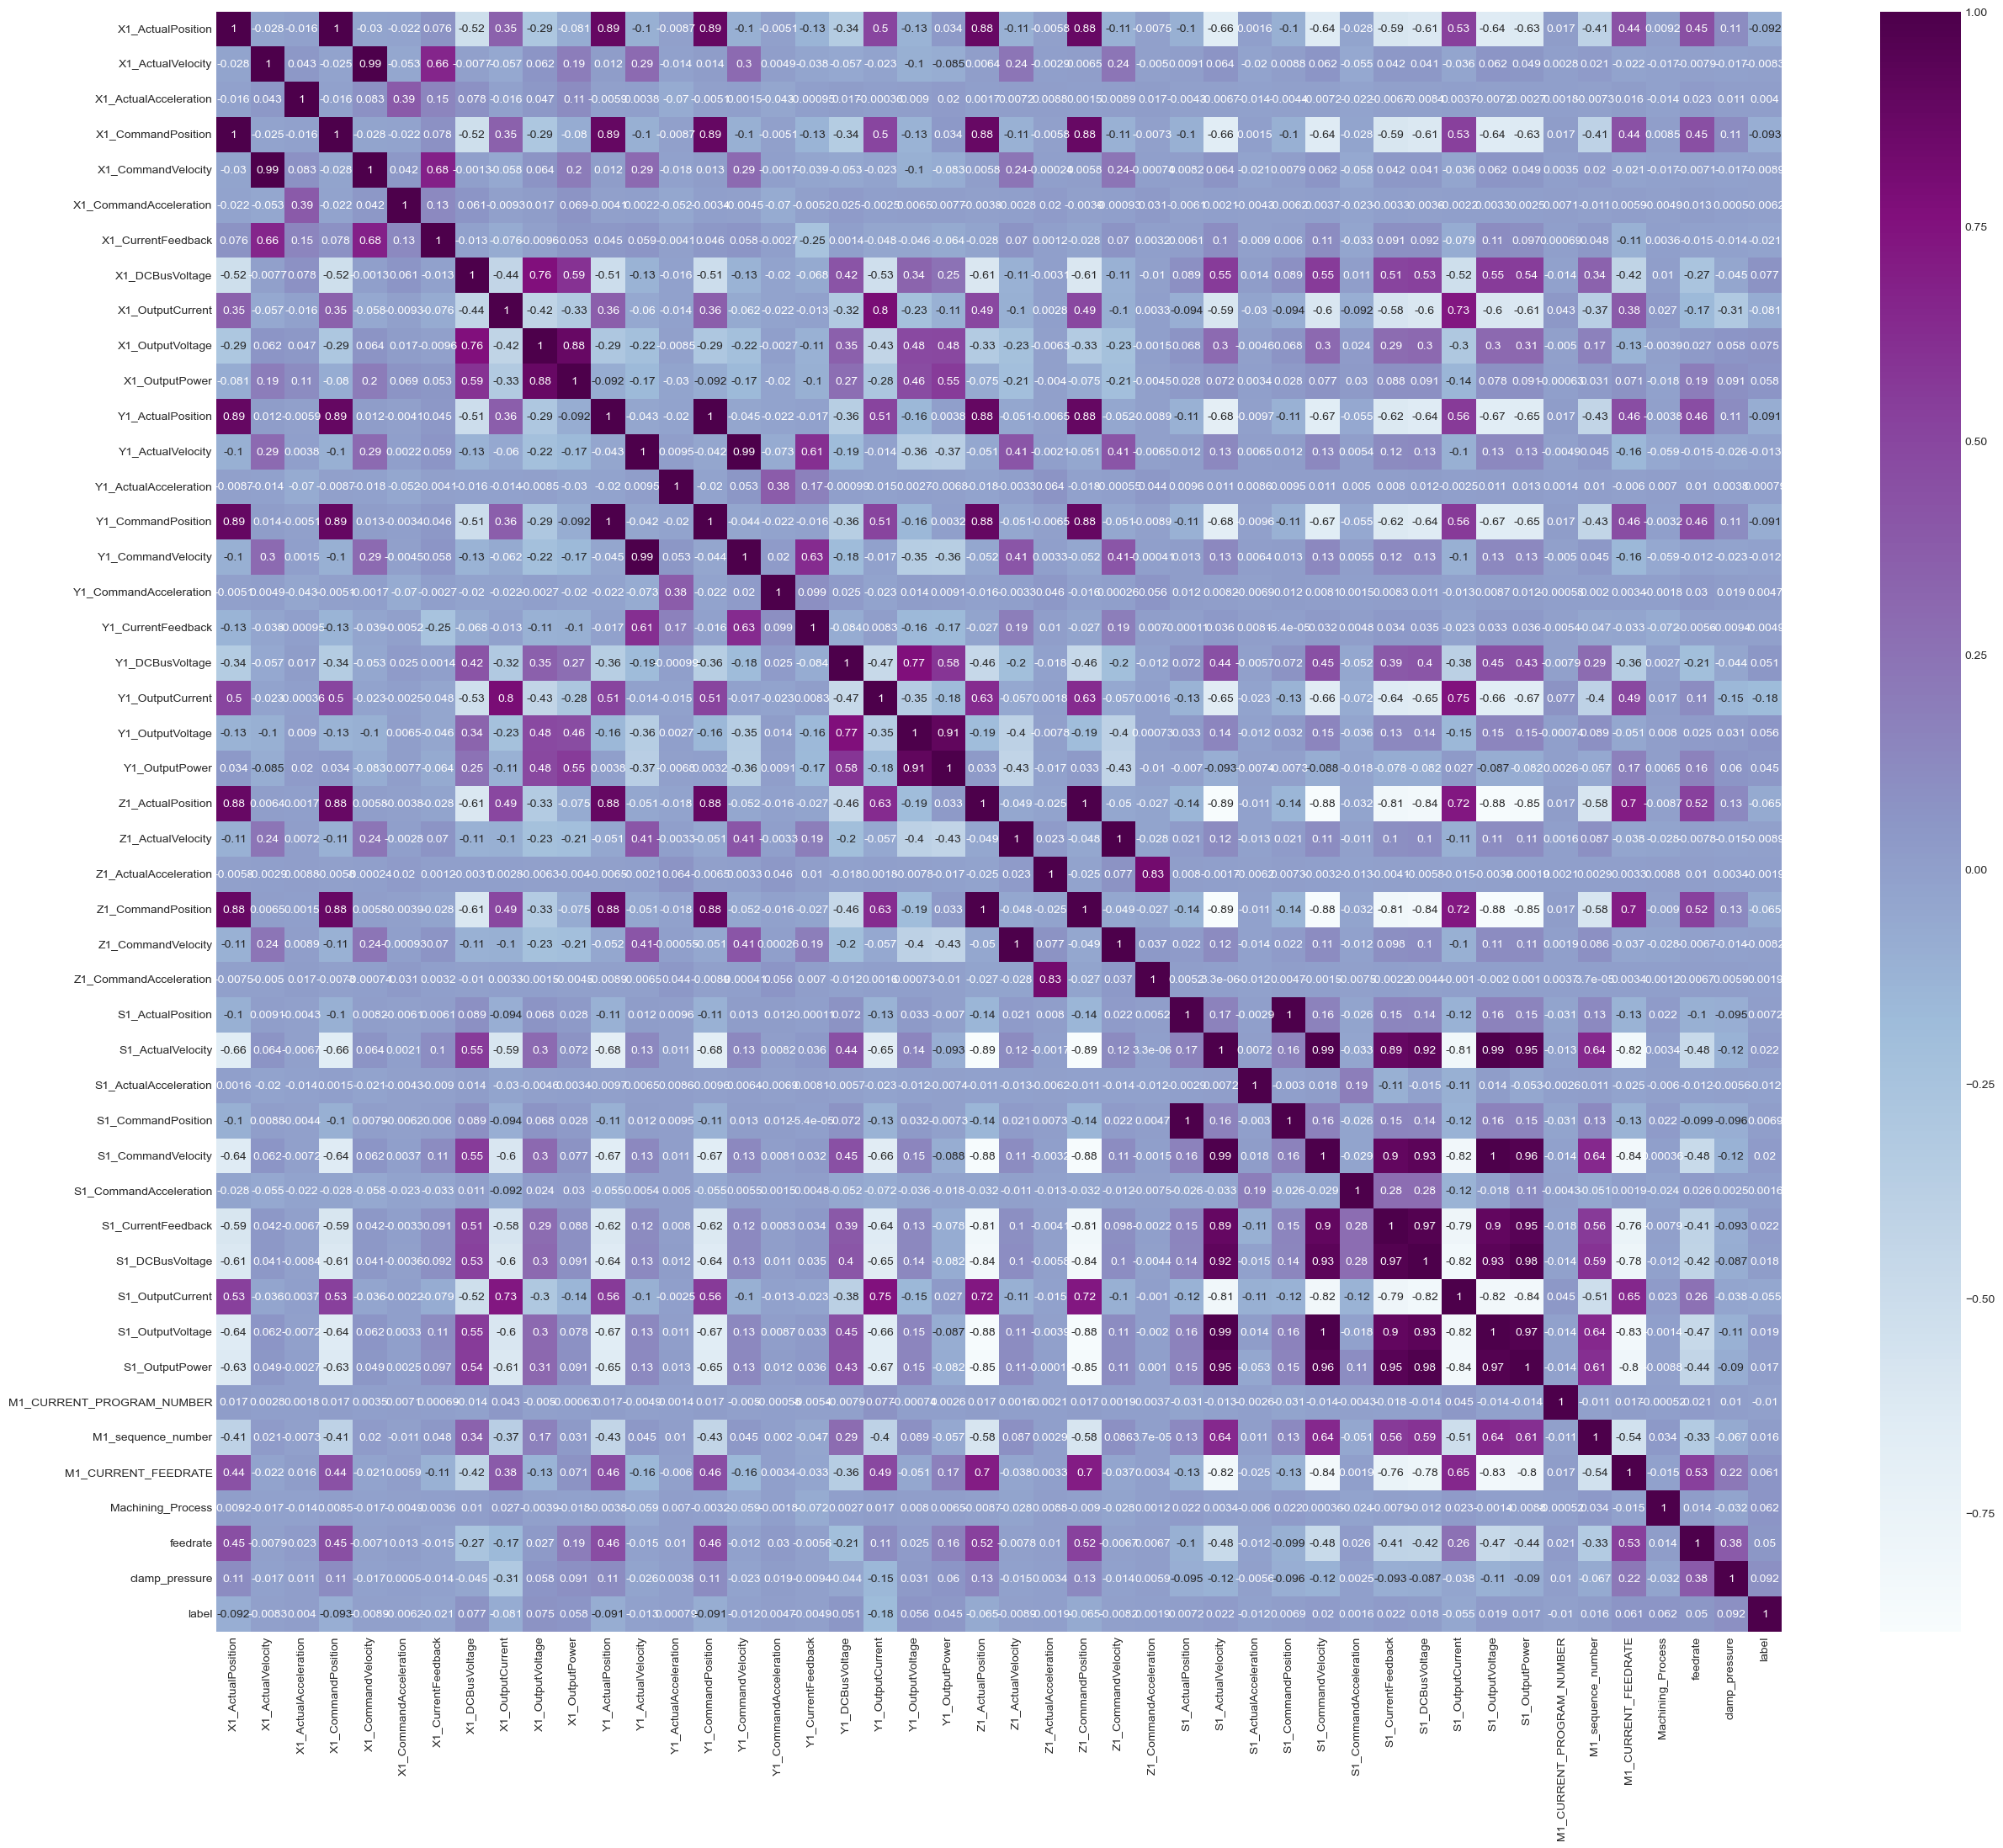

In [16]:
# correlation matrix after delete variables
plt.figure(figsize = (30,25))
p = sns.heatmap(data.corr(), annot= True,cmap='BuPu')

Looking at the correlation matrix, there are variables that correlate well with each other, which shows multicollinearity

In [17]:
# create independent variable X
X = data.drop(['label', 'Machining_Process'], axis=1)
# create dependent variable y
y = data['label']

In [18]:
# splitting dataset on train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=0)
X_train.shape, X_test.shape

((18964, 44), (6322, 44))

## Step #2.2: Imputation  Analysis

features  missing_count  percentage (%)
0       Z1_ActualAcceleration             38        0.200380
1       Y1_ActualAcceleration             34        0.179287
2       S1_ActualAcceleration             34        0.179287
3      Z1_CommandAcceleration             33        0.174014
4          X1_CommandVelocity             30        0.158194
5             S1_DCBusVoltage             30        0.158194
6          X1_CurrentFeedback             29        0.152921
7          Z1_CommandPosition             29        0.152921
8           Y1_ActualPosition             28        0.147648
9            S1_OutputVoltage             27        0.142375
10         X1_CommandPosition             27        0.142375
11             S1_OutputPower             26        0.137102
12     S1_CommandAcceleration             26        0.137102
13           Y1_OutputVoltage             25        0.131829
14         Y1_CurrentFeedback             25        0.131829
15          Z1_ActualVelocity             25        0.131829
16         Z1_CommandVelocity             24        0.126556
17     X1_CommandAcceleration             24        0.126556
18           S1_OutputCurrent             23        0.121282
19           Y1_OutputCurrent             23        0.121282
20           X1_OutputVoltage             23        0.121282
21            Y1_DCBusVoltage             23        0.121282
22            X1_DCBusVoltage             22        0.116009
23          S1_ActualPosition             22        0.116009
24         S1_CurrentFeedback             22        0.116009
25         Y1_CommandVelocity             21        0.110736
26           X1_OutputCurrent             21        0.110736
27          Y1_ActualVelocity             20        0.105463
28         S1_CommandVelocity             20        0.105463
29          Z1_ActualPosition             19        0.100190
30         Y1_CommandPosition             19        0.100190
31         S1_CommandPosition             19        0.100190
32             Y1_OutputPower             18        0.094917
33          S1_ActualVelocity             17        0.089644
34             X1_OutputPower             17        0.089644
35     Y1_CommandAcceleration             17        0.089644
36  M1_CURRENT_PROGRAM_NUMBER             13        0.068551
37         M1_sequence_number             12        0.063278
38      X1_ActualAcceleration              8        0.042185
39        M1_CURRENT_FEEDRATE              7        0.036912
40          X1_ActualVelocity              5        0.026366
41          X1_ActualPosition              1        0.005273

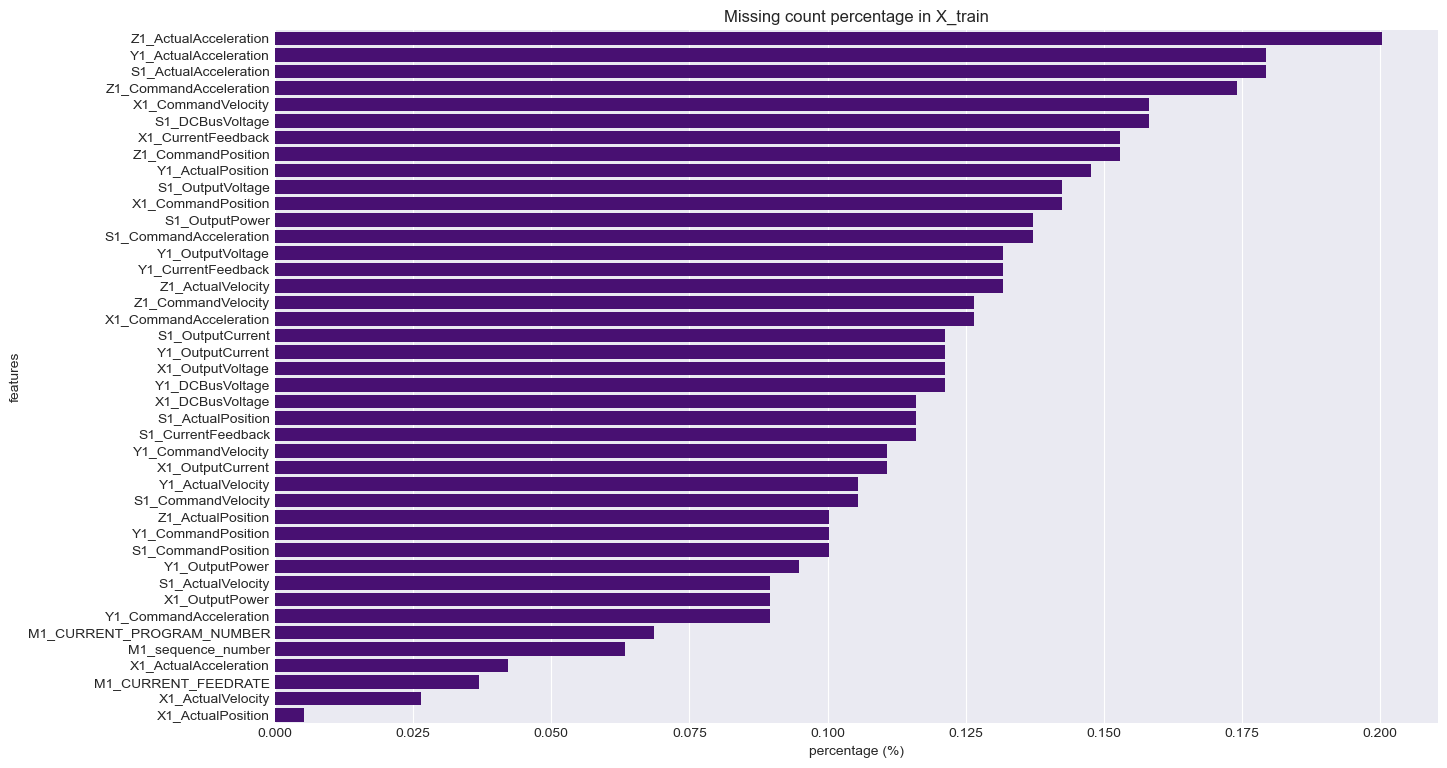

In [19]:
# show missing data in percentage in X_train
missing_data(X_train,y_train,'indigo', 'Missing count percentage in X_train')

We can see that there are variables with missing data in the train dataset, but their numbers are less than 0.2%.

features  missing_count  percentage (%)
0             S1_DCBusVoltage             16        0.253084
1       S1_ActualAcceleration             13        0.205631
2           Z1_ActualPosition             13        0.205631
3      Z1_CommandAcceleration             13        0.205631
4          X1_CommandPosition             12        0.189813
5           Z1_ActualVelocity             12        0.189813
6          Z1_CommandPosition             12        0.189813
7              X1_OutputPower             11        0.173996
8              Y1_OutputPower             11        0.173996
9          Y1_CommandPosition             11        0.173996
10         S1_CurrentFeedback             11        0.173996
11         Z1_CommandVelocity             11        0.173996
12          Y1_ActualVelocity             10        0.158178
13          Y1_ActualPosition              9        0.142360
14      Y1_ActualAcceleration              9        0.142360
15      Z1_ActualAcceleration              9        0.142360
16            Y1_DCBusVoltage              9        0.142360
17           X1_OutputVoltage              8        0.126542
18         Y1_CommandVelocity              8        0.126542
19           Y1_OutputCurrent              8        0.126542
20          S1_ActualPosition              7        0.110724
21     Y1_CommandAcceleration              7        0.110724
22     S1_CommandAcceleration              7        0.110724
23            X1_DCBusVoltage              7        0.110724
24           S1_OutputVoltage              6        0.094907
25             S1_OutputPower              6        0.094907
26         X1_CommandVelocity              6        0.094907
27         S1_CommandPosition              6        0.094907
28         S1_CommandVelocity              6        0.094907
29         Y1_CurrentFeedback              5        0.079089
30           X1_OutputCurrent              5        0.079089
31          S1_ActualVelocity              5        0.079089
32      X1_ActualAcceleration              5        0.079089
33           S1_OutputCurrent              4        0.063271
34          X1_ActualVelocity              3        0.047453
35         X1_CurrentFeedback              3        0.047453
36           Y1_OutputVoltage              2        0.031636
37  M1_CURRENT_PROGRAM_NUMBER              2        0.031636
38     X1_CommandAcceleration              2        0.031636
39          X1_ActualPosition              1        0.015818

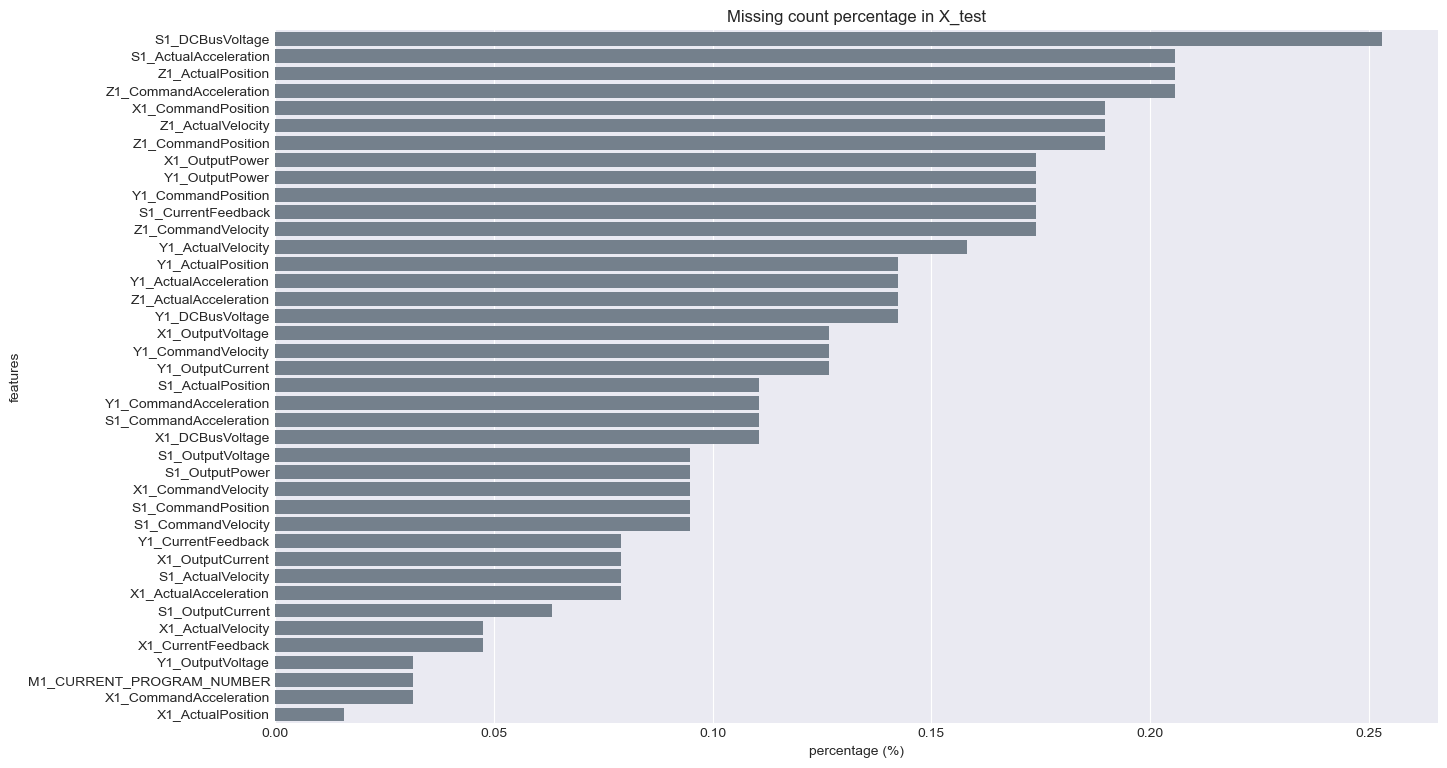

In [20]:
# show missing data in percentage in X_test
missing_data(X_test,y_test,'slategrey', 'Missing count percentage in X_test')

We can see that there are variables with missing data in the test dataset, but their numbers are less than 0.2%.

###  Imputation 'S1_CurrentFeedback' variable

In [21]:
# create a copy of the variables
X_train['S1_CurrentFeedback_mean'] = X_train['S1_CurrentFeedback'].copy()
X_test['S1_CurrentFeedback_mean'] = X_test['S1_CurrentFeedback'].copy()
X_train['S1_CurrentFeedback_median'] = X_train['S1_CurrentFeedback'].copy()
X_test['S1_CurrentFeedback_median'] = X_test['S1_CurrentFeedback'].copy()
X_train['S1_CurrentFeedback_random'] = X_train['S1_CurrentFeedback'].copy()
X_test['S1_CurrentFeedback_random'] = X_test['S1_CurrentFeedback'].copy()
X_train['S1_CurrentFeedback_arb'] = X_train['S1_CurrentFeedback'].copy()
X_test['S1_CurrentFeedback_arb'] = X_test['S1_CurrentFeedback'].copy()

In [22]:
# Mean Median Imputer
mean_im= MeanMedianImputer(imputation_method='mean', variables=['S1_CurrentFeedback_mean'])
mean_im.fit(X_train)
X_train = mean_im.transform(X_train)
X_test = mean_im.transform(X_test)
median_im=MeanMedianImputer(imputation_method='median', variables=['S1_CurrentFeedback_median'])
median_im.fit(X_train)
X_train = median_im.transform(X_train)
X_test = median_im.transform(X_test)
# Random Sample Imputer
random_im=RandomSampleImputer(variables=['S1_CurrentFeedback_random'])
random_im.fit(X_train)
X_train= random_im.transform(X_train)
X_test= random_im.transform(X_test)
# Arbitrary Number Imputer
arb_im= ArbitraryNumberImputer(arbitrary_number=-1, variables=['S1_CurrentFeedback_arb'])
arb_im.fit(X_train)
X_train= arb_im.transform(X_train)
X_test= arb_im.transform(X_test)

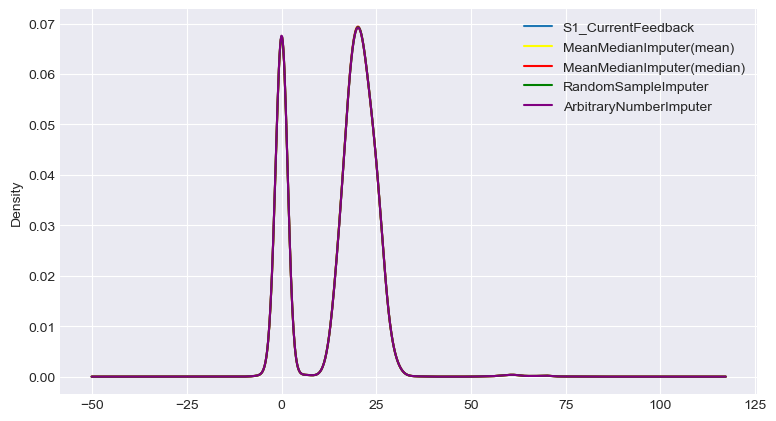

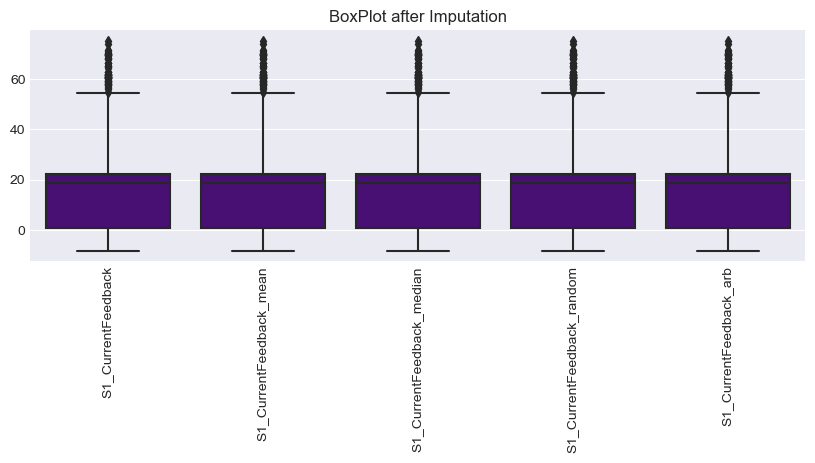

Original variable variance: 104.85946716216142
Variance after median imputation: 104.73781403356534
Variance after mean imputation: 104.75281930871208
Variance after random imputer: 104.81182440015803
Variance after arbitrary imputer: 105.04198959603939


In [23]:
# visualization of imputation
make_plot(X_train,'S1_CurrentFeedback','S1_CurrentFeedback_mean','S1_CurrentFeedback_median','S1_CurrentFeedback_random','S1_CurrentFeedback_arb')

The variable's number is less than 0.2%, and each imputer worked well.

## Step #2.3: Discretization Analysis

In [24]:
# show ordinal variables
ord_list = list()
for col in X_train.columns:
    if X_train[col].nunique() < 20:
        print('[',col,']' + ' is ordinal variable with : ',len(X_train[col].unique()),' labels')
        ord_list.append(col)

[ X1_OutputCurrent ] is ordinal variable with :  13  labels
[ Y1_OutputCurrent ] is ordinal variable with :  16  labels
[ S1_CommandAcceleration ] is ordinal variable with :  6  labels
[ M1_CURRENT_PROGRAM_NUMBER ] is ordinal variable with :  4  labels
[ M1_CURRENT_FEEDRATE ] is ordinal variable with :  7  labels
[ feedrate ] is ordinal variable with :  5  labels
[ clamp_pressure ] is ordinal variable with :  3  labels


In [25]:
# select only variables for discretization
discr_list = list()
for i in X_train.columns:
    if i not in ord_list:
        discr_list.append(i)
discr_list

['X1_ActualPosition',
 'X1_ActualVelocity',
 'X1_ActualAcceleration',
 'X1_CommandPosition',
 'X1_CommandVelocity',
 'X1_CommandAcceleration',
 'X1_CurrentFeedback',
 'X1_DCBusVoltage',
 'X1_OutputVoltage',
 'X1_OutputPower',
 'Y1_ActualPosition',
 'Y1_ActualVelocity',
 'Y1_ActualAcceleration',
 'Y1_CommandPosition',
 'Y1_CommandVelocity',
 'Y1_CommandAcceleration',
 'Y1_CurrentFeedback',
 'Y1_DCBusVoltage',
 'Y1_OutputVoltage',
 'Y1_OutputPower',
 'Z1_ActualPosition',
 'Z1_ActualVelocity',
 'Z1_ActualAcceleration',
 'Z1_CommandPosition',
 'Z1_CommandVelocity',
 'Z1_CommandAcceleration',
 'S1_ActualPosition',
 'S1_ActualVelocity',
 'S1_ActualAcceleration',
 'S1_CommandPosition',
 'S1_CommandVelocity',
 'S1_CurrentFeedback',
 'S1_DCBusVoltage',
 'S1_OutputCurrent',
 'S1_OutputVoltage',
 'S1_OutputPower',
 'M1_sequence_number',
 'S1_CurrentFeedback_mean',
 'S1_CurrentFeedback_median',
 'S1_CurrentFeedback_random',
 'S1_CurrentFeedback_arb']

In [26]:
# imputation missing data
random_im=RandomSampleImputer(variables=discr_list)
random_im.fit(X_train)
X_train= random_im.transform(X_train)
X_test= random_im.transform(X_test)

#### EqualFrequencyDiscretiser

In [27]:
disc = EqualFrequencyDiscretiser(q = 10, variables =discr_list)
disc.fit(X_train)
X_train_eFdisc= disc.transform(X_train)
X_test_eFdisc= disc.transform(X_test)

#### EqualWidthDiscretiser

In [28]:
disc = EqualWidthDiscretiser(bins= 10, variables =discr_list)
disc.fit(X_train)
X_train_eWdisc= disc.transform(X_train)
X_test_eWdisc= disc.transform(X_test)

### Distribution and oultliers "X1_ActualPosition" variable

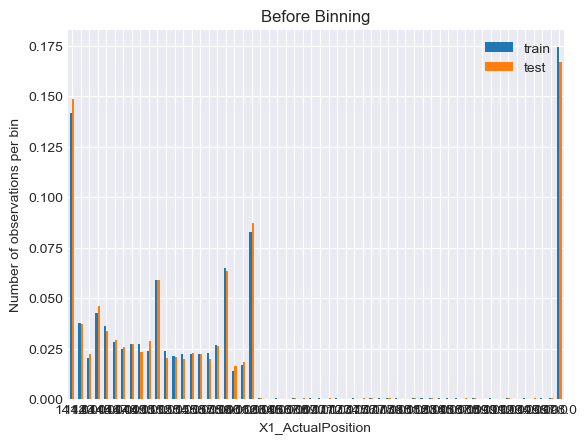

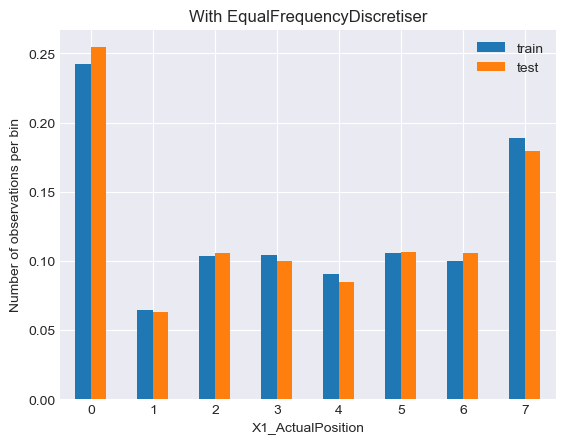

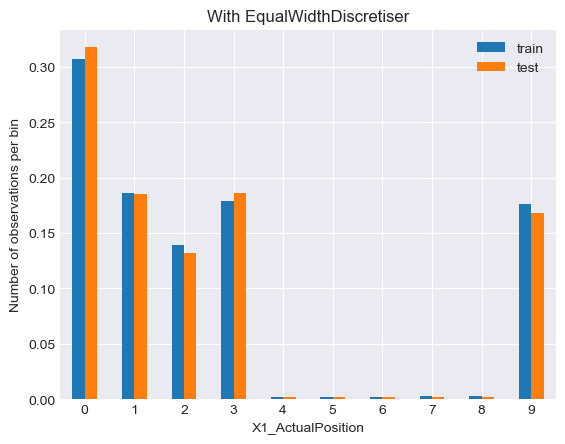

In [29]:
# visualization
discretisation_plot(X_train,X_test, X_train_eFdisc,X_test_eFdisc,X_train_eWdisc,X_test_eWdisc,"X1_ActualPosition")

* Equal Frequency Discretiser, divides the scope of possible values of the variable into 10 bins(each bin carries the same amount of observation) and impoved value spread.
* Equal Width Discretiser, divides the scope of possible values into 10 bins of the same amount of observation) and didn't impove value spread.

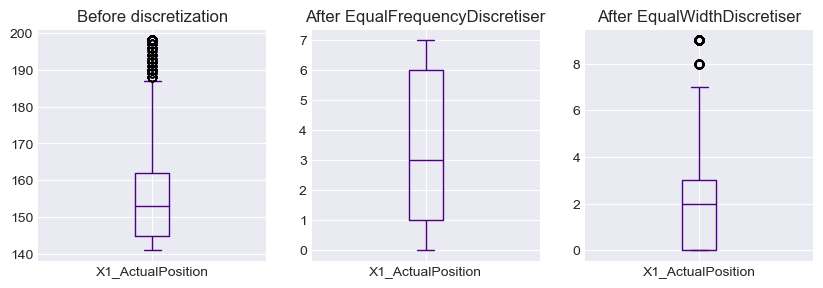

In [30]:
# checking for outliers
box_discretisation_plot(X_train, X_train_eFdisc,X_train_eWdisc,"X1_ActualPosition")

Equal Frequency Discretiser handles outliers better than Equal Width Discretiser.

### Distribution and oultliers "S1_CurrentFeedback" variable

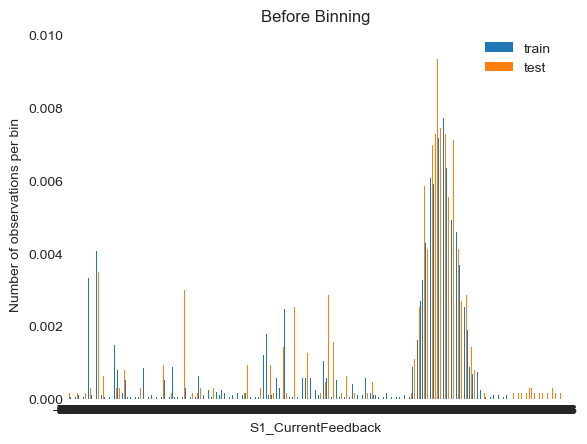

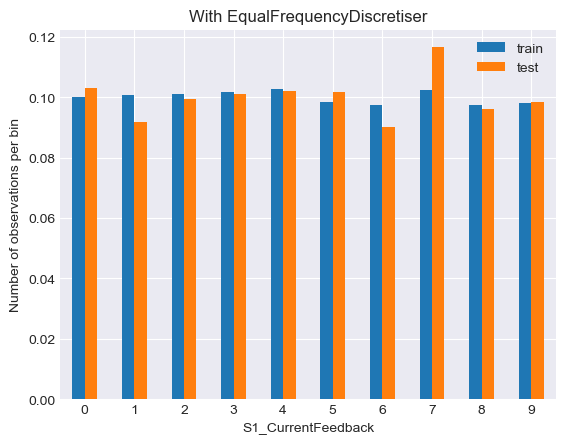

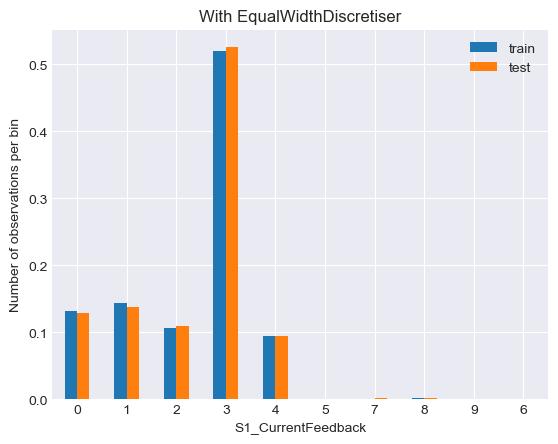

In [31]:
# visualization
discretisation_plot(X_train,X_test, X_train_eFdisc,X_test_eFdisc,X_train_eWdisc,X_test_eWdisc,"S1_CurrentFeedback")

* Equal Frequency Discretiser, divides the scope of possible values of the variable into 10 bins(each bin carries the same amount of observation) and impoved value spread.
* Equal Width Discretiser, divides the scope of possible values into 10 bins of the same amount of observation) and didn't impove value spread.

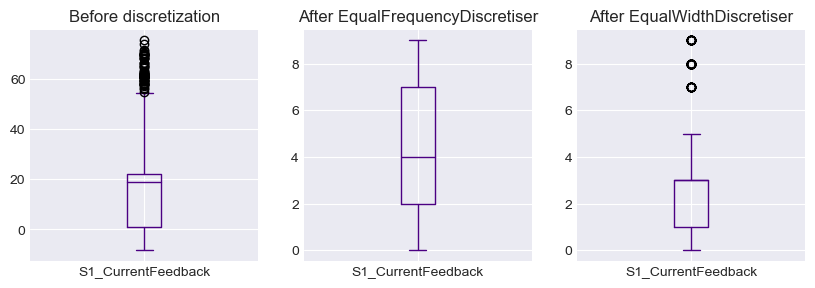

In [32]:
# checking for outliers
box_discretisation_plot(X_train, X_train_eFdisc,X_train_eWdisc,"S1_CurrentFeedback")

Equal Frequency Discretiser handles outliers better than Equal Width Discretiser.

## Step #2.4: Scaling Analysis

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)
X_train.shape, X_test.shape

((20228, 44), (5058, 44))

In [34]:
# imputation missing data
random_im=RandomSampleImputer()
random_im.fit(X_train)
X_train= random_im.transform(X_train)
X_test= random_im.transform(X_test)

#### Standard Scaler

In [35]:
stand_scaler = StandardScaler()
stand_scaler.fit(X_train)
X_train_standScaled= stand_scaler.transform(X_train)
X_test_standScaled= stand_scaler.transform(X_test)
X_train_standScaled = pd.DataFrame(X_train_standScaled, columns=X_train.columns)
X_test_standScaled= pd.DataFrame(X_test_standScaled, columns=X_test.columns)

#### MinMax Scaler

In [36]:
mm_scaler = MinMaxScaler()
mm_scaler.fit(X_train)
X_train_mmScaled = mm_scaler.transform(X_train)
X_test_mmScaled = mm_scaler.transform(X_test)
X_train_mmScaled = pd.DataFrame(X_train_mmScaled, columns=X_train.columns)
X_test_mmScaled = pd.DataFrame(X_test_mmScaled, columns=X_test.columns)

#### Robust Scaler

In [37]:
rob_scaler = RobustScaler()
rob_scaler.fit(X_train)
X_train_robScaled= rob_scaler.transform(X_train)
X_test_robScaled= rob_scaler.transform(X_test)
X_train_robScaled= pd.DataFrame(X_train_robScaled, columns=X_train.columns)
X_test_robScaled= pd.DataFrame(X_test_robScaled, columns=X_test.columns)

### Visualization and oultliers by position

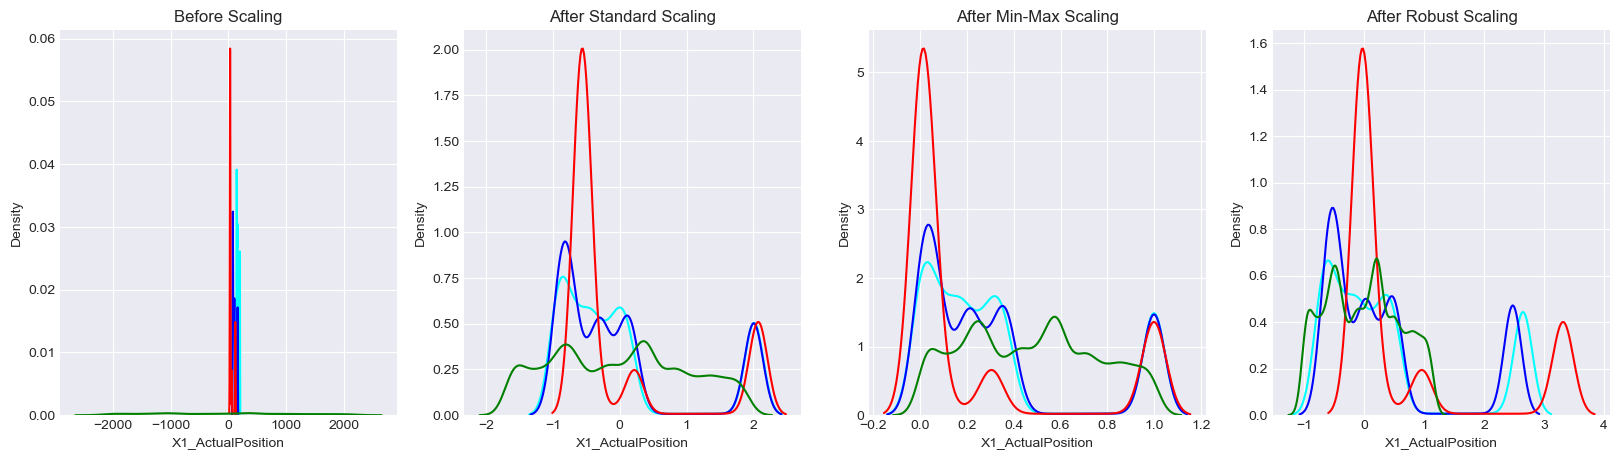

In [38]:
# take random variables
scaling_plot(X_train, X_train_standScaled, X_train_mmScaled, X_train_robScaled,'X1_ActualPosition','Y1_ActualPosition','Z1_ActualPosition', 'S1_ActualPosition')

We can see that the scaling normalized the range of independent variables.

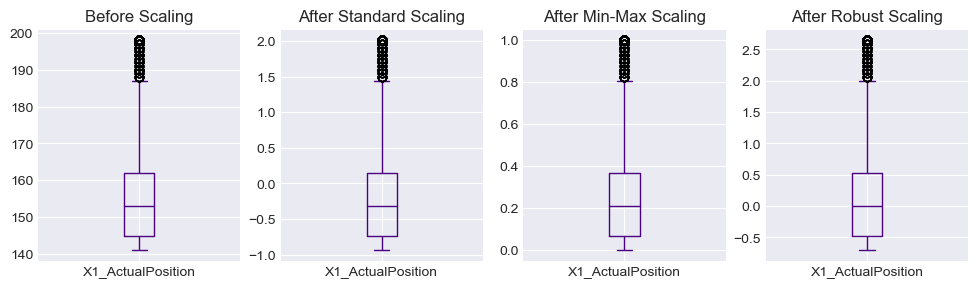

In [39]:
# checking for outliers
box_plot(X_train,X_train_standScaled,X_train_mmScaled,X_train_robScaled,"X1_ActualPosition")

After scaling the variables, the outliers were not affected in any way.

### Visualization and oultliers by velocity

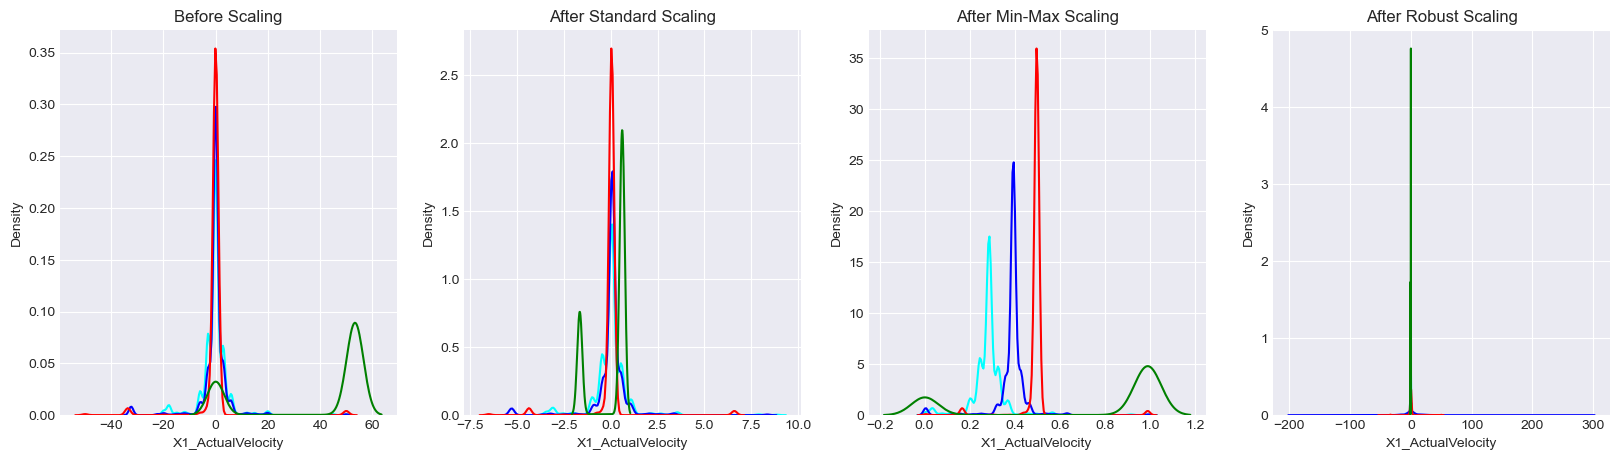

In [40]:
# take random variables
scaling_plot(X_train, X_train_standScaled, X_train_mmScaled, X_train_robScaled,'X1_ActualVelocity','Y1_ActualVelocity','Z1_ActualVelocity', 'S1_ActualVelocity')

We can see that the scaling normalized the range of independent variables.

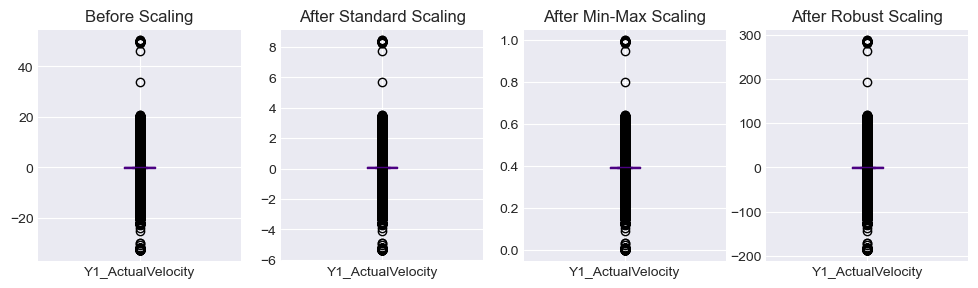

In [41]:
# checking for outliers
box_plot(X_train,X_train_standScaled,X_train_mmScaled,X_train_robScaled,"Y1_ActualVelocity")

After scaling the variables, the outliers were not affected in any way.

### Visualization and oultliers by accelrration

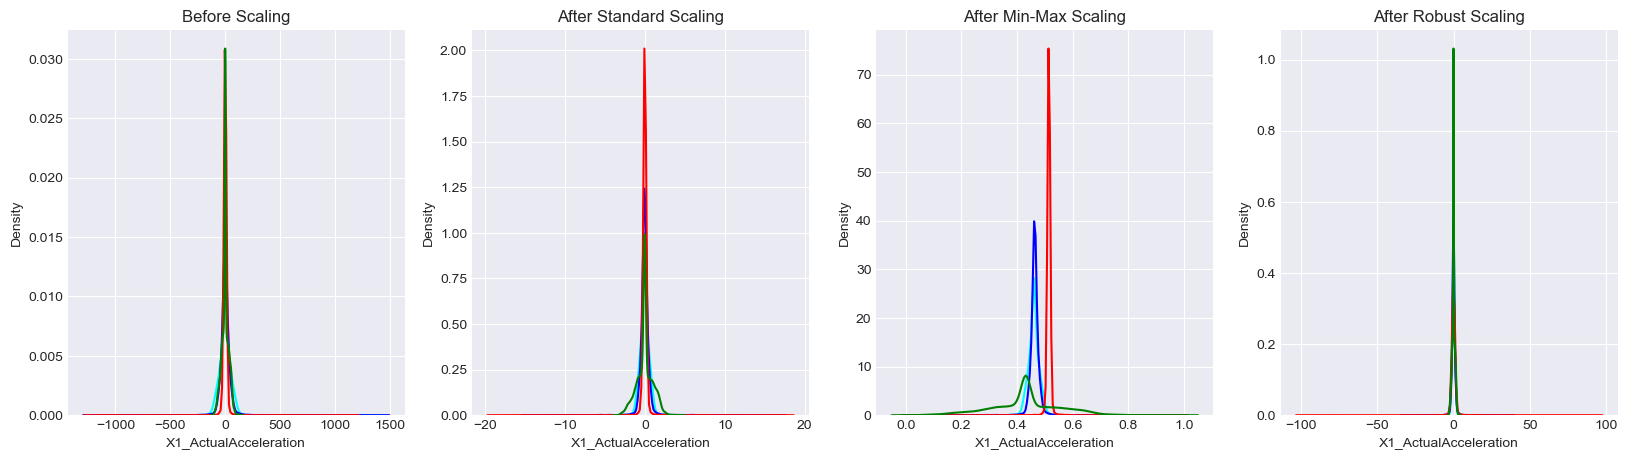

In [42]:
# take random variables
scaling_plot(X_train, X_train_standScaled, X_train_mmScaled, X_train_robScaled,'X1_ActualAcceleration','Y1_ActualAcceleration','Z1_ActualAcceleration', 'S1_ActualAcceleration')

We can see that the scaling normalized the range of independent variables.

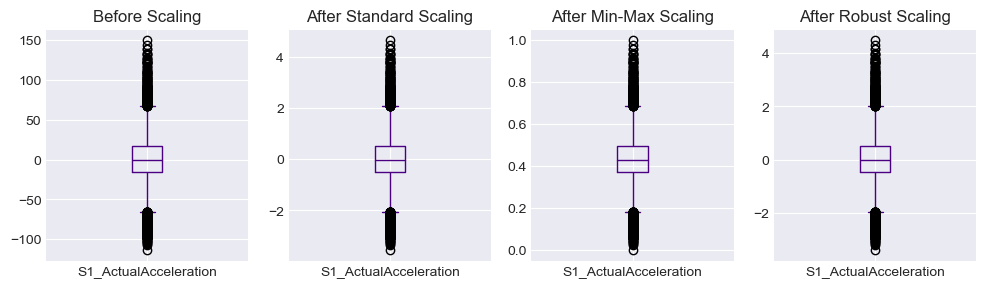

In [43]:
# checking for outliers
box_plot(X_train,X_train_standScaled,X_train_mmScaled,X_train_robScaled,"S1_ActualAcceleration")

After scaling the variables, the outliers were not affected in any way

## Step #2.5: Analysis delete variables with feature selection 

In [44]:
# remove correlated, quasi-constant, duplicated and constant variables in Pipeline
pipe = Pipeline([('constant', DropConstantFeatures()),
                 ('quasi-constant', DropConstantFeatures(tol=0.9)),
                 ('duplicated', DropDuplicateFeatures()),
                 ('correlated', SmartCorrelatedSelection(selection_method='cardinality'))])
pipe.fit(X_train_standScaled)
x_drop = pipe.transform(X_train_standScaled)

In [45]:
# checking constant features
len(pipe.named_steps['constant'].features_to_drop_)

0

In [46]:
# checking quasi-constant features
len(pipe.named_steps['quasi-constant'].features_to_drop_)

3

In [47]:
# checking duplicated features
len(pipe.named_steps['duplicated'].features_to_drop_)

0

In [48]:
# checking correlated features
len(pipe.named_steps['correlated'].features_to_drop_)

17

In [49]:
# how many columns are left after feature selection
x_drop.shape

(20228, 24)

# Step #3: Models with Pipeline & GridSearch

In [50]:
# splitting dataset on train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=0)
X_train.shape, X_test.shape

((18964, 44), (6322, 44))

In [51]:
# missing data
missing = [i for i in X_train.columns if X_train[i].isnull().mean() > 0]

In [52]:
# select only variables for discretization
discr_list = list()
for i in X_train.columns:
    if i not in ord_list:
        discr_list.append(i)

## Step #3.1: Decision Tree Classifier

In [53]:
# training the model using Pipeline with Grid Search
DT_pipe=Pipeline([('Imputation',MeanMedianImputer(variables=missing)),
                  ('Discretization',EqualFrequencyDiscretiser(variables = discr_list)),
                  ('Scaler',StandardScaler()),
                  ('Quasi-Constant',DropConstantFeatures(tol=0.9)),         
                  ('CorrelatedSelection',SmartCorrelatedSelection(selection_method='cardinality')),
                  ('DecisionTreeClassifier', DecisionTreeClassifier())])

params_DT = [{
        'Imputation' : [ArbitraryNumberImputer(variables=missing),
                        MeanMedianImputer(imputation_method='mean',variables=missing),
                        MeanMedianImputer(imputation_method='median', variables=missing),
                        RandomSampleImputer(variables=missing)],
    
        'Discretization' : [EqualFrequencyDiscretiser(q=5,variables=discr_list),
                            EqualFrequencyDiscretiser(q=10,variables=discr_list),
                            EqualWidthDiscretiser(bins=5,variables=discr_list),
                            EqualWidthDiscretiser(bins=10,variables=discr_list)],
    
        'Scaler' : [StandardScaler(),
                    RobustScaler(),
                    MinMaxScaler()],
    
        'DecisionTreeClassifier__max_depth' : [6,7,8],
        'DecisionTreeClassifier__min_samples_leaf' : [3,4,5],
        'DecisionTreeClassifier__criterion' : ['gini', 'entropy']
    }]

DT_gridSearch = GridSearchCV(estimator = DT_pipe, param_grid = params_DT, cv = 5, n_jobs = -1, scoring = 'accuracy')
DT_gridSearch.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Imputation',
                                        MeanMedianImputer(variables=['X1_ActualPosition',
                                                                     'X1_ActualVelocity',
                                                                     'X1_ActualAcceleration',
                                                                     'X1_CommandPosition',
                                                                     'X1_CommandVelocity',
                                                                     'X1_CommandAcceleration',
                                                                     'X1_CurrentFeedback',
                                                                     'X1_DCBusVoltage',
                                                                     'X1_OutputCurrent',
                                                                     'X1_OutputVoltage',
                                                                     'X1_OutputPower',
                                                                     'Y1_ActualPosition',
                                                                     'Y1_ActualVelocity...
                                                                        'Y1_CurrentFeedback',
                                                                        'Y1_DCBusVoltage',
                                                                        'Y1_OutputCurrent',
                                                                        'Y1_OutputVoltage',
                                                                        'Y1_OutputPower',
                                                                        'Z1_ActualPosition',
                                                                        'Z1_ActualVelocity',
                                                                        'Z1_ActualAcceleration',
                                                                        'Z1_CommandPosition',
                                                                        'Z1_CommandVelocity',
                                                                        'Z1_CommandAcceleration',
                                                                        'S1_ActualPosition',
                                                                        'S1_ActualVelocity', ...])],
                          'Scaler': [StandardScaler(), RobustScaler(),
                                     MinMaxScaler()]}],
             scoring='accuracy')

In [54]:
# selection of the best parameters
DT_gridSearch.best_params_

{'DecisionTreeClassifier__criterion': 'gini',
 'DecisionTreeClassifier__max_depth': 8,
 'DecisionTreeClassifier__min_samples_leaf': 5,
 'Discretization': EqualFrequencyDiscretiser(variables=['X1_ActualPosition', 'X1_ActualVelocity',
                                      'X1_ActualAcceleration',
                                      'X1_CommandPosition', 'X1_CommandVelocity',
                                      'X1_CommandAcceleration',
                                      'X1_CurrentFeedback', 'X1_DCBusVoltage',
                                      'X1_OutputVoltage', 'X1_OutputPower',
                                      'Y1_ActualPosition', 'Y1_ActualVelocity',
                                      'Y1_ActualAcceleration',
                                      'Y1_CommandPosition', 'Y1_CommandVelocity',
                                      'Y1_CommandAcceleration',
                                      'Y1_CurrentFeedback', 'Y1_DCBusVoltage',
                                   

In [55]:
# prediction
y_pred_train_DT = DT_gridSearch.predict(X_train)
y_pred_test_DT = DT_gridSearch.predict(X_test)

Train: 
accuracy 0.8620544188989665
              precision    recall  f1-score   support

           0       0.80      0.94      0.87      8965
           1       0.93      0.79      0.86      9999

    accuracy                           0.86     18964
   macro avg       0.87      0.87      0.86     18964
weighted avg       0.87      0.86      0.86     18964

------------------------------------------------------
Test: 
accuracy 0.8563745650110725
              precision    recall  f1-score   support

           0       0.80      0.93      0.86      3013
           1       0.93      0.79      0.85      3309

    accuracy                           0.86      6322
   macro avg       0.86      0.86      0.86      6322
weighted avg       0.87      0.86      0.86      6322



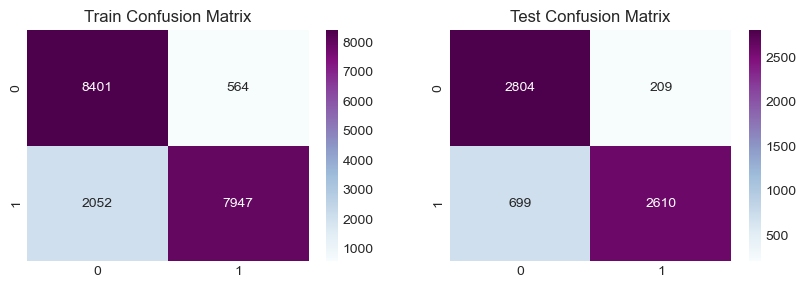

In [56]:
# let's have a look at the classification report and confution matrix
score_show(y_train, y_test,y_pred_train_DT,y_pred_test_DT)

 We observe underfitting on the test set. The model correctly predicted of tool don't wear 2804 times and tool wear 2610 times. However, the model made a false positive error 209 times and a false negative error 699 times.

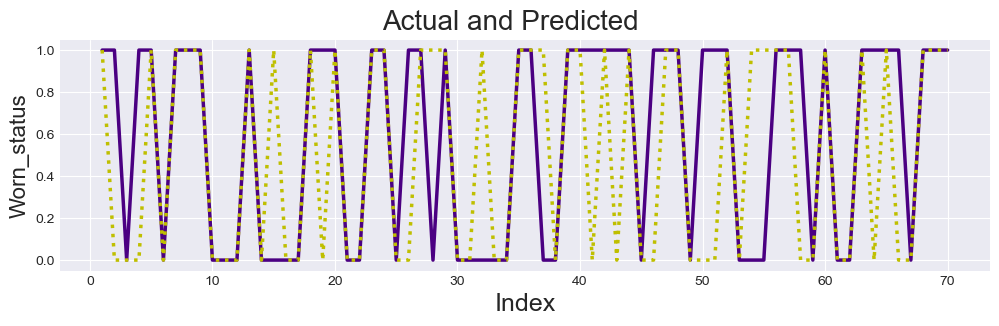

In [57]:
# actual vs predicted
predicted_plot(y_test, y_pred_test_DT)

On the graph we can see the difference between the real value and what the model predicted for us.

## Step #3.2: Random Forest Classifier

In [58]:
# training the model using Pipeline with Grid Search
RF_pipe=Pipeline([('Imputation',MeanMedianImputer(variables=missing)),
                  ('Discretization',EqualFrequencyDiscretiser(variables = discr_list)),
                  #('Scaler',StandardScaler()),
                  ('Quasi-Constant',DropConstantFeatures(tol=0.9)),
                  ('CorrelatedSelection',SmartCorrelatedSelection(selection_method='cardinality')),
                  ('RandomForestClassifier', RandomForestClassifier())])

params_RF = [{
         'Imputation' : [ArbitraryNumberImputer(variables=missing),
                        MeanMedianImputer(imputation_method='mean',variables=missing),
                        MeanMedianImputer(imputation_method='median', variables=missing),
                        RandomSampleImputer(variables=missing)],
    
        'Discretization' : [EqualFrequencyDiscretiser(q=5,variables=discr_list),
                            EqualFrequencyDiscretiser(q=10,variables=discr_list),
                            EqualWidthDiscretiser(bins=5,variables=discr_list),
                            EqualWidthDiscretiser(bins=10,variables=discr_list)],
#        'Scaler' : [StandardScaler(),
#                    RobustScaler(),
#                    MinMaxScaler()],
        'RandomForestClassifier__n_estimators' : [500,600,700],
        'RandomForestClassifier__max_depth' : [3,4,5],
        'RandomForestClassifier__min_samples_leaf' : [1,2,3],
        'RandomForestClassifier__criterion': ['gini','entropy','log_loss']
    }]

RF_gridSearch = GridSearchCV(estimator = RF_pipe, param_grid = params_RF, cv = 5, n_jobs = -1, scoring = 'accuracy')
RF_gridSearch.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Imputation',
                                        MeanMedianImputer(variables=['X1_ActualPosition',
                                                                     'X1_ActualVelocity',
                                                                     'X1_ActualAcceleration',
                                                                     'X1_CommandPosition',
                                                                     'X1_CommandVelocity',
                                                                     'X1_CommandAcceleration',
                                                                     'X1_CurrentFeedback',
                                                                     'X1_DCBusVoltage',
                                                                     'X1_OutputCurrent',
                                                                     'X1_OutputVoltage',
                                                                     'X1_OutputPower',
                                                                     'Y1_ActualPosition',
                                                                     'Y1_ActualVelocity...
                                                                        'Z1_ActualAcceleration',
                                                                        'Z1_CommandPosition',
                                                                        'Z1_CommandVelocity',
                                                                        'Z1_CommandAcceleration',
                                                                        'S1_ActualPosition',
                                                                        'S1_ActualVelocity', ...])],
                          'RandomForestClassifier__criterion': ['gini',
                                                                'entropy',
                                                                'log_loss'],
                          'RandomForestClassifier__max_depth': [3, 4, 5],
                          'RandomForestClassifier__min_samples_leaf': [1, 2, 3],
                          'RandomForestClassifier__n_estimators': [500, 600,
                                                                   700]}],
             scoring='accuracy')

In [59]:
# selection of the best parameters
RF_gridSearch.best_params_

{'Discretization': EqualFrequencyDiscretiser(variables=['X1_ActualPosition', 'X1_ActualVelocity',
                                      'X1_ActualAcceleration',
                                      'X1_CommandPosition', 'X1_CommandVelocity',
                                      'X1_CommandAcceleration',
                                      'X1_CurrentFeedback', 'X1_DCBusVoltage',
                                      'X1_OutputVoltage', 'X1_OutputPower',
                                      'Y1_ActualPosition', 'Y1_ActualVelocity',
                                      'Y1_ActualAcceleration',
                                      'Y1_CommandPosition', 'Y1_CommandVelocity',
                                      'Y1_CommandAcceleration',
                                      'Y1_CurrentFeedback', 'Y1_DCBusVoltage',
                                      'Y1_OutputVoltage', 'Y1_OutputPower',
                                      'Z1_ActualPosition', 'Z1_ActualVelocity',
              

In [60]:
# prediction
y_pred_train_RF = RF_gridSearch.predict(X_train)
y_pred_test_RF = RF_gridSearch.predict(X_test)

Train: 
accuracy 0.842754693102721
              precision    recall  f1-score   support

           0       0.81      0.88      0.84      8965
           1       0.88      0.81      0.84      9999

    accuracy                           0.84     18964
   macro avg       0.84      0.84      0.84     18964
weighted avg       0.85      0.84      0.84     18964

------------------------------------------------------
Test: 
accuracy 0.8403986080354319
              precision    recall  f1-score   support

           0       0.80      0.88      0.84      3013
           1       0.88      0.80      0.84      3309

    accuracy                           0.84      6322
   macro avg       0.84      0.84      0.84      6322
weighted avg       0.84      0.84      0.84      6322



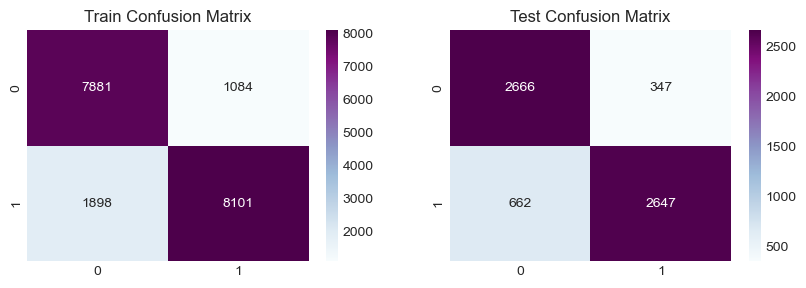

In [61]:
# let's have a look at the classification report and confution matrix
score_show(y_train, y_test,y_pred_train_RF,y_pred_test_RF)

On the test dataset, the model correctly predicted of tool don't wear 2666 times and tool wear 2647 times. However, the model made a false positive error 347 times and a false negative error 662 times.

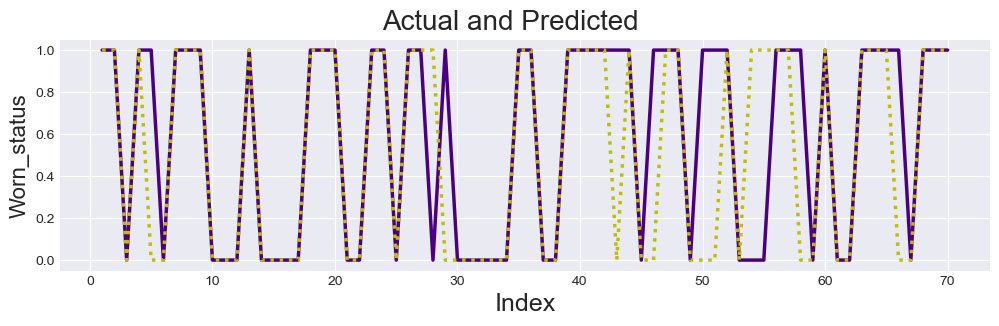

In [62]:
# actual vs predicted
predicted_plot(y_test, y_pred_test_RF)

On the graph we can see the difference between the real value and what the model predicted for us.

## Step #3.3 K-Nearest Neighbor Classifier

In [63]:
# training the model using Pipeline with Grid Search
KN_pipe=Pipeline([('Imputation',MeanMedianImputer(variables=missing)),
                  ('Discretization',EqualFrequencyDiscretiser(variables = discr_list)),
                  ('Scaler',StandardScaler()),
                  ('Quasi-Constant',DropConstantFeatures(tol=0.9)),
                  ('CorrelatedSelection',SmartCorrelatedSelection(selection_method='cardinality')),
                  ('KNeighborsClassifier', KNeighborsClassifier())])

params_KN = [{
        'Imputation' : [ArbitraryNumberImputer(variables=missing),
                        MeanMedianImputer(imputation_method='mean',variables=missing),
                        MeanMedianImputer(imputation_method='median', variables=missing),
                        RandomSampleImputer(variables=missing)],
    
        'Discretization' : [EqualFrequencyDiscretiser(q=5,variables=discr_list),
                            EqualFrequencyDiscretiser(q=10,variables=discr_list),
                            EqualWidthDiscretiser(bins=5,variables=discr_list),
                            EqualWidthDiscretiser(bins=10,variables=discr_list)],
    
        'Scaler' : [StandardScaler(),
                    RobustScaler(),
                    MinMaxScaler()],
    
        'KNeighborsClassifier__n_neighbors': [6,8,10],
        'KNeighborsClassifier__weights': ['uniform', 'distance'],
        'KNeighborsClassifier__metric': ['minkowski', 'euclidean', 'manhattan'],
        'KNeighborsClassifier__p':[0,1,2]
    }]

KN_gridSearch = GridSearchCV(estimator = KN_pipe, param_grid = params_KN, cv = 5, n_jobs = -1, scoring = 'accuracy')
KN_gridSearch.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Imputation',
                                        MeanMedianImputer(variables=['X1_ActualPosition',
                                                                     'X1_ActualVelocity',
                                                                     'X1_ActualAcceleration',
                                                                     'X1_CommandPosition',
                                                                     'X1_CommandVelocity',
                                                                     'X1_CommandAcceleration',
                                                                     'X1_CurrentFeedback',
                                                                     'X1_DCBusVoltage',
                                                                     'X1_OutputCurrent',
                                                                     'X1_OutputVoltage',
                                                                     'X1_OutputPower',
                                                                     'Y1_ActualPosition',
                                                                     'Y1_ActualVelocity...
                                                                        'Z1_CommandAcceleration',
                                                                        'S1_ActualPosition',
                                                                        'S1_ActualVelocity', ...])],
                          'KNeighborsClassifier__metric': ['minkowski',
                                                           'euclidean',
                                                           'manhattan'],
                          'KNeighborsClassifier__n_neighbors': [6, 8, 10],
                          'KNeighborsClassifier__p': [0, 1, 2],
                          'KNeighborsClassifier__weights': ['uniform',
                                                            'distance'],
                          'Scaler': [StandardScaler(), RobustScaler(),
                                     MinMaxScaler()]}],
             scoring='accuracy')

In [64]:
# selection of the best parameters
KN_gridSearch.best_params_

{'Discretization': EqualFrequencyDiscretiser(variables=['X1_ActualPosition', 'X1_ActualVelocity',
                                      'X1_ActualAcceleration',
                                      'X1_CommandPosition', 'X1_CommandVelocity',
                                      'X1_CommandAcceleration',
                                      'X1_CurrentFeedback', 'X1_DCBusVoltage',
                                      'X1_OutputVoltage', 'X1_OutputPower',
                                      'Y1_ActualPosition', 'Y1_ActualVelocity',
                                      'Y1_ActualAcceleration',
                                      'Y1_CommandPosition', 'Y1_CommandVelocity',
                                      'Y1_CommandAcceleration',
                                      'Y1_CurrentFeedback', 'Y1_DCBusVoltage',
                                      'Y1_OutputVoltage', 'Y1_OutputPower',
                                      'Z1_ActualPosition', 'Z1_ActualVelocity',
              

In [65]:
# prediction
y_pred_train_KN = KN_gridSearch.predict(X_train)
y_pred_test_KN = KN_gridSearch.predict(X_test)

Train: 
accuracy 0.9997890740350137
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8965
           1       1.00      1.00      1.00      9999

    accuracy                           1.00     18964
   macro avg       1.00      1.00      1.00     18964
weighted avg       1.00      1.00      1.00     18964

------------------------------------------------------
Test: 
accuracy 0.9041442581461563
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      3013
           1       0.91      0.91      0.91      3309

    accuracy                           0.90      6322
   macro avg       0.90      0.90      0.90      6322
weighted avg       0.90      0.90      0.90      6322



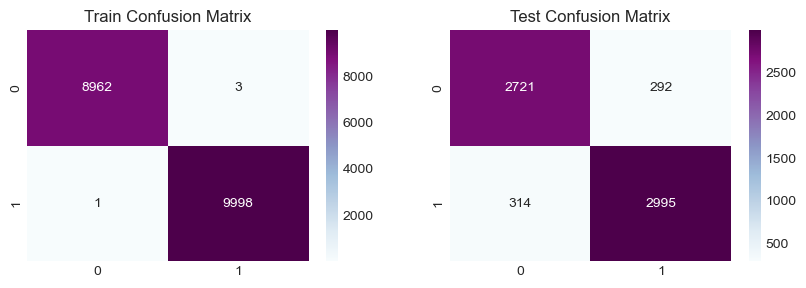

In [66]:
# let's have a look at the classification report and confution matrix
score_show(y_train, y_test,y_pred_train_KN,y_pred_test_KN)

On the test dataset, the model correctly predicted of tool don't wear 2721 times and tool wear 2995 times. However, the model made a false positive error 292 times and a false negative error 314 times.

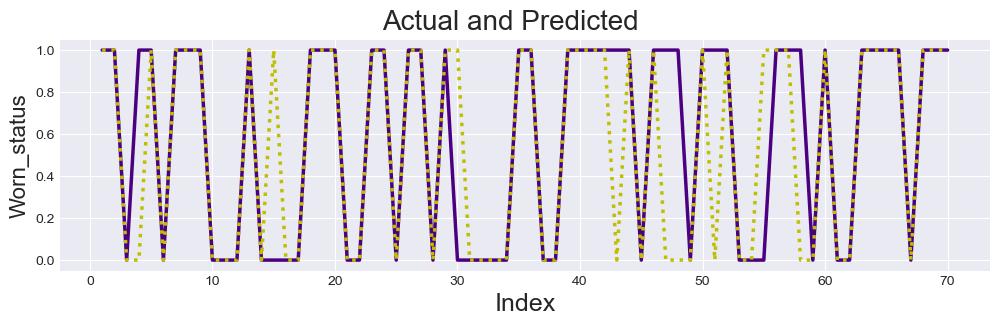

In [67]:
# actual vs predicted
predicted_plot(y_test, y_pred_test_KN)

On the graph we can see the difference between the real value and what the model predicted for us.

## Step #3.4: Logistic Regression

In [68]:
# training the model using Pipeline with Grid Search
LR_pipe=Pipeline([('Imputation',MeanMedianImputer(variables=missing)),
                  ('Discretization',EqualFrequencyDiscretiser(variables = discr_list)),
                  ('Scaler',StandardScaler()),
                  ('Quasi-Constant',DropConstantFeatures(tol=0.9)),
                  ('CorrelatedSelection',SmartCorrelatedSelection(selection_method='cardinality')),
                  ('LogisticRegression', LogisticRegression())])

params_LR = [{
        'Imputation' : [ArbitraryNumberImputer(variables=missing),
                        MeanMedianImputer(imputation_method='mean',variables=missing),
                        MeanMedianImputer(imputation_method='median', variables=missing),
                        RandomSampleImputer(variables=missing)],
    
        'Discretization' : [EqualFrequencyDiscretiser(q=5,variables=discr_list),
                            EqualFrequencyDiscretiser(q=10,variables=discr_list),
                            EqualWidthDiscretiser(bins=5,variables=discr_list),
                            EqualWidthDiscretiser(bins=10,variables=discr_list)],
    
        'Scaler' : [StandardScaler(),
                    RobustScaler(),
                    MinMaxScaler()],
        'LogisticRegression__C' : [0.1],
        'LogisticRegression__solver': ['lbfgs', 'liblinear','saga'],
        'LogisticRegression__penalty': ['l1', 'l2', 'none'],
        'LogisticRegression__dual':['bool', False]
    }]

LR_gridSearch = GridSearchCV(estimator = LR_pipe, param_grid = params_LR, cv = 5, n_jobs = -1, scoring = 'accuracy')
LR_gridSearch.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Imputation',
                                        MeanMedianImputer(variables=['X1_ActualPosition',
                                                                     'X1_ActualVelocity',
                                                                     'X1_ActualAcceleration',
                                                                     'X1_CommandPosition',
                                                                     'X1_CommandVelocity',
                                                                     'X1_CommandAcceleration',
                                                                     'X1_CurrentFeedback',
                                                                     'X1_DCBusVoltage',
                                                                     'X1_OutputCurrent',
                                                                     'X1_OutputVoltage',
                                                                     'X1_OutputPower',
                                                                     'Y1_ActualPosition',
                                                                     'Y1_ActualVelocity...
                                                                        'Z1_CommandVelocity',
                                                                        'Z1_CommandAcceleration',
                                                                        'S1_ActualPosition',
                                                                        'S1_ActualVelocity', ...])],
                          'LogisticRegression__C': [0.1],
                          'LogisticRegression__dual': ['bool', False],
                          'LogisticRegression__penalty': ['l1', 'l2', 'none'],
                          'LogisticRegression__solver': ['lbfgs', 'liblinear',
                                                         'saga'],
                          'Scaler': [StandardScaler(), RobustScaler(),
                                     MinMaxScaler()]}],
             scoring='accuracy')

In [69]:
# selection of the best parameters
LR_gridSearch.best_params_

{'Discretization': EqualFrequencyDiscretiser(variables=['X1_ActualPosition', 'X1_ActualVelocity',
                                      'X1_ActualAcceleration',
                                      'X1_CommandPosition', 'X1_CommandVelocity',
                                      'X1_CommandAcceleration',
                                      'X1_CurrentFeedback', 'X1_DCBusVoltage',
                                      'X1_OutputVoltage', 'X1_OutputPower',
                                      'Y1_ActualPosition', 'Y1_ActualVelocity',
                                      'Y1_ActualAcceleration',
                                      'Y1_CommandPosition', 'Y1_CommandVelocity',
                                      'Y1_CommandAcceleration',
                                      'Y1_CurrentFeedback', 'Y1_DCBusVoltage',
                                      'Y1_OutputVoltage', 'Y1_OutputPower',
                                      'Z1_ActualPosition', 'Z1_ActualVelocity',
              

In [70]:
# prediction
y_pred_train_LR = LR_gridSearch.predict(X_train)
y_pred_test_LR = LR_gridSearch.predict(X_test)

Train: 
accuracy 0.6400548407508965
              precision    recall  f1-score   support

           0       0.63      0.58      0.61      8965
           1       0.65      0.69      0.67      9999

    accuracy                           0.64     18964
   macro avg       0.64      0.64      0.64     18964
weighted avg       0.64      0.64      0.64     18964

------------------------------------------------------
Test: 
accuracy 0.6434672571970895
              precision    recall  f1-score   support

           0       0.63      0.60      0.61      3013
           1       0.65      0.69      0.67      3309

    accuracy                           0.64      6322
   macro avg       0.64      0.64      0.64      6322
weighted avg       0.64      0.64      0.64      6322



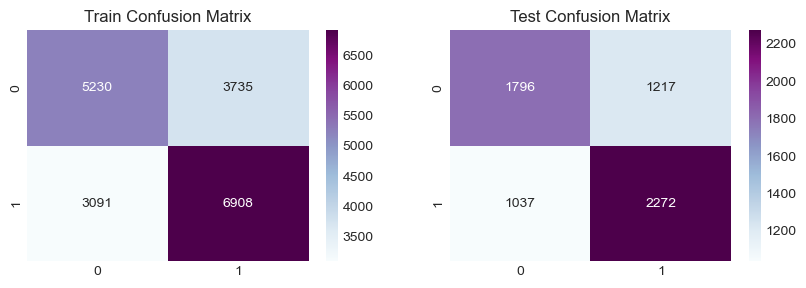

In [71]:
# let's have a look at the classification report and confution matrix
score_show(y_train, y_test,y_pred_train_LR,y_pred_test_LR)

On the test dataset, the model correctly predicted of tool don't wear 1796 times and tool wear 2272 times. However, the model made a false positive error 1217 times and a false negative error 1037 times.

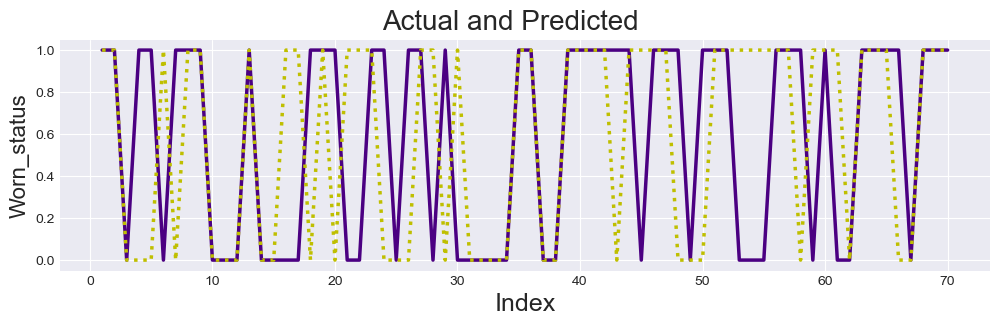

In [72]:
# actual vs predicted
predicted_plot(y_test, y_pred_test_LR)

On the graph we can see the difference between the real value and what the model predicted for us.

## Step #3.5: Gaussian NB

In [73]:
# training the model using Pipeline with Grid Search
NB_pipe=Pipeline([('Imputation',MeanMedianImputer(variables=missing)),
                  ('Discretization',EqualFrequencyDiscretiser(variables = discr_list)),
                  ('Scaler',StandardScaler()),
                  ('Quasi-Constant',DropConstantFeatures(tol=0.9)),
                  ('CorrelatedSelection',SmartCorrelatedSelection(selection_method='cardinality')),
                  ('GaussianNB',GaussianNB())])

params_NB = [{
        'Imputation' : [ArbitraryNumberImputer(variables=missing),
                        MeanMedianImputer(imputation_method='mean',variables=missing),
                        MeanMedianImputer(imputation_method='median', variables=missing),
                        RandomSampleImputer(variables=missing)],
    
        'Discretization' : [EqualFrequencyDiscretiser(q=5,variables=discr_list),
                            EqualFrequencyDiscretiser(q=10,variables=discr_list),
                            EqualWidthDiscretiser(bins=5,variables=discr_list),
                            EqualWidthDiscretiser(bins=10,variables=discr_list)],
    
        'Scaler' : [StandardScaler(),
                    RobustScaler(),
                    MinMaxScaler()]
    }]

NB_gridSearch = GridSearchCV(estimator = NB_pipe, param_grid = params_NB, cv = 5, n_jobs = -1, scoring = 'accuracy')
NB_gridSearch.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Imputation',
                                        MeanMedianImputer(variables=['X1_ActualPosition',
                                                                     'X1_ActualVelocity',
                                                                     'X1_ActualAcceleration',
                                                                     'X1_CommandPosition',
                                                                     'X1_CommandVelocity',
                                                                     'X1_CommandAcceleration',
                                                                     'X1_CurrentFeedback',
                                                                     'X1_DCBusVoltage',
                                                                     'X1_OutputCurrent',
                                                                     'X1_OutputVoltage',
                                                                     'X1_OutputPower',
                                                                     'Y1_ActualPosition',
                                                                     'Y1_ActualVelocity...
                                                                        'Y1_CurrentFeedback',
                                                                        'Y1_DCBusVoltage',
                                                                        'Y1_OutputCurrent',
                                                                        'Y1_OutputVoltage',
                                                                        'Y1_OutputPower',
                                                                        'Z1_ActualPosition',
                                                                        'Z1_ActualVelocity',
                                                                        'Z1_ActualAcceleration',
                                                                        'Z1_CommandPosition',
                                                                        'Z1_CommandVelocity',
                                                                        'Z1_CommandAcceleration',
                                                                        'S1_ActualPosition',
                                                                        'S1_ActualVelocity', ...])],
                          'Scaler': [StandardScaler(), RobustScaler(),
                                     MinMaxScaler()]}],
             scoring='accuracy')

In [74]:
# selection of the best parameters
NB_gridSearch.best_params_

{'Discretization': EqualFrequencyDiscretiser(variables=['X1_ActualPosition', 'X1_ActualVelocity',
                                      'X1_ActualAcceleration',
                                      'X1_CommandPosition', 'X1_CommandVelocity',
                                      'X1_CommandAcceleration',
                                      'X1_CurrentFeedback', 'X1_DCBusVoltage',
                                      'X1_OutputVoltage', 'X1_OutputPower',
                                      'Y1_ActualPosition', 'Y1_ActualVelocity',
                                      'Y1_ActualAcceleration',
                                      'Y1_CommandPosition', 'Y1_CommandVelocity',
                                      'Y1_CommandAcceleration',
                                      'Y1_CurrentFeedback', 'Y1_DCBusVoltage',
                                      'Y1_OutputVoltage', 'Y1_OutputPower',
                                      'Z1_ActualPosition', 'Z1_ActualVelocity',
              

In [75]:
# prediction
y_pred_train_NB = NB_gridSearch.predict(X_train)
y_pred_test_NB = NB_gridSearch.predict(X_test)

Train: 
accuracy 0.568709133094284
              precision    recall  f1-score   support

           0       0.57      0.37      0.45      8965
           1       0.57      0.74      0.65      9999

    accuracy                           0.57     18964
   macro avg       0.57      0.56      0.55     18964
weighted avg       0.57      0.57      0.55     18964

------------------------------------------------------
Test: 
accuracy 0.5846251186333439
              precision    recall  f1-score   support

           0       0.60      0.38      0.46      3013
           1       0.58      0.77      0.66      3309

    accuracy                           0.58      6322
   macro avg       0.59      0.58      0.56      6322
weighted avg       0.59      0.58      0.57      6322



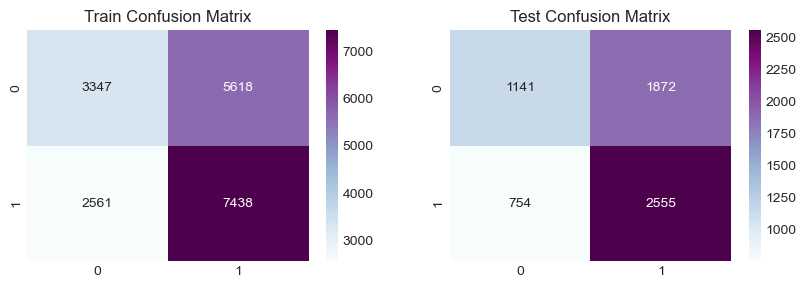

In [76]:
# let's have a look at the classification report and confution matrix
score_show(y_train, y_test,y_pred_train_NB,y_pred_test_NB)

On the test dataset, the model correctly predicted of tool don't wear 1141 times and tool wear 2555 times. However, the model made a false positive error 1872 times and a false negative error 754 times.

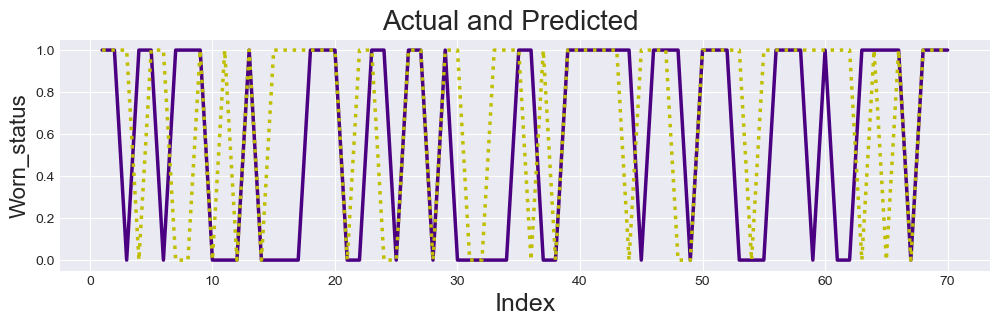

In [77]:
# actual vs predicted
predicted_plot(y_test, y_pred_test_NB)

On the graph we can see the difference between the real value and what the model predicted for us.

## Step #3.6: XGBClassifier

In [78]:
# training the model using Pipeline with Grid Search
XGB_pipe=Pipeline([('Imputation',MeanMedianImputer(variables=missing)),
                  ('Discretization',EqualFrequencyDiscretiser(variables = discr_list)),
                 # ('Scaler',StandardScaler()),
                  ('Quasi-Constant',DropConstantFeatures(tol=0.9)),
                  ('CorrelatedSelection',SmartCorrelatedSelection(selection_method='cardinality')),
                  ('XGBClassifier',XGBClassifier())])

params_XGB = [{
        'Imputation' : [ArbitraryNumberImputer(variables=missing),
                        MeanMedianImputer(imputation_method='mean',variables=missing),
                        MeanMedianImputer(imputation_method='median', variables=missing),
                        RandomSampleImputer(variables=missing)],
    
        'Discretization' : [EqualFrequencyDiscretiser(q=5,variables=discr_list),
                            EqualFrequencyDiscretiser(q=10,variables=discr_list),
                            EqualWidthDiscretiser(bins=5,variables=discr_list),
                            EqualWidthDiscretiser(bins=10,variables=discr_list)],
    
#         'Scaler' : [StandardScaler(),
#                     RobustScaler(),
#                     MinMaxScaler()],
        'XGBClassifier__gamma': [0,1,2],
        'XGBClassifier__max_depth':[1,2]
    }]

XGB_gridSearch = GridSearchCV(estimator = XGB_pipe, param_grid = params_XGB, cv = 5, n_jobs = -1, scoring = 'accuracy')
XGB_gridSearch.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Imputation',
                                        MeanMedianImputer(variables=['X1_ActualPosition',
                                                                     'X1_ActualVelocity',
                                                                     'X1_ActualAcceleration',
                                                                     'X1_CommandPosition',
                                                                     'X1_CommandVelocity',
                                                                     'X1_CommandAcceleration',
                                                                     'X1_CurrentFeedback',
                                                                     'X1_DCBusVoltage',
                                                                     'X1_OutputCurrent',
                                                                     'X1_OutputVoltage',
                                                                     'X1_OutputPower',
                                                                     'Y1_ActualPosition',
                                                                     'Y1_ActualVelocity...
                                                                        'Y1_CurrentFeedback',
                                                                        'Y1_DCBusVoltage',
                                                                        'Y1_OutputCurrent',
                                                                        'Y1_OutputVoltage',
                                                                        'Y1_OutputPower',
                                                                        'Z1_ActualPosition',
                                                                        'Z1_ActualVelocity',
                                                                        'Z1_ActualAcceleration',
                                                                        'Z1_CommandPosition',
                                                                        'Z1_CommandVelocity',
                                                                        'Z1_CommandAcceleration',
                                                                        'S1_ActualPosition',
                                                                        'S1_ActualVelocity', ...])],
                          'XGBClassifier__gamma': [0, 1, 2],
                          'XGBClassifier__max_depth': [1, 2]}],
             scoring='accuracy')

In [79]:
# selection of the best parameters
XGB_gridSearch.best_params_

{'Discretization': EqualFrequencyDiscretiser(variables=['X1_ActualPosition', 'X1_ActualVelocity',
                                      'X1_ActualAcceleration',
                                      'X1_CommandPosition', 'X1_CommandVelocity',
                                      'X1_CommandAcceleration',
                                      'X1_CurrentFeedback', 'X1_DCBusVoltage',
                                      'X1_OutputVoltage', 'X1_OutputPower',
                                      'Y1_ActualPosition', 'Y1_ActualVelocity',
                                      'Y1_ActualAcceleration',
                                      'Y1_CommandPosition', 'Y1_CommandVelocity',
                                      'Y1_CommandAcceleration',
                                      'Y1_CurrentFeedback', 'Y1_DCBusVoltage',
                                      'Y1_OutputVoltage', 'Y1_OutputPower',
                                      'Z1_ActualPosition', 'Z1_ActualVelocity',
              

In [80]:
# prediction 
y_pred_train_XGB = XGB_gridSearch.predict(X_train)
y_pred_test_XGB = XGB_gridSearch.predict(X_test)

Train: 
accuracy 0.919953596287703
              precision    recall  f1-score   support

           0       0.92      0.91      0.92      8965
           1       0.92      0.93      0.92      9999

    accuracy                           0.92     18964
   macro avg       0.92      0.92      0.92     18964
weighted avg       0.92      0.92      0.92     18964

------------------------------------------------------
Test: 
accuracy 0.9158494147421702
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      3013
           1       0.91      0.93      0.92      3309

    accuracy                           0.92      6322
   macro avg       0.92      0.92      0.92      6322
weighted avg       0.92      0.92      0.92      6322



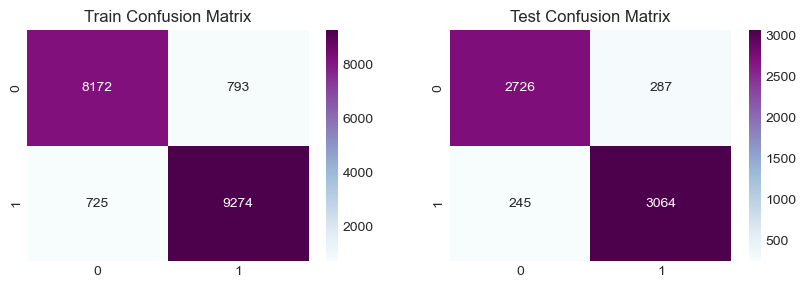

In [81]:
# let's have a look at the classification report and confution matrix
score_show(y_train, y_test,y_pred_train_XGB,y_pred_test_XGB)

On the test dataset, the model correctly predicted of tool don't wear 2726 times and tool wear 3064 times. However, the model made a false positive error 287 times and a false negative error 245 times.

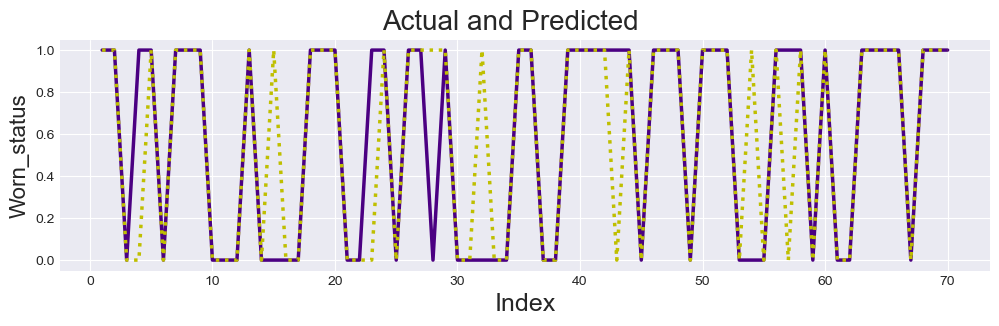

In [82]:
# actual vs predicted
predicted_plot(y_test, y_pred_test_XGB)

On the graph we can see the difference between the real value and what the model predicted for us.

## Step #3.7: Support Vector Classifier

In [83]:
# training the model using Pipeline with Grid Search
SVC_pipe=Pipeline([('Imputation',MeanMedianImputer(variables=missing)),
                  ('Discretization',EqualFrequencyDiscretiser(variables = discr_list)),
                  ('Scaler',StandardScaler()),
                  ('Quasi-Constant',DropConstantFeatures(tol=0.9)),
                  ('CorrelatedSelection',SmartCorrelatedSelection(selection_method='cardinality')),
                  ('SVC',SVC())])

params_SVC = [{
        'Imputation' : [ArbitraryNumberImputer(variables=missing),
                        MeanMedianImputer(imputation_method='mean',variables=missing),
                        MeanMedianImputer(imputation_method='median', variables=missing),
                        RandomSampleImputer(variables=missing)],
    
        'Discretization' : [EqualFrequencyDiscretiser(q=5,variables=discr_list),
                            EqualFrequencyDiscretiser(q=10,variables=discr_list),
                            EqualWidthDiscretiser(bins=5,variables=discr_list),
                            EqualWidthDiscretiser(bins=10,variables=discr_list)],
    
        'Scaler' : [StandardScaler(),
                    RobustScaler(),
                    MinMaxScaler()],
        'SVC__gamma': [0.1,0.2],
        'SVC__degree': [2,3],
        'SVC__probability': [True]
    }]

SVC_gridSearch = GridSearchCV(estimator =SVC_pipe, param_grid = params_SVC, cv = 5, n_jobs = -1, scoring = 'accuracy')
SVC_gridSearch.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Imputation',
                                        MeanMedianImputer(variables=['X1_ActualPosition',
                                                                     'X1_ActualVelocity',
                                                                     'X1_ActualAcceleration',
                                                                     'X1_CommandPosition',
                                                                     'X1_CommandVelocity',
                                                                     'X1_CommandAcceleration',
                                                                     'X1_CurrentFeedback',
                                                                     'X1_DCBusVoltage',
                                                                     'X1_OutputCurrent',
                                                                     'X1_OutputVoltage',
                                                                     'X1_OutputPower',
                                                                     'Y1_ActualPosition',
                                                                     'Y1_ActualVelocity...
                                                                        'Y1_OutputVoltage',
                                                                        'Y1_OutputPower',
                                                                        'Z1_ActualPosition',
                                                                        'Z1_ActualVelocity',
                                                                        'Z1_ActualAcceleration',
                                                                        'Z1_CommandPosition',
                                                                        'Z1_CommandVelocity',
                                                                        'Z1_CommandAcceleration',
                                                                        'S1_ActualPosition',
                                                                        'S1_ActualVelocity', ...])],
                          'SVC__degree': [2, 3], 'SVC__gamma': [0.1, 0.2],
                          'SVC__probability': [True],
                          'Scaler': [StandardScaler(), RobustScaler(),
                                     MinMaxScaler()]}],
             scoring='accuracy')

In [84]:
# selection of the best parameters
SVC_gridSearch.best_params_

{'Discretization': EqualFrequencyDiscretiser(variables=['X1_ActualPosition', 'X1_ActualVelocity',
                                      'X1_ActualAcceleration',
                                      'X1_CommandPosition', 'X1_CommandVelocity',
                                      'X1_CommandAcceleration',
                                      'X1_CurrentFeedback', 'X1_DCBusVoltage',
                                      'X1_OutputVoltage', 'X1_OutputPower',
                                      'Y1_ActualPosition', 'Y1_ActualVelocity',
                                      'Y1_ActualAcceleration',
                                      'Y1_CommandPosition', 'Y1_CommandVelocity',
                                      'Y1_CommandAcceleration',
                                      'Y1_CurrentFeedback', 'Y1_DCBusVoltage',
                                      'Y1_OutputVoltage', 'Y1_OutputPower',
                                      'Z1_ActualPosition', 'Z1_ActualVelocity',
              

In [85]:
# prediction 
y_pred_train_SVC = SVC_gridSearch.predict(X_train)
y_pred_test_SVC = SVC_gridSearch.predict(X_test)

Train: 
accuracy 0.9446319341910989
              precision    recall  f1-score   support

           0       0.94      0.95      0.94      8965
           1       0.95      0.94      0.95      9999

    accuracy                           0.94     18964
   macro avg       0.94      0.94      0.94     18964
weighted avg       0.94      0.94      0.94     18964

------------------------------------------------------
Test: 
accuracy 0.8913318570072761
              precision    recall  f1-score   support

           0       0.89      0.88      0.89      3013
           1       0.89      0.90      0.90      3309

    accuracy                           0.89      6322
   macro avg       0.89      0.89      0.89      6322
weighted avg       0.89      0.89      0.89      6322



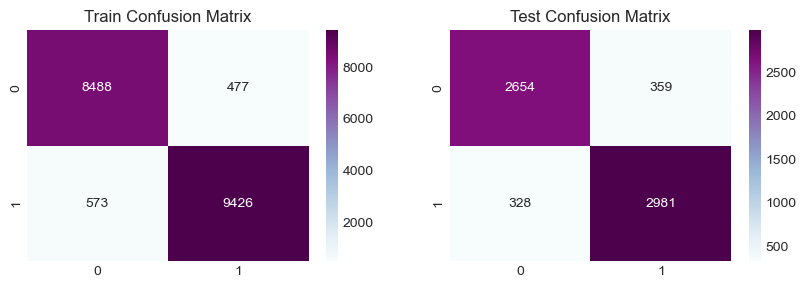

In [86]:
# let's have a look at the classification report and confution matrix
score_show(y_train, y_test,y_pred_train_SVC,y_pred_test_SVC)

On the test dataset, the model correctly predicted of tool don't wear 2654 times and tool wear 2981 times. However, the model made a false positive error 359 times and a false negative error 328 times.

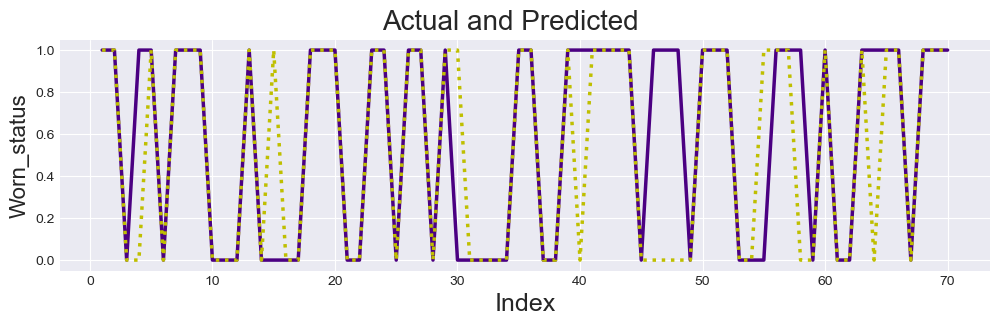

In [87]:
# actual vs predicted
predicted_plot(y_test, y_pred_test_SVC)

On the graph we can see the difference between the real value and what the model predicted for us.

 ## Step #3.8 VotingClassifier

In [88]:
# create pipline
pipe = Pipeline([('Imputation',MeanMedianImputer(variables=missing)),
                  ('Discretization',EqualFrequencyDiscretiser(variables = discr_list)),
                  ('Scaler',StandardScaler()),
                  ('Quasi-Constant',DropConstantFeatures(tol=0.9)),
                  ('CorrelatedSelection',SmartCorrelatedSelection(selection_method='cardinality'))])
X_train=pipe.fit_transform(X_train)
X_test=pipe.transform(X_test)

In [89]:
# group / ensemble of models
models = []
models.append(("DTC",DecisionTreeClassifier(max_depth=8, min_samples_leaf=4, criterion = 'gini')))
models.append(("RF",RandomForestClassifier(max_depth=5,min_samples_leaf=3,n_estimators=600, criterion = 'gini')))
models.append(("KN",KNeighborsClassifier(n_neighbors=8,p= 1,metric= 'manhattan',weights= 'distance')))
models.append(("LR",LogisticRegression(C= 0.1,dual=False,penalty='l2',solver='saga')))
models.append(("GNB",GaussianNB()))
models.append(("XGB",XGBClassifier(gamma=1,max_depth=2)))
models.append(("SVC",SVC(degree=2.0,gamma=0.2,probability= True)))

# Voting Classifier with soft voting
vot_soft = VotingClassifier(estimators = models, voting ='soft')
vot_soft.fit(X_train, y_train)

VotingClassifier(estimators=[('DTC',
                              DecisionTreeClassifier(max_depth=8,
                                                     min_samples_leaf=4)),
                             ('RF',
                              RandomForestClassifier(max_depth=5,
                                                     min_samples_leaf=3,
                                                     n_estimators=600)),
                             ('KN',
                              KNeighborsClassifier(metric='manhattan',
                                                   n_neighbors=8, p=1,
                                                   weights='distance')),
                             ('LR', LogisticRegression(C=0.1, solver='saga')),
                             ('GNB', GaussianNB()),
                             ('XGB',
                              XGBClassifier(base_...
                                            learning_rate=None, max_bin=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=2,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None,
                                            reg_alpha=None, reg_lambda=None, ...)),
                             ('SVC',
                              SVC(degree=2.0, gamma=0.2, probability=True))],
                 voting='soft')

In [90]:
# prediction
y_pred_train_vot = vot_soft.predict(X_train)
y_pred_test_vot = vot_soft.predict(X_test)

Train: 
accuracy 0.992723054207973
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      8965
           1       0.99      1.00      0.99      9999

    accuracy                           0.99     18964
   macro avg       0.99      0.99      0.99     18964
weighted avg       0.99      0.99      0.99     18964

------------------------------------------------------
Test: 
accuracy 0.9384688389750079
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      3013
           1       0.94      0.94      0.94      3309

    accuracy                           0.94      6322
   macro avg       0.94      0.94      0.94      6322
weighted avg       0.94      0.94      0.94      6322



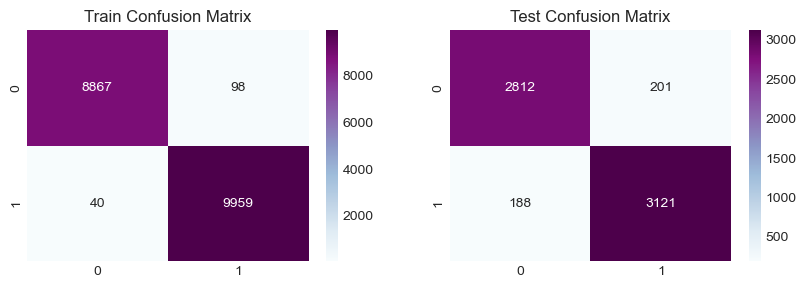

In [91]:
# let's have a look at the classification report and confution matrix
score_show(y_train, y_test,y_pred_train_vot,y_pred_test_vot)

On the test dataset, the model correctly predicted of tool don't wear 2812 times and tool wear 3121 times. However, the model made a false positive error 201 times and a false negative error 188 times.

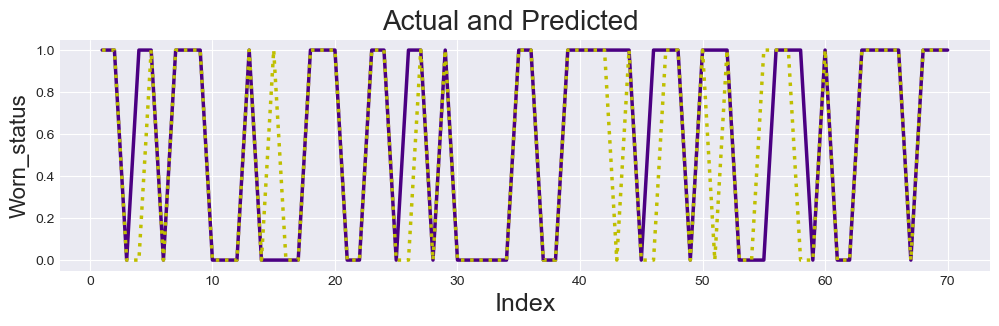

In [92]:
# actual vs predicted
predicted_plot(y_test, y_pred_test_vot)

On the graph we can see the difference between the real value and what the model predicted for us.

## Step #4: Record Classification Metrics

In [93]:
# let's record the classification metrics from the report for each model.
def generate_scores(y_true, y_pred):
    
    model_accuracy = round(accuracy_score(y_true, y_pred), 4)
    model_rocauc = round(roc_auc_score(y_true,y_pred), 4)
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")

    preformance_scores = {'accuracy_score': model_accuracy,
                          'roc_auc_score' : model_rocauc,
                          'precision_score': model_precision,
                          'recall_score': model_recall,
                          'f1_score': model_f1}
    return preformance_scores

In [94]:
# with generate_scores function evaluate models
DT_performance = generate_scores(y_test, y_pred_test_DT)
RF_performance = generate_scores(y_test, y_pred_test_RF)
KN_performance = generate_scores(y_test, y_pred_test_KN)
LR_performance = generate_scores(y_test, y_pred_test_LR)
NB_performance = generate_scores(y_test, y_pred_test_NB)
XGB_performance = generate_scores(y_test, y_pred_test_XGB)
SVC_performance = generate_scores(y_test, y_pred_test_SVC)
vot_performance = generate_scores(y_test, y_pred_test_vot)

In [95]:
# call columns in DataFrame
performace_df = pd.DataFrame({
    'VotingClassifier': vot_performance,
    'DecisionTreeClassifier': DT_performance,
    'RandomForestClassifier': RF_performance,
    'KNeighborsClassifier': KN_performance,
    'LogisticRegression': LR_performance,
    'GaussianNB': NB_performance,
    'XGBClassifier': XGB_performance,
    'SVC': SVC_performance
}).T
performace_df.sort_values(by =['accuracy_score', 'roc_auc_score', 'precision_score','recall_score','f1_score'],
                          ascending = False)

accuracy_score  roc_auc_score  precision_score  \
VotingClassifier                0.9385         0.9382         0.938464   
XGBClassifier                   0.9158         0.9154         0.915871   
KNeighborsClassifier            0.9041         0.9041         0.904195   
SVC                             0.8913         0.8909         0.891320   
DecisionTreeClassifier          0.8564         0.8597         0.866094   
RandomForestClassifier          0.8404         0.8424         0.844535   
LogisticRegression              0.6435         0.6413         0.642977   
GaussianNB                      0.5846         0.5754         0.589041   

                        recall_score  f1_score  
VotingClassifier            0.938469  0.938463  
XGBClassifier               0.915849  0.915819  
KNeighborsClassifier        0.904144  0.904159  
SVC                         0.891332  0.891304  
DecisionTreeClassifier      0.856375  0.856033  
RandomForestClassifier      0.840399  0.840375  
LogisticRegression          0.643467  0.642699  
GaussianNB                  0.584625  0.567331

## Conclusion
We tried to build a model to predict of tool wear detection.

* After analyzing the dataset, we saw that the distribution of variables is skewed, that there are outliers, and that there is no linearity. We analyzed the variables for missing data, and because the variables there are missing less than 0.2% data, each imputer worked well. We also analyzed discretization variables and performed a scaling analysis.
* We removed empty variables and variables that correlate well with feature selection.
* Trained the model with various hyperparameters, metrics and found that the best model is VotingClassifier.
* The worst model is GaussianNB with an accuracy of 58%